<a href="https://colab.research.google.com/github/BLayus/MVP_Machine-Learning/blob/main/MVP_Machine_Learning_Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Etapa 1 - Importando Bibliotecas e Datasets

In [ ]:
# Instalando bibliotecas

!pip install category_encoders

!pip install mlflow

!pip install scikit-optimize

!pip install keras-tuner

!pip install pyngrok



In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import datetime
import os
import subprocess
import shutil
import time
from tqdm.notebook import tqdm
import joblib
import requests
from io import BytesIO

# Data Viz Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Statistics and Statistical Tests
import statsmodels.api as sm
import scipy.stats
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import (train_test_split, KFold, cross_val_score,
                                     StratifiedKFold, RandomizedSearchCV, cross_validate)

from sklearn.impute import SimpleImputer
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from category_encoders import WOEEncoder

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, BaggingClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
import keras_tuner as kt


from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from functools import partial

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (roc_curve, auc, roc_auc_score, confusion_matrix, log_loss,
                             precision_score, accuracy_score, recall_score, f1_score, classification_report,
                             make_scorer, precision_recall_curve, precision_recall_fscore_support, average_precision_score)

# Model Monitoring
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from pyngrok import ngrok


In [ ]:
# Load Raw Dataset from Git Hub

df = pd.read_csv("https://raw.githubusercontent.com/BLayus/MVP_Machine-Learning/refs/heads/main/Dataset/ML_Dataset_Credit%20Card%20Fraud.csv")


In [ ]:
# Show dataset sample

df.sample(3)


,score_1,score_2,score_3,score_4,score_5,score_6,pais,score_7,produto,categoria_produto,score_8,score_9,score_10,entrega_doc_1,entrega_doc_2,entrega_doc_3,data_compra,valor_compra,score_fraude_modelo,fraude
75006,4,0.8361,636693.92,50.0,0.000000,76.0,BR,6,Bicicleta Infantil Nathor Aro 12 Menino Veloz ...,cat_67f7bf0,0.100424,5941.0,739.0,1,NaN,Y,2020-04-12 14:10:49,37.74,33,0
81123,4,0.7847,17460.01,50.0,0.176968,13.0,BR,5,Capa Capinha Silicone Compatível iPhone 11 / ...,cat_0820fab,0.583465,1713.0,631.0,1,NaN,Y,2020-03-22 16:04:15,8.23,53,0
97460,4,0.7976,5891.26,43.0,0.638128,0.0,BR,8,Aspirador Pó E Líquido Portátil Multilaser 12v...,cat_c00ebe0,0.028074,128.0,128.0,0,NaN,N,2020-03-18 21:57:23,10.71,94,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   score_1              150000 non-null  int64  
 1   score_2              137016 non-null  float64
 2   score_3              137016 non-null  float64
 3   score_4              149635 non-null  float64
 4   score_5              150000 non-null  float64
 5   score_6              149989 non-null  float64
 6   pais                 149806 non-null  object 
 7   score_7              150000 non-null  int64  
 8   produto              150000 non-null  object 
 9   categoria_produto    150000 non-null  object 
 10  score_8              150000 non-null  float64
 11  score_9              149989 non-null  float64
 12  score_10             149635 non-null  float64
 13  entrega_doc_1        150000 non-null  int64  
 14  entrega_doc_2        41143 non-null   object 
 15  entrega_doc_3    

In [ ]:
# Aplicando um plot style para os gráficos

#plt.style.use('seaborn-v0_8')

sns.set_style('darkgrid', {'grid.color': '.8',
                           'grid.linestyle': '-',
                           'text.color': '.2',
                           'xtick.color': 'dimgray',
                           'ytick.color': 'dimgray',
                           'axes.labelcolor': 'dimgray'})

# Definindo a paleta de cores
cor_fraudes= {0: "#4A90E2", 1: "#D9534F"}
colors = ['#4c94de', 'grey', 'cornflowerblue', 'silver', 'lightsteelblue', 'whitesmoke']
sns.set_palette(sns.color_palette(colors))

### Dicionário de Dados

**score_1 a score_10**: São notas de bureau de crédito adquiridos para identificar a confiabilidade do comprador ou outros dados anonimizados sem informação especíifica.

**País**: país de compra.

**Produto**: produto que está sendo comprado no e-commerce.

**Categoria_produto**: categoria do produto.

**Entrega_doc_1 a entrega_doc_3**: Documentos necessários para fazer a conta. 0 = não entregou.  1 = entregou. Se vazio, considerar que nao entregou.

**Score_modelo**: score dado pelo modelo atual. Quanto mais próximo de 100, maior a probabilidade de fraude.

**Valor da Compra**: Valor da transação

**Fraude**: Label inserido pós compra, identificando se a compra foi fraude ou não. 0 = Não Fraude. 1 = Fraude


### Hipóteses e Perguntas de Negócio

  * Dentro de um projeto de classificação de fraudes, qual algoritmo oferece uma melhor resposta?

  * Quais as métricas mais adequadas para monitorarmos esses modelos?

  * Quais destes algoritmos oferecem uma resposta mais rápida, além de eficaz? Faz sentido escolher algoritmos mais complexos, que levam mais tempo para serem aplicados? Quanto de performance adicional pode ser conseguida com maior complexidade? Analisar este balanço entre eficiência e complexidade.

  * Discutir a questão do desbalanceamento dos dados: faz sentido usar técnicas de balanceamento tipo SMOTE, oversampling ou undersampling se os dados da vida real não são balanceados?

  * Modelos clássicos de ML são mais simples de treinar e possuem resultados mais fáceis de explicar do que modelos de redes neurais?

  * Como aplicar estratégias de otimização do treinamento, por exemplo k-folds, cross-validation e search for best hyperparameters nos diferentes tipos de modelos?

  * Elaborar uma estratégia de avaliação dos modelos baseada em métricas estatísticas é o modo mais adequado para definir o melhor modelo de ML? Associar melhores métricas estatísticas com métricas de negócio e capacidade de implementação dos modelos pode resultar na escolha de um modelo diferente cuja métrica estatística é um pouco pior?


## Etapa 2 - Tratamento Inicial dos Dados

In [ ]:
# Reordenando colunas para manter as colunas "score" juntas, facilitando a leitura

df = df.reindex(columns= ['score_1', 'score_2', 'score_3', 'score_4', 'score_5', 'score_6',
'score_7', 'score_8', 'score_9', 'score_10', 'entrega_doc_1',
'entrega_doc_2', 'entrega_doc_3', 'pais', 'produto', 'categoria_produto','data_compra',
'valor_compra', 'score_fraude_modelo', 'fraude'])


In [ ]:
# Acertando os dtypes, tipos de dados

# Trocando dtype da coluna data_compras

df["data_compra"] = pd.to_datetime(df["data_compra"], errors='coerce')



In [ ]:
# Avaliação da quantidade de nulos em ordem descendente

display(df.isnull().sum().sort_values(ascending=False))


,0
entrega_doc_2,108857
score_2,12984
score_3,12984
score_4,365
score_10,365
pais,194
score_9,11
score_6,11
score_1,0
score_8,0


O dataset possui poucos valores nulos, principalmente concentrado na coluna "entrega_doc_2", com 108.857 nulos.

Há também  12.984 valores nulos nas colunas "score_2", "score_3" e em menor quantidade (365) nas colunas "score_4" e "score_10".

Alguns valores nulos (194) na coluna "País", que talvez possam ser preenchidos com base em uma outa coluna.

Alguns poucos nulos nas colunas "score_6" e "score_9" (11 em cada coluna).

### Análise das Variáveis

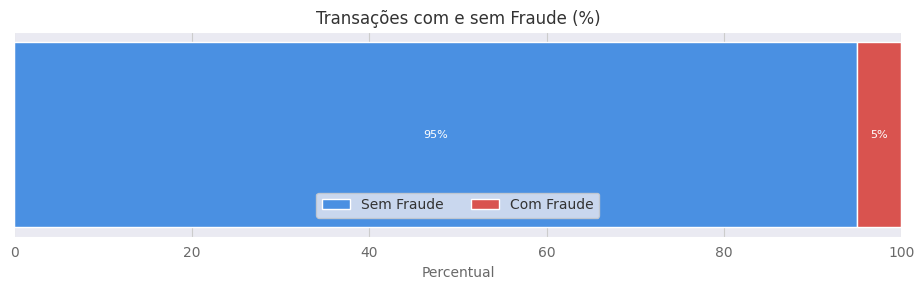

In [ ]:
# Plotar um gráfico de barras alinhadas na horizontal comparando transações com e sem fraude

fraude = (df['fraude'] == 1).sum()
n_fraude = (df['fraude'] == 0).sum()
total = len(df['fraude'])

perc_fraude= fraude / total * 100
perc_n_fraude= n_fraude / total * 100

fig, ax = plt.subplots(figsize= (10, 3))
ax.barh(y=[""], width=perc_n_fraude, color=cor_fraudes[0], label="Sem Fraude")
ax.barh(y=[""], width=perc_fraude, left=perc_n_fraude, color=cor_fraudes[1], label="Com Fraude")

ax.invert_yaxis()
ax.set_xlim(0, 100)
ax.set_xlabel("Percentual")
ax.set_ylabel("")
ax.set_title("Transações com e sem Fraude (%)")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.25), ncol=2, frameon=True)

y_center_bar = 0

ax.text(x=(perc_n_fraude / 2), y=y_center_bar, s=f"{perc_n_fraude:.0f}%", ha='center', va='center', fontsize=8, color='white')
ax.text(x=(perc_n_fraude + perc_fraude/ 2), y=y_center_bar, s=f"{perc_fraude:.0f}%", ha='center', va='center', fontsize=8, color='white')

plt.subplots_adjust(left=0.1, right=0.3, top=0.3, bottom=0.1)
plt.tight_layout()
plt.show()


### Proporção de Fraudes

  * Das 150 mil linhas de dados deste conjunto, 7500 foram rotuladas como fraudes, o que significa 5% do total.

  * Trata-se de um dataset com forte desbalanceamento de classes, mais adiante será necessário pensar em estratégias para lidar com este tipo de desbalanceamento.

### Correlação Entre as Variáveis

In [ ]:
# Calcular assoiação chi quadrado entre entrega doc 1, 2 e 3 e fraude

def chi2_fraude(df, col, target='fraude'):

  """
  Calcula X2, p-value  e coef phi, que mede a força da associação
  """
  cont_tab = pd.crosstab(df[col], df[target])
  chi2, p, dof, _ = chi2_contingency(cont_tab, correction= False)

  n = cont_tab.values.sum()
  phi = np.sqrt(chi2 / n)

  return chi2, p, phi


In [ ]:
# Aplica função

cols= ['entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3']

results = []

for col in cols:
  chi2, p, phi = chi2_fraude(df, col, target= 'fraude')
  results.append({'variável': col,
                  'X^2': chi2,
                  'p-value': p,
                  'phi': phi})
  if p < 0.05:
    print(f'p-value {col} < 0.05 => Associação estatisticamente significativa \n')
  else:
    print(f'p-value {col} > 0.05 => Associação não é estatisticamnte significativa \n')


chi2_df = pd.DataFrame(results)

print(chi2_df)


p-value entrega_doc_1 < 0.05 => Associação estatisticamente significativa 

p-value entrega_doc_2 < 0.05 => Associação estatisticamente significativa 

p-value entrega_doc_3 < 0.05 => Associação estatisticamente significativa 

        variável          X^2  p-value       phi
0  entrega_doc_1  4219.909400      0.0  0.167728
1  entrega_doc_2  2095.345615      0.0  0.225673
2  entrega_doc_3  1710.927028      0.0  0.106800


In [ ]:
# Calcular o coeficiente de correlação point bi serial entre as variáveis e a variável fraude

# Fraude é uma variável binária e o restante são variáveis numéricas contínuas

correlations = {}

num_cols = ['score_2', 'score_3', 'score_4', 'score_5', 'score_6',
            'score_7', 'score_9', 'score_10', 'valor_compra']

# Cálculo correlação de Pearson
corr_pearson = df[num_cols].corr()

# Cálculo correlação Bi-serial
correlations = {}

for col in num_cols:

  x = pd.to_numeric(df[col], errors= 'coerce')
  y = df['fraude'].astype(int)

  mascara = np.isfinite(x)
  r, p = pointbiserialr(x[mascara], y[mascara])
  correlations[col] = {'Point_biserial': r, 'p_value': p}

biserial_df = pd.DataFrame.from_dict(correlations, orient= 'index')


# Cria um df combinado (quadrado) com uma linha extra para corr Bi-serial
combinado = corr_pearson.copy()
combinado['fraude'] = np.nan # cria nova coluna
combinado.loc['fraude'] = np.nan # cria nova linha

# Preenche fraude X numéricas com Bi-serial
for col in num_cols:
  r_pb = biserial_df.loc[col, 'Point_biserial']
  combinado.loc['fraude', col] = r_pb
  combinado.loc[col, 'fraude'] = r_pb

# Criando inhha e coluna extra para as correlaçoes chi2
for col, phi in zip(chi2_df['variável'], chi2_df['phi']):
  combinado[col] = np.nan # cria coluna
  combinado.loc[col, 'fraude'] = np.nan # cria linha

  # preenche fraude x docs
  combinado.loc['fraude', col] = phi
  combinado.loc[col, 'fraude'] = phi

combinado.loc['fraude', 'fraude'] = 1 # marcando diagonal


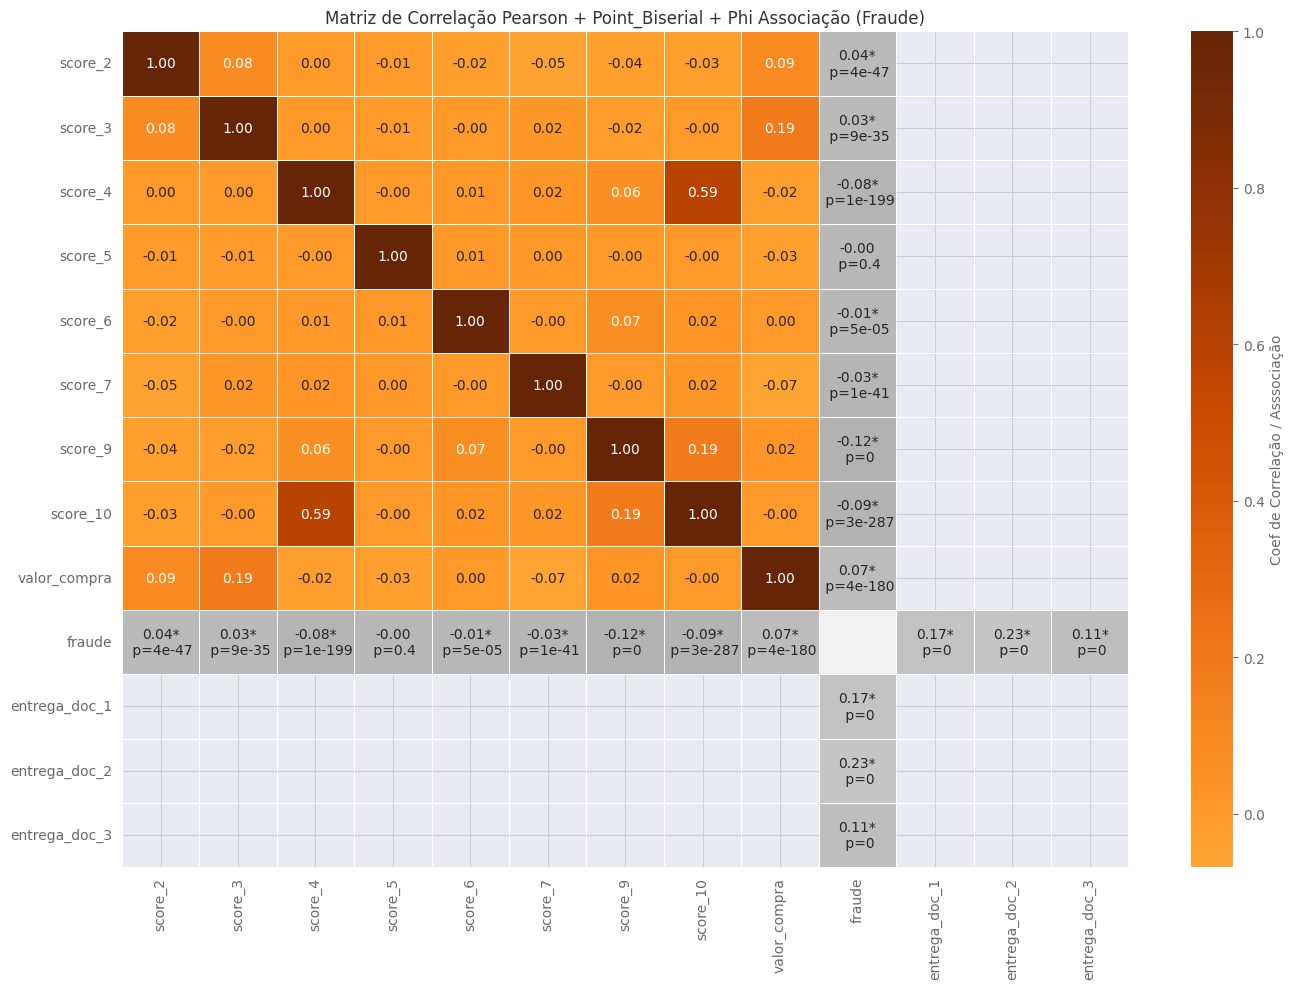

In [ ]:
# Plotando correlação combinada Pearson e Bi-Serial em heatmap

mask_pb = np.ones_like(combinado, dtype= bool)
mask_pb[combinado.index.get_loc('fraude'), :] = False
mask_pb[:, combinado.columns.get_loc('fraude')] = False

mask_prs = ~mask_pb

# Anotações para a correlação bi-serial com p-value
def make_annot(i, j):
  if i == 'fraude' and j == 'fraude':
    return ''

  if i == 'fraude' or j == 'fraude':
    col = j if i == 'fraude' else i
    if col in chi2_df['variável'].values:
      phi = chi2_df.set_index('variável').loc[col, 'phi']
      p = chi2_df.set_index('variável').loc[col, 'p-value']
      mark = '*' if p <0.05 else ''
      return f'{phi:.2f}{mark}\n p={p:.1g}'

    else:
      r = biserial_df.loc[col, 'Point_biserial']
      p = biserial_df.loc[col, 'p_value']
      mark = '*' if p <0.05 else ''

      return f"{r:.2f}{mark}\n p={p:.1g}"

  else:
    return f"{combinado.loc[i, j]:.2f}"

annot_text = combinado.copy().astype(str)
for i in combinado.index:
  for j in combinado.columns:
    annot_text.loc[i, j] = make_annot(i, j)


# Plotando heatmap pearson
plt.figure(figsize = (14, 10))

sns.heatmap(combinado, mask= mask_prs,
            annot = annot_text.values,
            fmt = '',
            cmap = "YlOrBr",
            center= 0,
            linewidths= 0.5,
            cbar_kws= {'label': 'Coef de Correlação / Asssociação'})

grey_cmap = sns.light_palette('gray', as_cmap= True, reverse= True)
sns.heatmap(combinado, mask = mask_pb,
            cmap = grey_cmap,
            center= 0,
            annot = annot_text.values,
            fmt= '',
            linewidths = 0.5,
            cbar = False)

plt.title("Matriz de Correlação Pearson + Point_Biserial + Phi Associação (Fraude)")

plt.tight_layout()
plt.show()



**Análise das Correlaçcões**

  * A correlação de Pearson mede a proporcionalidade entre uma variável e utra. Grosso modo, é uma razão matemática ajustada entre as médias de cada variável que varia de -1 a 1. Se uma correlação é positiva, a relação entre as variáeis é diretamente proporcional. Se a correlação é negativa, então a relação entre as variáveis é inversamente proporcional. Já se a correlação é igual a zero, então não há proporcionalidade entre as variáveis.

  * A correlação de Pearson consegue captar relações entre variáveis numéricas contínuas. Já a relacão de Sperman é capaz de captar relações entre variáveis numéricas ordinais, através de ranking.

  * Já a correlação Ponto Bi-Serial mede uma relação estatística entre uma variável categórica binária e uma variável numérica contínua.

  * Neste caso de estudo, há uma necessidade de utilizar uma composição das correlações mais adequadas para cada tipo de variável. A variável target 'Fraude' é uma variável categórica binária, enquanto parte das demais variáveis possivelmente correlacionadas são numéricas e outra parte são categóricas.

  * Por isso este heatmap mostra as correlações entre as variáveis numéricas em cores tons de laranja, enquanto o 'L' inferior em cinza é uma plotagem da variável 'Fraude' ussando a correlação Ponto Bi-Serial.

  * Não há uma correlação tão forte neste dataset. A mais evidente é a correlação positiva de 0.59 entre o score 10 e o score 4. Mesmo assim não é considerada uma correlação forte suficiente pra atrapalhar a modelagem de ML.

  * Já em relação às correlações bi-seriais da variável 'fraude', todas são muito pequenas, apesar de o p-value delas ser na maioria das vezes considerado estatisticamente sigificativo (p-value < 0.05). Este valores tão baixos de correlação estão ligados  ao desbalanceamento da classe minoritária. Toda essa análise de correlação não traz muitos  insights úteis ao entendimento do negócio, mas são importantes pra evitar features auto-correlacionadas em uma futura modelagem de Machine Learning.

  * A associação entre as variáveis entrega dos documentos 1, 2 e 3 com a variável fraude foi calculada usando teste chi-quadrado para medir a força da associação (phi) e o p-value que confirma ou refuta a hipótese de associação. Através dos valores calculados e do heatmap, fica confirmado que há sim uma associação estatisticamente significativa, ainda que a força não seja tanta, entre a entrega ou não dos documentos e o cometimento de fraudes.
  <br>
  <br>


##Etapa 3 -Pré Processamento de Dados

  * Encerrada a análise exploratória, vou fazer uma cópia nova do dataset bruto, realizar a divisão treino/teste, criar funções para realizar o pré-processamento e, finalmente, criar uma função pipeline para executar todo o pré-processamento.

  * O pipeline de pré processamento deve ser aplicado nos dados de treino e de teste em separado, porém exatamente da mesma forma. Isso garante que qualquer sistema de machine learning que for utilizado encontre as mesmas condições (colunas, escalas, etc) tanto nos dados de treino, quanto nos dados de teste.

  * Etapa 1 => Remover colunas desnecessárias
  
  * Etapa 2 => Imputar dados nulos e tratar missings
  
  * Etapa 3 => Encodar colunas

  * Etapa 4 => Normalização ou Standardização das colunas

  * Etapa 5 => Criar um pipeline que unifique todas estas etapas e esteja pronto para usar com algoritmos de ML e processos dde validação cruzada, como K-Fold ou Grid-search CV.

  * Etapa 6 => Divisão dos dados em treino e teste

  * Etapa 7 => Verificando dados após transformações
  

### Step 1 => Removendo Colunas Desnecessárias

In [ ]:
# Função dropper

class ColumnDropper(BaseEstimator, TransformerMixin):
  def __init__(self, cols_to_drop):
    self.cols_to_drop = cols_to_drop
    self.feature_names_in_ = None

  def fit(self, X, y=None):
    if isinstance(X, pd.DataFrame):
      self.feature_names_in_ = X.columns.tolist()
    else:
      raise TypeError("Input X must be a pandas DataFrame.")
    return self

  def transform(self, X):
    check_is_fitted(self, 'feature_names_in_')
    if not isinstance(X, pd.DataFrame):
      raise TypeError("Input X must be a pandas DataFrame.")
    return X.drop(columns= self.cols_to_drop, errors= 'ignore')

  def get_feature_names_out(self, input_features=None):
    check_is_fitted(self, 'feature_names_in_')
    if input_features is None:
      if self.feature_names_in_ is None:
        raise RuntimeError("Dropper foi chamado antes de fit() ou input_features não foi fornecido.")
      current_features = self.feature_names_in_
    else:
      current_features = list(input_features)
    cols_to_drop_set = set(self.cols_to_drop)
    output_features = [col for col in current_features if col not in cols_to_drop_set]

    return output_features




### Step 2 => Imputação de Valores e Tratamento de Missings

In [ ]:
# Função imputer

class CustomImputer(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.median_cols = ['score_2', 'score_3', 'score_4', 'score_6', 'score_9', 'score_10']
    self.median_imputer = SimpleImputer(strategy= 'median')
    self.pais_imputer = SimpleImputer(strategy= 'constant', fill_value= 'outros')
    self.doc_imputer = SimpleImputer(strategy= 'constant', fill_value= 0)
    self.feature_names_in_ = None

  def fit(self, X, y=None):
    if not isinstance(X, pd.DataFrame):
      raise TypeError("Input X must be a pandas DataFrame.")
    self.feature_names_in_ = X.columns.tolist()
    if 'pais' in X.columns:
      self.pais_imputer.fit(X[['pais']])
    else:
      self.pais_imputer_fitted_ = False

    existing_median_cols = [col for col in self.median_cols if col in X.columns]
    if existing_median_cols:
      self.median_imputer.fit(X[existing_median_cols])
      self.median_imputer_fitted_ = True
    else:
      self.median_imputer_fitted_ = False

    if 'entrega_doc_2' in X.columns:
      self.doc_imputer.fit(X[['entrega_doc_2']])
      self.doc_imputer_fitted_ = True
    else:
      self.doc_imputer_fitted_ = False

    return self

  def transform(self, X):
    check_is_fitted(self, 'feature_names_in_')
    if not isinstance(X, pd.DataFrame):
      raise TypeError("Input X must be a pandas DataFrame.")

    X_ = X.copy()
    if hasattr(self, 'pais_imputer_fitted_') and self.pais_imputer_fitted_ and 'pais' in X_.columns:
      X_['pais'] = self.pais_imputer.transform(X_[['pais']]).ravel()

    if hasattr(self, 'median_imputer_fitted_') and self.median_imputer_fitted_:
      existing_median_cols_in_X_ = [col for col in self.median_cols if col in X_.columns]
    if existing_median_cols_in_X_:
        X_[existing_median_cols_in_X_] = self.median_imputer.transform(X_[existing_median_cols_in_X_])

    if hasattr(self, 'doc_imputer_fitted_') and self.doc_imputer_fitted_ and 'entrega_doc_2' in X_.columns:
      X_['entrega_doc_2'] = self.doc_imputer.transform(X_[['entrega_doc_2']]).ravel()

    return X_

    def get_feature_names_out(self, input_features=None):
      check_is_fitted(self, 'feature_names_in_')
      if input_features is None:
        return self.feature_names_in_
      else:
        return list(input_features)



### Step 3 => Transformações em Colunas e Encodings

In [ ]:
# Função pais encoder

class PaisEncoder(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.ohe = OneHotEncoder(handle_unknown= 'ignore', drop= None, sparse_output=False)
    self.feature_names_in_ = None
    self.ohe_output_feature_names_ = None
    self.cols_to_keep_ = None

  def country_map(self, s):
    return s.apply(lambda x: 'BR' if x == 'BR' else 'AR' if x == 'AR' else 'outros')

  def fit(self, X, y=None):
    if not isinstance(X, pd.DataFrame):
      raise TypeError("Input X must be a pandas DataFrame.")
    self.feature_names_in_ = X.columns.tolist()
    if 'pais' not in X.columns:
      raise ValueError("A coluna 'pais' é necessária no DataFrame de entrada para o PaisEncoder.")
    mapped = self.country_map(X['pais'].fillna('outros')).to_frame()
    self.ohe.fit(mapped)
    self.ohe_output_feature_names_ = self.ohe.get_feature_names_out(['pais'])
    self.cols_to_keep_ = [col for col in self.feature_names_in_ if col != 'pais']
    return self

  def transform( self, X):
    check_is_fitted(self, ['feature_names_in_', 'ohe_output_feature_names_', 'cols_to_keep_'])
    if not isinstance(X, pd.DataFrame):
      raise TypeError("Input X must be a pandas DataFrame.")
    if 'pais' not in X.columns:
      raise ValueError("A coluna 'pais' é necessária no DataFrame de entrada para o PaisEncoder.")
    X_ = X.copy()
    mapped = self.country_map(X_['pais'].fillna('outros')).to_frame()
    arr = self.ohe.transform(mapped)
    ohe_df = pd.DataFrame(arr, columns=self.ohe_output_feature_names_, index= X_.index)
    X_ = X_.drop(columns=['pais']).join(ohe_df)

    return X_

  def get_feature_names_out(self, input_features=None):
    check_is_fitted(self, ['feature_names_in_', 'ohe_output_feature_names_', 'cols_to_keep_'])
    output_features = self.cols_to_keep_ + list(self.ohe_output_feature_names_)

    return output_features


In [ ]:
# Função WOE encoder

class WoEEncode(BaseEstimator, TransformerMixin):
  def __init__(self, cols):
    self.cols = cols
    self.encoder = WOEEncoder(cols= self.cols)
    self.feature_names_in_ = None

  def fit(self, X, y):
    if not isinstance(X, pd.DataFrame):
      raise TypeError("Input X must be a pandas DataFrame.")
    self.feature_names_in_ = X.columns.tolist()
    self.encoder.fit(X, y)
    return self

  def transform(self, X):
    check_is_fitted(self, 'feature_names_in_')
    if not isinstance(X, pd.DataFrame):
      raise TypeError("Input X must be a pandas DataFrame.")

    return self.encoder.transform(X)

  def get_feature_names_out(self, input_features=None):
    check_is_fitted(self, 'feature_names_in_')
    if input_features is None:
      return self.feature_names_in_
    else:
      return list(input_features)


#### Target Encoding ou Weight of Evidence Encoder?

**Target Encoding**

  * Target Encoding (ou Mean eEncoding) funciona calculando um valor para cada categoria com base na média do target presente nela. Este encoder é usado para lidar com cardinalidade média a elevada, captura bem a relação entre as categorias e o target, levando a uma correlação boa. Porém é mais suscetível a overfitting e funciona melhor com casos de cardinalidade moderada.
<br>
<br>
Fórmula básica:

$$TE(x_i) = \frac {1}{N_i} \sum_ {j=1}^{N_i} y_i $$

Onde:

$N_i = \text {Num de amostras da categoria  } x_i$

$y_i = \text {Valores da variável alvo para a categoria  } x_i$
<br>
<br>
Target Encoder também pode ser usado com um parâmetro de suavização (smoothing), neste caso a fórmula fica:

$$TE_{\text {smooth}}x_i = \frac {N_ . \mu_{x_i} + m . \mu} {n_i + m} $$

Onde:

$\mu_{x_i} = \text {Média da variável alvo para a categoria  } x_i$

$\mu = \text {Média global da variável alvo} $

$ n_i = \text {Num de amostras da categoria } x_i $

$m = \text {Parâmetro de Suavização} $

Quanto maior o parâmetro $m$, mais próxima a média da categoria fica da média global. No limite, todas as categorias ficariam com a mesma média global.
<br>
<br>
  * Ou seja, de modo genérico é  média da variável alvo para cada categoria. Assim se tivermos mil categorias, teremos mil diferentes médias atribuídas, uma pra cada categoria.
<br>
<br>

**Weight of Evidence**

  * Weight of evidence e uma estratégia de encoding que se baseia na probabilidade de haver ou não haver a variável alvo dentro de cada categoria. Por exemplo, no nosso caso de fraude, as categorias são transformadas em valores numéricos baseados na proporção entre transações legítimas e transações fraudadas.

Sua fórmula é dada por:

$$WoE(x_i) = ln. \left(\frac {\text {Taxa de legítimas em } x_i} {\text {Taxa de fraudes em } x_i}\right) $$

Onde:

$ln$ = Logaritmo natural

(centraliza a escala em torno de 0, podemos interpretar como: categoria que "favorece" fraudes => sinal negativo e categoria que "favorece" transações legítimas => sinal positivo).

Um WoE igual a zero seria uma categoria com a mesma quantidade de fraudes e de compras legítimas.
<br>
<br>
De forma mais detalhada, a fórmula de WoE é dada por

$$ WoE(x_i) = ln. \left(\frac {B_i / B} {M_i / M}\right) => ln. \left(\frac {B_I . M}{M_i. B} \right)$$

Onde:

$B_i = \text {Num de transações legítimas na categoria  } x_i$

$B = \text {Total de transações legítimas}$

$M_i = \text {Num de fraudes na categoria } x_i$

$M = \text {Total de fraudes}$

<br>
<br>

**Conclusão**

  * No caso deste estudo sobre detecção e prevenção de fraudes, o método de Weight of Evidence se mostra mais adequado, pois capta com mais precisão a relação entre as categorias que possuem mais ou menos fraudes. Como vimos na EDA, as fraudes se concentram em aproximadamente 10 a 15% das categorias, havendo muito poucos casos nas outras categorias de forma geral.

  * Mesmo assim, o método de WoE é capaz de calcular e dar peso diferente para cada categoria, dispensando outros tratamentos, como por exemplo, filtrar as 1000 categorias mais importantes e transformar o restante em uma única categoria, similar ao que foi realizado na coluna país.

In [ ]:
# Função OHE docs

class OHEDocs(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.doc_cols = ['score_1', 'entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3']
    self.ohe = OneHotEncoder(handle_unknown= 'ignore', sparse_output=False)
    self.is_fitted_ = False

  def fit(self, X, y= None):
    self.ohe.fit(X[self.doc_cols].astype(str))
    self.feature_names_ = self.ohe.get_feature_names_out(self.doc_cols)
    self.is_fitted_ = True
    return self

  def transform(self, X):
    if not self.is_fitted_:
      raise RuntimeError("OHEDocs was not fitted")

    X_ = X.copy()
    arr = self.ohe.transform(X_[self.doc_cols].astype(str)).astype(float) # Convert OHE output to float
    ohe_df = pd.DataFrame(arr, columns= self.feature_names_, index= X_.index)
    X_ = X_.drop(columns= self.doc_cols).join(ohe_df)

    return X_

In [ ]:
# Função missing_flags

class MissingFlags(BaseEstimator, TransformerMixin):
  def __init__(self, cols):
    self.cols = cols
    self.is_fitted_ = False

  def fit(self, X, y=None):
    self.is_fitted_ = True
    return self

  def transform(self, X):
    if not self.is_fitted_:
      raise RuntimeError("MissingFlags was not fitted")

    X_ = X.copy()
    for col in self.cols:
      X_[f'is_missing_{col}'] = X_[col].isna().astype(int)
    return X_


### Step 4 => Normalização

  * Como estes dados não apresentam valores negativos, o ideal é usar Min-Max scaler, já que ele não altera a distribuição dos dados, apenas "achata" os valores para uma escala comum, variando de 0 a 1.

  * Standard Scaler (ou Z-score) centraliza os dados com média 0 e desvio padrão 1, ou seja, os dados variam de -1 a 1, centralizados em 0.

  * Robust Scaler utiliza mediana e intervalo inter quartil, é bem robusto para escalar dados que possuem muitos outliers.

  * Convencionalmente, modelos com base em Árvore podem lidar com dados em diferentes escalas sem problemas. Mas apesar de manter os dados na escala original ajudar na interpretabilidade do modelo, no caso de usarmos feature_importances (propriedade muito útil para selecionar as melhores features de um modelo), pode ser melhor ter todos os intervalos das features dentro de uma escala comum.

In [ ]:
# Função min max scaler

class MinMaxScale(BaseEstimator, TransformerMixin):
  def __init__(self, cols):
    self.cols = cols
    self.scaler = MinMaxScaler()
    self.feature_names_in_ = None
    self.fitted_cols_ = None

  def fit(self, X, y= None):
    if not isinstance(X, pd.DataFrame):
      raise TypeError("Input X must be a pandas DataFrame.")
    self.feature_names_in_ = X.columns.tolist()
    cols_to_fit = [col for col in self.cols if col in X.columns]
    if not cols_to_fit:
      raise ValueError("Nenhuma das colunas especificadas em 'cols' foi encontrada no DataFrame de entrada para o fit do MinMaxScale.")
    self.scaler.fit(X[cols_to_fit])
    self.fitted_cols_ = cols_to_fit

    return self

  def transform(self, X):
    check_is_fitted(self, ['feature_names_in_', 'fitted_cols_'])
    if not isinstance(X, pd.DataFrame):
      raise TypeError("Input X must be a pandas DataFrame.")
    X_ = X.copy()
    cols_to_transform = [col for col in self.fitted_cols_ if col in X_.columns]
    if not cols_to_transform:
      print("Aviso: Nenhuma das colunas que o scaler foi ajustado foi encontrada no DataFrame")
      return X_

    X_[cols_to_transform] = self.scaler.transform(X_[cols_to_transform]).astype(float)
    return X_

  def get_feature_names_out(self, input_features=None):
    check_is_fitted(self, 'feature_names_in_')
    if input_features is None:
      return self.feature_names_in_
    else:
      return list(input_features)



### Step 5 => Pipeline Pré Processamento

In [ ]:
# Pipeline sklearn

cols_to_drop = ['data_compra', 'produto', 'score_8', 'score_fraude_modelo', 'pais', 'entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3', 'categoria_produto']

missing_cols = ['score_2', 'score_3', 'score_4', 'score_6', 'score_9', 'score_10', 'entrega_doc_2']

woe_cols = ['categoria_produto']

norm_cols = ['score_2', 'score_3', 'score_4', 'score_5', 'score_6',
             'score_7', 'score_9', 'score_10', 'valor_compra']


pre_pipe = Pipeline(steps = [
    ('miss_flags', MissingFlags(missing_cols)), # Create missing flags
    ('imputer', CustomImputer()), # Impute first
    ('pais_encoding', PaisEncoder()), # Encode pais after imputation
    ('docs_ohe', OHEDocs()), # One-hot encode docs
    ('woe', WoEEncode(woe_cols)), # WOE encode
    ('normalize',MinMaxScale(norm_cols)), # Normalize numerical columns
    ('drop', ColumnDropper(cols_to_drop)), # Drop columns last
])


### Step 6 => Data Split

In [ ]:
# Separando os dados com a função "train test split" e preparando para uso tanto em Scikit-Learn e Keras

# ATENÇÃO => Esta estratégia de separação também inclui separar os conjuntos com a coluna valor da compra
# para ser posteriormente avaliada na etapa de definição do threshold que maximiza o ganho financeiro dos modelos

X_full = df.drop(columns= ['fraude']) # Drop da coluna target
y_full = df['fraude'] # Apenas o target
tv_values_full = df['valor_compra'] # Apenas valor das compras

# 1a divisão: Separando dados de treino e de teste final
X_train_initial, X_test_raw, y_train_initial, y_test_raw, tv_train_initial, tv_raw = train_test_split(
    X_full, y_full, tv_values_full, test_size=0.3, random_state=71, stratify=y_full)

print(f"Shape original de X_train: {X_full.shape}")
print(f"Shape de X_train após split (para treinamento): {X_train_initial.shape}")
print(f"Shape original de y_train: {y_full.shape}")
print(f"Shape de y_train após split (para treinamento): {y_train_initial.shape}\n")


# Aplicando fit com pre pipe
pre_pipe.fit(X_train_initial, y_train_initial)
print("Dados fitados com pre_pipe\n")


# 2a divisão: separando conjunto de validação do conjunto de treino (final)
X_train_raw, X_val_raw, y_train_raw, y_val_raw, tv_train, tv_val = train_test_split(
    X_train_initial, y_train_initial, tv_train_initial,
    test_size= 0.15, random_state=71, stratify= y_train_initial)

print(f"Shape de X_train_raw (pré-transformação, para treino Keras): {X_train_raw.shape}")
print(f"Shape de X_val_raw (pré-transformação, para validação Keras): {X_val_raw.shape}")
print(f"Shape de y_train_raw (pré-transformação, target Keras): {y_train_raw.shape}")
print(f"Shape de tv_train (valores das transaçoes do conjunto de treino): {tv_train.shape}")
print(f"Shape de tv_val (valores das transaçoes do conjunto de validação): {tv_val.shape}")

# Aplicando transform nos conjuntos de dados para uso scikit learn
X_train = pre_pipe.transform(X_train_raw)
X_val_train = pre_pipe.transform(X_val_raw)
X_test = pre_pipe.transform(X_test_raw)
y_train = y_train_raw
y_val_train = y_val_raw
y_test = y_test_raw

# Convertendo tudo para arrays numpy e float32 para uso em Keras
X_train_keras = np.asarray(X_train).astype('float32')
y_train_keras = np.asarray(y_train_raw).astype('float32')
y_train_keras = np.expand_dims(y_train_keras, axis=-1) # Reshape para 2d formato keras

X_val_keras = np.asarray(X_val_train).astype('float32')
y_val_keras = np.asarray(y_val_raw).astype('float32')
y_val_keras = np.expand_dims(y_val_keras, axis=-1) # Reshape para 2d formato keras

X_test_keras = np.asarray(X_test).astype('float32')
y_test_keras = np.asarray(y_test_raw).astype('float32')
y_test_keras = np.expand_dims(y_test_keras, axis=-1) # Reshape para 2d formato keras

# Convertendo os valores de transações para arrays numpy e float32
tv_train_keras = np.asarray(tv_train).astype('float32')
tv_val_keras = np.asarray(tv_val).astype('float32')
tv_test_keras = np.asarray(tv_raw).astype('float32')


# Imprimindo os shapes de cada conjunto (Scikit-Learn)
print("\nShapes dos dados processados (Scikit-Learn):")
print(f"X_train shape: {X_train.shape}")
print(f"X_val_train shape: {X_val_train.shape}")
print(f"X_test: {X_test.shape}\n")

# Imprimindo os shapes de cada conjunto para Keras
print("\nShapes dos dados processados para Keras e Valores de Transações:")

print(f"X_train_keras shape: {X_train_keras.shape}")
print(f"y_train_keras shape: {y_train_keras.shape}")
print(f"tv_train_keras shape: {tv_train_keras.shape}\n")

print(f"X_val_keras shape: {X_val_keras.shape}")
print(f"y_val_keras shape: {y_val_keras.shape}")
print(f"tv_val_keras shape: {tv_val_keras.shape}\n")

print(f"X_test_keras shape: {X_test_keras.shape}")
print(f"y_test_keras shape: {y_test_keras.shape}")
print(f"tv_test_keras shape: {tv_test_keras.shape}\n")


Shape original de X_train: (150000, 19)
Shape de X_train após split (para treinamento): (105000, 19)
Shape original de y_train: (150000,)
Shape de y_train após split (para treinamento): (105000,)

Dados fitados com pre_pipe

Shape de X_train_raw (pré-transformação, para treino Keras): (89250, 19)
Shape de X_val_raw (pré-transformação, para validação Keras): (15750, 19)
Shape de y_train_raw (pré-transformação, target Keras): (89250,)
Shape de tv_train (valores das transaçoes do conjunto de treino): (89250,)
Shape de tv_val (valores das transaçoes do conjunto de validação): (15750,)

Shapes dos dados processados (Scikit-Learn):
X_train shape: (89250, 30)
X_val_train shape: (15750, 30)
X_test: (45000, 30)


Shapes dos dados processados para Keras e Valores de Transações:
X_train_keras shape: (89250, 30)
y_train_keras shape: (89250, 1)
tv_train_keras shape: (89250,)

X_val_keras shape: (15750, 30)
y_val_keras shape: (15750, 1)
tv_val_keras shape: (15750,)

X_test_keras shape: (45000, 30)
y

### Step 7 => Inspecionando Transformações

In [ ]:
# Inspect data types and sample after preprocessing

# Fit and transform the training data using the preprocessing pipeline
X_train_transformed = pre_pipe.fit_transform(X_train_raw, y_train_raw) # => X_train_raw and y_train_raw

print("Data types after preprocessing:")
display(X_train_transformed.dtypes)

print("\nSample of transformed data:")
display(X_train_transformed.head())

# Check for any non-numeric values in the transformed DataFrame
for col in X_train_transformed.columns:
    if not pd.api.types.is_numeric_dtype(X_train_transformed[col]):
        print(f"Non-numeric data found in column: {col}")
        display(X_train_transformed[col].value_counts())

Data types after preprocessing:


,0
score_2,float64
score_3,float64
score_4,float64
score_5,float64
score_6,float64
score_7,float64
score_9,float64
score_10,float64
valor_compra,float64
is_missing_score_2,int64



Sample of transformed data:


,score_2,score_3,score_4,score_5,score_6,score_7,score_9,score_10,valor_compra,is_missing_score_2,...,score_1_2,score_1_3,score_1_4,entrega_doc_1_0,entrega_doc_1_1,entrega_doc_2_0,entrega_doc_2_N,entrega_doc_2_Y,entrega_doc_3_N,entrega_doc_3_Y
46112,0.5166,0.000041,0.02,0.000000,0.000537,0.017241,0.407874,0.005418,0.001263,0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2660,0.6210,0.023047,0.02,0.000000,0.001225,0.258621,0.766172,0.053725,0.011022,0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
78068,0.7557,0.003132,0.02,0.000000,0.000158,0.034483,0.353526,0.000000,0.003249,1,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
87530,0.7731,0.002494,0.24,0.000336,0.000275,0.172414,0.582715,0.068172,0.001688,0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
88719,0.7835,0.014866,0.02,0.000039,0.000028,0.103448,0.000133,0.000000,0.141026,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


## Etapa 4 - Definindo um Modelo Baseline: Dummy Classifier e Decision Tree Classifier

In [ ]:
# Rodando um primeiro fit de um  modelo dummy classifier com critério most frequent
# adequado para problemas de classificação desbalanceado

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent", random_state=71)



In [ ]:
# Aplicar Pipeline no modelo dummy

model = dummy_clf

model.fit(X_train, y_train)

y_pred_dummy = model.predict(X_test)
y_pred_proba_dummy = model.predict_proba(X_test)[:,1]

print(f"Estratégia: {dummy_clf.strategy}")
print(f"  Acurácia: {accuracy_score(y_test, y_pred_dummy):.4f}")
print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba_dummy):.4f}")
print(f"  Precisão: {precision_score(y_test, y_pred_dummy, zero_division=0):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_dummy, zero_division=0):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_dummy, zero_division=0):.4f}")




Estratégia: most_frequent
  Acurácia: 0.9500
  ROC AUC: 0.5000
  Precisão: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000


  * Este modelo dummy não acrescenta nenhum significado importannte para o problema, ele acerta 95% dos casos, simplesmente por não ter realizado nenhum apredizado com as features do dataset. Simplesmente classificou a classe "most frequent" na exta mesma frequência da existente no dataset.

  * O Recall e a precisão iguais a zero signmificam que ele simplesmente não identificou nenhum caso de verdadeiro positivo (classe 1, identificada corretamente).

  * O valor de ROC AUC igual a 0.5 significa que o modelo não está fazendo nenhum tipo de distinção, está completamente aleatório. A mesma probabilidade de classificar um caso em positivo ou negativo do que lannçar uma moeda num teste de cara ou coroa.

In [ ]:
# Aplicar um modelo decision tree como segundo baseline, um modelo que aprende...

tree_baseline = DecisionTreeClassifier(max_depth=5, class_weight= 'balanced', random_state=71)

tree_baseline.fit(X_train, y_train)

y_pred_dummy_tree = tree_baseline.predict(X_test)
y_pred_proba_dummy_tree = tree_baseline.predict_proba(X_test)[:,1]

print(f"Modelo Decision Tree")
print(f"  Acurácia: {accuracy_score(y_test, y_pred_dummy_tree):.4f}")
print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba_dummy_tree):.4f}")
print(f"  Precisão: {precision_score(y_test, y_pred_dummy_tree, zero_division=0):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_dummy_tree, zero_division=0):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_dummy_tree, zero_division=0):.4f}")


Modelo Decision Tree
  Acurácia: 0.7544
  ROC AUC: 0.8278
  Precisão: 0.1403
  Recall: 0.7627
  F1-Score: 0.2370


  * Este modelo decision tree, apesar de muito simples, sem nenhuma tunagem de hiperparâmetros, já apresentou uma capacidade discriminatória muito melhor do que o modelo dummy. Mostra que as features possuem poder preditivo e que o modelo está aprendendendo com os padrões. O parâmetro class_weight= 'balanced' parece ser o mais importante para a eficácia do modelo neste caso.

  * Acurácia de aprox. 75% significa que a maioria das transações foram corretamente identificadas, indepedentemente da classe ser 0 (negativa) ou 1 (positiva). Para problemas de fraude (classificação desbalanceada da classe minoritária), acurácia é uma métrica secundária, devemos concentrar esforços a precisão e no recall, no trade-off clássico precisão-recall.

  * Precision-Recall Trade-Off: Um modelo que possui alta precisão, neste caso, significa um bom modelo, capaz de identificar corretamente a classe, acertando a maioria dos casos de verdadeiros positivos denntro de todo o unniverso de positivos classificado (verdadeiros positivos e falsos positivos).
  
  * Enquanto isso, uma baixa precisão indica que o modelo está acertando poucos verdadeiros positivos dentro de todo o universo de casos positivos (verdadeiros positivos e falsos negativos). Obs: falsos negativos = fraude real que foi incorretamente classificada, certo?

  * Um modelo com alto recall está classificando corretamente a maioria dos casos de fraude, mas às custas de muitos falsos positivos, precisão baixa. Para cada caso verdadeiro positivo, neste caso, o modelo detecta 6,4 falsos alarmes (1/0.1353 - 1 = 6.39), bloqueando muitas transações legítimas erroneamente.

  * Para definir o trade-off ideal, precisamos avaliar qual o custo de cada falso positivo em relação ao custo ded cada verdadeiro positivo. Por exemplo: cada fraude não identificada (falso negativo) custa o valor financeiro da compra que foi perdida, enquanto o custo de cada compra legítima que é considerada fraude (falso positivo) custa o tempo e o trabalho de uma equipe ou sistema para informar o cliente real, pedindo para ele confirmar ou negar a transação, casos em que muitos clientes podem simplesmente desistir de realizar aquela compra ou usar outro meio de pagamento que não seja bloqueado. Qual das situações gera um ganho ou prejuízo maior?

  * Quanto maior a precisão, menos o Recall, são grandezas "inversamente proporcionais" na prática, apesar de não serem matematicamente definidas assim. A curva precision-recall é um bom instrumento para avaliar o melhor trade-off. Curvas mais próximas às partes altas do gráfico (valores reais positivos maiores) mostram um trade-off melhor. Porém normalmente esta curva possui um formato de uma curva "exponencial negativa", curva voltada pra baixo.



## Etapa 5 - Modelagem dos Algoritmos

### Código para pular blocos de execução de treinamento - Checkbox

  **ATENÇÃO**

  * Esta célula, quando o checkbox está **desmarcado**, irá configurar uma série de células subsequentes que serão puladas para evitar re-execuções desnecessárias.

  * Caso o checkbox esteja **marcado**, todo o notebook será rodado, incluindo todas as etapas de treinamento, tunagem e cross-validation dos modelos. Este processo todo está estimado para durar em torno de **5 horas**.

  * O conteúdo das células foi mantido de forma integral para leitura e compreensão das etapas.

In [ ]:
executar_bloco_treinamento = True # @param {"type":"boolean"}

if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")
  print("Para executar, marque o checkbox acima e execute novamente")


Executando bloco de treinamento


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Google drive
  from google.colab import drive
  drive.mount('/content/drive/Mydrive')

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Executando bloco de treinamento
Mounted at /content/drive/Mydrive


In [ ]:
# Unmount Google Drive if it's already mounted
try:
  from google.colab import drive
  drive.flush_and_unmount()
  print("Google Drive unmounted.")
except ValueError:
  print("Google Drive was not mounted.")

Drive not mounted, so nothing to flush and unmount.
Google Drive unmounted.


### Monitoramento dos Experimentos Com ML Flow

In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Usando google drive para salvar os logs do ML Flow

  mlflow_tracking_dir = "/content/drive/MyDrive/MyDrive/Data Science/Puc Rio DS/04_Sprint Machine Learning/ML_Flow"

  # Configurar o MLflow Tracking URI

  mlflow.set_tracking_uri(f"file://{mlflow_tracking_dir}")
  print(f"MLflow Tracking URI configurado para: {mlflow.get_tracking_uri()}")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Executando bloco de treinamento
MLflow Tracking URI configurado para: file:///content/drive/MyDrive/MyDrive/Data Science/Puc Rio DS/04_Sprint Machine Learning/ML_Flow


### ML Flow User Interface

In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Usando ml flow com a user interface própria via ngrok tunel

  # Set your ngrok authtoken
  ngrok.set_auth_token("2ifTXu1whslxOwKiwUbJyPCwCAs_2vj1kjYyStFNULk3qciwh")

  mlflow_tracking_uri= "file:///content/drive/MyDrive/MyDrive/Data Science/Puc Rio DS/04_Sprint Machine Learning/ML_Flow"

  os.makedirs(mlflow_tracking_uri.replace("file://", ""), exist_ok=True)

  # Define o Tracking URI para o MLflow
  mlflow.set_tracking_uri(mlflow_tracking_uri)

  mlflow_process = subprocess.Popen(["mlflow", "ui", "--port", "5000", "--backend-store-uri", mlflow_tracking_uri],
                                    stdout=subprocess.PIPE, stderr=subprocess.PIPE, preexec_fn=os.setsid)
  print("Servidor MLflow iniciado em segundo plano.")

  # Criar um túnel ngrok para a porta 5000
  public_url = ngrok.connect(5000)
  print(f"Túnel ngrok criado! Acesse o MLflow UI em: {public_url}")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Executando bloco de treinamento
Servidor MLflow iniciado em segundo plano.
Túnel ngrok criado! Acesse o MLflow UI em: NgrokTunnel: "https://c802a1d4f4c1.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
# Encerra túneis anteriores se houver
ngrok.kill()

### Definindo funções de avaliação Para Todos os Modelos

In [ ]:
# Função para avaliação das métricas dos modelos

try: # Verifica se é modelo keras ou não
  IS_KERAS_AVAILABLE = True
except ImportError:
  IS_KERAS_AVAILABLE = False


def model_metrics (model, X_train, y_train, X_test, y_test, prefix=""):

  print(f"=>DEBUG: ENTRANDO EM model_metrics para o prefixo: {prefix}")
  active_run_id_in_model_metrics = mlflow.active_run().info.run_id if mlflow.active_run() else "NO_ACTIVE_RUN"
  print(f"=> DEBUG: Active run ID INSIDE model_metrics: {active_run_id_in_model_metrics} ---")

  metrics = {}

  # Achatar y_train e y_test para garantir compatibilidade com sklearn
  y_train_flat = np.asarray(y_train).flatten()
  y_test_flat = np.asarray(y_test).flatten()

  try:
    # Obtenção das probabilidades e predições binárias
    y_test_pred_proba = None
    y_train_pred_proba = None

    # Detectar se é um modelo Keras (TensorFlow)
    is_keras_model = IS_KERAS_AVAILABLE and isinstance(model, Model)

    if is_keras_model:
      # Para Keras, model.predict() já retorna as probabilidades da classe positiva
      y_test_pred_proba = model.predict(X_test).flatten() # Keras retorna (n_samples, 1), flatten para (n_samples,)
      y_train_pred_proba = model.predict(X_train).flatten()
      # Predições binárias aplicando threshold inicial 0.5
      y_test_pred = (y_test_pred_proba >= 0.5).astype(int)
      y_train_pred = (y_train_pred_proba >= 0.5).astype(int)

    else: # Modelos sklearn-like
      # Predições binárias
      y_test_pred = model.predict(X_test)
      y_train_pred = model.predict(X_train)

    # Probabilidades
    if hasattr(model, "predict_proba") and model.predict_proba(X_test).ndim > 1:
      y_test_pred_proba = model.predict_proba(X_test)[:, 1]
      y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    elif hasattr(model, "decision_function"):
      y_test_pred_proba = model.decision_function(X_test)
      y_train_pred_proba = model.decision_function(X_train)

    print(f"=> DEBUG: Cálculos de predição TREINO e TESTE concluídos para {prefix}")

    print('Avaliando Métricas do Resultado do TREINO')
    metrics[f"{prefix}train_accuracy"] = accuracy_score(y_train, y_train_pred)
    metrics[f"{prefix}train_recall"] = recall_score(y_train, y_train_pred)
    metrics[f"{prefix}train_precision"] = precision_score(y_train, y_train_pred)
    metrics[f"{prefix}train_f1_score"] = f1_score(y_train, y_train_pred)

    # Condição para calcular ROC AUC e LOG LOSS Treino (precisa de probabilidades e mais de uma classe no target)
    if y_train_pred_proba is not None and len(np.unique(y_train_flat)) > 1:
      metrics[f"{prefix}train_roc_auc"] = roc_auc_score(y_train_flat, y_train_pred_proba)
      metrics[f"{prefix}train_log_loss"] = log_loss(y_train_flat, y_train_pred_proba)
    else:
      print(f"=> Não foi possível calcular ROC AUC ou Log Loss para TREINO {prefix}")
    print("-" * 50)

    print(f"Classification Report TREINO => Dados de Treinamento\n")
    print(classification_report(y_train_flat, y_train_pred, zero_division=0))
    print("-" * 50)

    print('Avaliando Métricas do Resultado do TESTE')
    metrics[f"{prefix}test_accuracy"] = accuracy_score(y_test, y_test_pred)
    metrics[f"{prefix}test_recall"] = recall_score(y_test, y_test_pred)
    metrics[f"{prefix}test_precision"] = precision_score(y_test, y_test_pred)
    metrics[f"{prefix}test_f1_score"] = f1_score(y_test, y_test_pred)

    # Condição para calcular ROC AUC e Log Loss Teste
    if y_test_pred_proba is not None and len(np.unique(y_test_flat)) > 1:
      metrics[f"{prefix}test_roc_auc"] = roc_auc_score(y_test_flat, y_test_pred_proba)
      metrics[f"{prefix}test_log_loss"] = log_loss(y_test_flat, y_test_pred_proba)
    else:
      print(f"=> Não foi possível calcular ROC AUC ou Log Loss para TESTE {prefix}")
    print("-" * 50)

    print(f"Classification Report TESTE => Dados de Teste\n")
    print(classification_report(y_test_flat, y_test_pred, zero_division=0))
    print("-" * 50)

    mlflow.log_metrics(metrics)
    print(f"=> DEBUG: mlflow.log_metrics EXECUTADO em model_metrics para {prefix}")

    for metrica, valor in metrics.items():
      print(f"{metrica}: {valor:.4f}")

    print("-" * 50)

  except Exception as e:
    print(f"ERRO na função model_metrics para o prefixo '{prefix}': {e}")
    if mlflow.active_run():
      mlflow.log_text(f"Erro na model_metrics para prefixo '{prefix}': {e}", "errors.txt")


In [ ]:
# Definindo uma função para imprimir a matriz de confusão do modelo de classificação
# e árvore de decisão caso seja modelo em árvore

try: # Verifica se é modelo keras ou não
  IS_KERAS_AVAILABLE = True
except ImportError:
  IS_KERAS_AVAILABLE = False


def plot_confusion_matrix(model, X, y_true, threshold, class_names, title_suffix=""):

  # Variável para armazenar scores ou probabilidades raw antes do threshold
  prediction_scores = None

  # Obter predições binárias de forma consistente (sklearn-like vs Keras)
  y_pred_binary = None

  # Detectar se é um modelo Keras (TensorFlow)
  is_keras_model = IS_KERAS_AVAILABLE and isinstance(model, Model)

  if is_keras_model:
    # Para modelos Keras, model.predict(X) retorna probabilidades
    prediction_scores = model.predict(X).flatten()
  else:
    # Para modelos sklearn-like, verificar predict_proba ou decision_function
    if hasattr(model, "predict_proba") and model.predict_proba(X).ndim > 1:
      prediction_scores = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
      prediction_scores = model.decision_function(X)
    else:
      # Se não houver probabilidades ou scores, e a função precisa de threshold,
      # ela não pode prosseguir. Modelos com apenas 'predict()' já retornam binário.
      raise ValueError(
        f"Modelo {type(model).__name__} não possui 'predict_proba' ou 'decision_function', "
        f"nem é um modelo Keras. Não é possível aplicar um threshold para obter previsões binárias."
      )

  y_pred_binary = (prediction_scores >= threshold).astype(int)

  # Achata y_true caso venha de Keras (2D)
  y_true_flat = np.asarray(y_true).flatten()

  # Calcular Matriz de Confusão
  cm = confusion_matrix(y_true_flat, y_pred_binary)
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
  cm_normalized = np.nan_to_num(cm_normalized, nan=0.0)

  # Plotando matriz de confusão
  fig, axes = plt.subplots(1,2, figsize=(13,6))
  sns.heatmap(cm, fmt='g', cmap='Blues', annot=True,cbar=False, ax=axes[0])
  sns.heatmap(cm_normalized, fmt= '.2f', cmap= 'Greens', annot=True, cbar=False, ax=axes[1])

  axes[0].set_title('Valores de Fraude')
  axes[1].set_title('Percentual de Fraude')
  axes[0].set_xlabel('P R E D I C T')
  axes[0].set_ylabel('R E A L')
  axes[1].set_xlabel('P R E D I C T')
  axes[1].set_ylabel('R E A L')
  plt.tight_layout()
  plt.show()

  print(f"=> DEBUG: Plotagem da matriz de confusão concluída para threshold {threshold:.2f}.")


In [ ]:
# Definindo uma função para plotar ROC Curve e AUC Score

try: # Verifica se é modelo keras ou não
  IS_KERAS_AVAILABLE = True
except ImportError:
  IS_KERAS_AVAILABLE = False

def plot_roc_auc_curve (model, X, y_true, model_name="", title_suffix=""):

  print(f"=> DEBUG: Aplicando plot_roc_auc_curve para o modelo: {model_name}")

  # Garante que y_true esteja no formato 1D
  y_true_flat = np.asarray(y_true).flatten()

  y_pred_proba = None

  # Detectar se é um modelo Keras (TensorFlow)
  is_keras_model = IS_KERAS_AVAILABLE and isinstance(model, Model)

  if is_keras_model:
    # Para Keras, model.predict() já retorna probabilidades
    y_pred_proba = model.predict(X).flatten()
  else:
    # Para modelos sklearn-like, usamos predict_proba ou decision_function
    if hasattr(model, "predict_proba") and model.predict_proba(X).ndim > 1:
      y_pred_proba = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
      y_pred_proba = model.decision_function(X)
    else:
      print(f"AVISO: Modelo {type(model).__name__} não possui predict_proba")

   # Calcular ROC Curve e AUC Score
  model_tfp, model_tvp, _ = roc_curve(y_true_flat, y_pred_proba)
  roc_auc = roc_auc_score(y_true_flat, y_pred_proba)

   # Plotar ROC Curve
  fig, ax = plt.subplots(1, figsize=(8,8))
  ax.plot([0, 1], [0, 1], 'r--', label='Linha Base (AUC = 0.5)')
  ax.plot(model_tfp, model_tvp, label=f'Curva ROC ({model_name}, AUC = {roc_auc:.4f})')
  ax.set_xlabel('Taxa de Falso Positivo')
  ax.set_ylabel('Taxa de Verdadeiro Positivo')
  ax.set_title(f"{model} - Roc Curve")
  ax.legend(loc='lower right')
  ax.grid(True)
  plt.tight_layout
  plt.show()

  return print(f"ROC AUC Score: {roc_auc}\n")


In [ ]:
# Definindo função para plotar curva precision X recall

try: # Verifica se é modelo keras ou não
  IS_KERAS_AVAILABLE = True
except ImportError:
  IS_KERAS_AVAILABLE = False

def plot_precision_recall_curve(model, X, y_true, model_name="", title_suffix=""):

  print(f"=> DEBUG: Aplicando plot_roc_auc_curve para o modelo: {model_name}")

  # Garante que y_true esteja no formato 1D
  y_true_flat = np.asarray(y_true).flatten()

  y_pred_proba = None

  # Detectar se é um modelo Keras (TensorFlow)
  is_keras_model = IS_KERAS_AVAILABLE and isinstance(model, Model)

  if is_keras_model:
    # Para Keras, model.predict() já retorna probabilidades
    y_pred_proba = model.predict(X).flatten()
  else:
    # Para modelos sklearn-like, usamos predict_proba ou decision_function
    if hasattr(model, "predict_proba") and model.predict_proba(X).ndim > 1:
      y_pred_proba = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
      y_pred_proba = model.decision_function(X)
    else:
      print(f"AVISO: Modelo {type(model).__name__} não possui predict_proba")

  # Calculando Precision-Recall Curve e Score
  precision_vals, recall_vals, _ = precision_recall_curve(y_true_flat, y_pred_proba)
  pr_auc = auc(recall_vals, precision_vals)

  fig, ax = plt.subplots(1, figsize=(8, 6))
  sns.lineplot(x=recall_vals, y=precision_vals, ax=ax, label=f'PR Curve (AUC = {pr_auc:.4f})')
  ax.set_xlabel("Recall")
  ax.set_ylabel("Precision")
  ax.set_title(f"Curva Precision-Recall: {model_name} {title_suffix}")
  ax.legend(loc='lower left')
  ax.grid(True)

  plt.tight_layout()
  plt.show()

  return print(f"Precision-Recall AUC Score: {pr_auc}\n")


In [ ]:
def calculate_class_weights(y_train):

  # Garante que y_train seja um array 1D de inteiros para np.bincount
  y_train_flat = np.asarray(y_train).flatten().astype(int)

  # Conta as ocorrências de cada classe
  class_counts = np.bincount(y_train_flat)

  not_fraud_count = class_counts[0]
  fraud_count = class_counts[1]
  total_count = not_fraud_count + fraud_count

  # Calcula os pesos de classe
  weight_for_not_fraud = (1.0 / not_fraud_count) * total_count / 2.0
  weight_for_fraud = (1.0 / fraud_count) * total_count / 2.0

  class_weight = {0: weight_for_not_fraud, 1: weight_for_fraud}

  print(f"Pesos de Classe Calculados: {class_weight}")
  print(f"Contagem de Não-Fraude (Classe 0): {not_fraud_count}")
  print(f"Contagem de Fraude (Classe 1): {fraud_count}")

  return class_weight


## Etapa 5A - Definindo Modelos ML Clássicos

In [ ]:
# Inserindo logs de métricas no ML Flow => apenas para a etapa de cross validation

def mlflow_bayes_logs(res, parent_run_id):
    """
    Função para logar cada iteração do BayesSearchCV como um nested run no MLflow.
    return: o resultado atual do skopt.BayesSearchCV
    """
    if not hasattr(res, 'n_calls') or res.n_calls < 1:
      print(f"  > Callback chamado antes de n_calls estar disponível. res: {res}")
      return # Sai do callback se os dados ainda não estiverem prontos

    with mlflow.start_run(nested=True, run_id=None) as child_run:
        mlflow.set_tag("skopt_iteration", res.n_calls - 1)
        mlflow.set_tag("skopt_parent_run_id", parent_run_id)

        # Parâmetros da iteração atual
        current_params = {}

        current_x_values = list(res.x_iters[-1]) if isinstance(res.x_iters[-1], (pd.Series, np.ndarray)) else res.x_iters[-1]

        for i, dim_obj in enumerate(res.space.dimensions):

          value = current_x_values[i]
          param_name_cleaned = dim_obj.name.replace('model__', '')
          current_params[param_name_cleaned] = value

        mlflow.log_params(current_params)

        # Métrica de validação
        mlflow.log_metric("val_score_iteration", res.func_vals[-1]) # BayesSearchCV com scoring='roc_auc' não nega o valor

        print(f"  > Iteração {res.n_calls - 1} - Score: {res.func_vals[-1]:.4f}")


In [ ]:
# Definindo modelos e espaços de busca dos hiper-parâmetros

def get_model_and_params(model_name, X_train, y_train):

    # Para calcular scale_pos_weight dinamicamente com base na proporção das classes
    if model_name in ['XGBoostClassifier', 'LightGBMClassifier']:
        neg_count = np.sum(y_train == 0)
        pos_count = np.sum(y_train == 1)
        scale_pos_weight_value = neg_count / pos_count
        print(f"Calculado scale_pos_weight para {model_name}: {scale_pos_weight_value:.2f}")

    if model_name == "LogisticRegression":
        estimator = LogisticRegression(random_state=71, solver='saga', max_iter=1000)
        param_space = {
            'model__penalty': Categorical(['l1', 'l2', 'elasticnet']),
            'model__C': Real(0.001, 100, prior='log-uniform'),
            'model__class_weight': Categorical([None, 'balanced']),
            'model__l1_ratio': Real(0.0, 1.0, prior='uniform')
        }

    elif model_name == "RandomForestClassifier":
        estimator = RandomForestClassifier(random_state=71)
        param_space = {
            'model__criterion': Categorical(['gini', 'entropy']),
            'model__max_depth': Integer(8, 15),
            'model__min_samples_leaf': Integer(5, 15),
            'model__min_samples_split': Integer(20, 100),
            'model__n_estimators': Integer(30, 80),
            'model__class_weight': Categorical([None, 'balanced']),
            'model__max_features': Categorical(['sqrt', 'log2', 0.6, 0.8, 1.0])
        }

    elif model_name == "XGBoostClassifier":
        estimator = XGBClassifier(random_state=71, eval_metric='logloss')
        param_space = {
            'model__learning_rate': Real(0.001, 0.2, prior='log-uniform'),
            'model__max_depth': Integer(5, 15),
            'model__n_estimators': Integer(30, 80),
            'model__gamma': Real(0, 10, prior='uniform'),
            'model__reg_alpha': Real(0, 2, prior='uniform'),
            'model__reg_lambda': Real(0, 5, prior='uniform'),
            'model__subsample': Real(0.7, 1.0, prior='uniform'),
            'model__colsample_bytree': Real(0.7, 1.0, prior='uniform'),
            'model__min_child_weight': Integer(1, 10),
            'model__scale_pos_weight': Real(1.0, scale_pos_weight_value * 2, prior='uniform')
        }

    elif model_name == "LightGBMClassifier":
        estimator = LGBMClassifier(random_state=71, verbose=-1)
        param_space = {
            'model__num_leaves': Integer(20, 150),
            'model__max_depth': Integer(3, 20),
            'model__learning_rate': Real(0.001, 0.2, prior='log-uniform'),
            'model__n_estimators': Integer(20, 60),
            'model__min_child_samples': Integer(20, 80),
            'model__min_child_weight': Real(1e-2, 2, prior='log-uniform'),
            'model__subsample': Real(0.5, 1.0, prior='uniform'),
            'model__colsample_bytree': Real(0.6, 1.0, prior='uniform'),
            'model__reg_alpha': Real(0, 2, prior='uniform'),
            'model__reg_lambda': Real(0, 1, prior='uniform'),
            'model__boosting_type': Categorical(['gbdt', 'dart', 'goss']),
            'model__scale_pos_weight': Real(1.0, scale_pos_weight_value * 2, prior='uniform')
        }


    else:
        raise ValueError(f"Modelo {model_name} não reconhecido.")

    return estimator, param_space


In [ ]:
# Função para avaliar a cross validation do best model e calcular as métricas no dataset de teste

def evaluate_and_log_model(best_model, model_name, X_val_train, y_val_train, cv_strategy, cv_scoring, original_tuning_run_id):
  """
  Realiza a avaliação por CV do melhor modelo, métricas no teste, gera plots e salva o modelo.
  Tudo isso é logado em um nested run específico para a avaliação.
  """
  start_eval_time = time.time()

  with mlflow.start_run(nested=True, run_name=f"CV_Eval_{model_name}_Best_ReEvaluated") as eval_run:
    print(f"=>DEBUG: eval_run ID in evaluate_and_log_model: {eval_run.info.run_id}")
    mlflow.set_tag("evaluation_type", "Cross-Validation of Best Estimator (Re-Evaluated)")
    mlflow.set_tag("n_splits_cv_eval", cv_strategy.get_n_splits())
    mlflow.set_tag("original_tuning_run_id", original_tuning_run_id)
    print(f"Iniciando re-avaliação por CV de {cv_strategy.get_n_splits()} folds para o melhor modelo {model_name}...")

    start_cv_time = time.time()

    cv_results = cross_validate(
        best_model,
        X_val_train, y_val_train,
        cv=cv_strategy,
        scoring=cv_scoring,
        return_train_score= True,
        n_jobs=-1
    )

    end_cv_time = time.time()
    mlflow.log_metric("cv_evaluation_duration_seconds", end_cv_time - start_cv_time)

    for metric_prefix in ['test_', 'train_']:
      for metric_key, scores in cv_results.items():
        if metric_key.startswith(metric_prefix):
          # Extrai o nome limpo da métrica (ex: 'roc_auc', 'f1')
          clean_metric_name = metric_key.replace(metric_prefix, '')

          mean_score = np.mean(scores)
          std_score = np.std(scores)

          mlflow.log_metric(f"mean_{metric_prefix}{clean_metric_name}", mean_score) # Ex: mean_test_roc_auc, mean_train_roc_auc
          mlflow.log_metric(f"std_{metric_prefix}{clean_metric_name}", std_score)

          print(f"Média {metric_prefix}{clean_metric_name}: : {mean_score:.4f} (Std: {std_score:.4f})")

          for i, score in enumerate(scores):
            mlflow.log_metric(f"fold_{i+1}_{metric_prefix}{clean_metric_name}", score)

    if 'fit_time' in cv_results:
      mean_fit_time = np.mean(cv_results['fit_time'])
      std_fit_time = np.std(cv_results['fit_time'])
      mlflow.log_metric("mean_fit_time_per_fold_seconds", mean_fit_time)
      mlflow.log_metric("std_fit_time_per_fold_seconds", std_fit_time)
      print(f"Tempo médio de Fit por fold: {mean_fit_time:.4f}s (Std: {std_fit_time:.4f}s)")

    if 'score_time' in cv_results:
      mean_score_time = np.mean(cv_results['score_time'])
      std_score_time = np.std(cv_results['score_time'])
      mlflow.log_metric("mean_score_time_per_fold_seconds", mean_score_time)
      mlflow.log_metric("std_score_time_per_fold_seconds", std_score_time)
      print(f"Tempo médio de Score por fold: {mean_score_time:.4f}s (Std: {std_score_time:.4f}s)")

    print(f"Avaliação por CV de {cv_strategy.get_n_splits()} folds concluída para {model_name}")

    print(f"  Salvando o melhor modelo {model_name} no MLflow...")
    mlflow.sklearn.log_model(best_model, artifact_path=f"best_{model_name.lower()}_model", input_example=X_val_train.head(1))
    print(f"Modelo {model_name} salvo no MLflow.\n")

  end_eval_time = time.time()
  mlflow.log_metric("total_model_evaluation_duration_seconds", end_eval_time - start_eval_time)

  return best_model


In [ ]:
# Função para rodar e logar as métricas de cada modelo

def run_single_model_optimization(model_name, X_val_train, y_val_train, parent_run_id, cv_scoring, n_iterations=10):
  """
  Executa a otimização de hiperparâmetros (BayesSearchCV) para um único modelo
  e coordena sua avaliação de validação CV no x_val_train
  """

  start_optimization_time = time.time()
  best_validation_score = -np.inf

  print(f"\n Iniciando otimização para: {model_name}")
  with mlflow.start_run(nested=True, run_name=f"Tuning_{model_name}") as model_run:
    mlflow.log_param("model_type", model_name)

    base_estimator, search_space = get_model_and_params(model_name, X_val_train, y_val_train)

    full_pipeline_estimator = Pipeline(steps=[
        ('model', base_estimator)
    ])

    mlflow.log_params({f"param_search_{k.replace('model__', '')}": str(v) for k, v in search_space.items()})

    cv_strategy_5_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=71)

    bayes_search = BayesSearchCV(
        estimator=full_pipeline_estimator,
        search_spaces=search_space,
        n_iter=n_iterations,
        cv=cv_strategy_5_folds,
        scoring=cv_scoring,
        n_jobs=-1,
        verbose=0,
        random_state=71,
        refit= 'f1'
    )

    callback_with_run_id = partial(mlflow_bayes_logs, parent_run_id= model_run.info.run_id)

    try:
      print(f"Iniciando BayesSearchCV.fit para {model_name} (n_iter={bayes_search.n_iter})...")

      start_fit_time = time.time()

      bayes_search.fit(X_val_train, y_val_train, callback= callback_with_run_id)

      end_fit_time = time.time()
      mlflow.log_metric("bayes_search_fit_duration_seconds", end_fit_time - start_fit_time)

      print(f"BayesSearchCV.fit concluído para {model_name}.")

    except Exception as e:
      print(f"Erro ao otimizar {model_name}: {e}")
      mlflow.log_param("optimization_status", "Failed")
      mlflow.log_param("error_message", str(e))

      end_optimization_time = time.time()
      mlflow.log_metric("total_model_optimization_duration_seconds", end_optimization_time - start_optimization_time)

      return None, -np.inf # Sai da função, não avalia este modelo


    mlflow.log_param("optimization_status", "Completed")

    # Logar os resultados completos da CV
    cv_results_df = pd.DataFrame(bayes_search.cv_results_)
    cv_results_path = f"cv_results_{model_name}.csv"
    cv_results_df.to_csv(cv_results_path, index=False)
    mlflow.log_artifact(cv_results_path)
    os.remove(cv_results_path)

    best_validation_score = bayes_search.best_score_
    mlflow.log_param("best_validation_f1_score", best_validation_score)
    mlflow.log_params({f"best_param_{k.replace('model__', '')}": v for k, v in bayes_search.best_params_.items()})

    best_model = bayes_search.best_estimator_
    print(f"Melhores parâmetros para {model_name}: {bayes_search.best_params_}")
    print(f"Melhor score de validação (F1-Score): {bayes_search.best_score_:.4f}")

    # Avaliar e logar o melhor modelo em um run aninhado separado
    evaluate_and_log_model(best_model,
                           model_name,
                           X_val_train, y_val_train,
                           cv_strategy_5_folds,
                           cv_scoring,
                           original_tuning_run_id=model_run.info.run_id)

    end_optimization_time = time.time()
    mlflow.log_metric("total_model_optimization_duration_seconds", end_optimization_time - start_optimization_time)

    return best_model, best_validation_score


In [ ]:
def final_test_set_evaluation(best_overall_model, overall_best_model_name, X_test, y_test, parent_run_id):
  """
  Realiza a avaliação final do melhor modelo no conjunto de teste intocado.
  """

  print(f"\n=> Iniciando avaliação final do modelo {overall_best_model_name} no conjunto de TESTE (intocado) <=")

  with mlflow.start_run(nested=True, run_name=f"Final_Test_Evaluation_{overall_best_model_name}",
                      tags={"evaluation_type": "Final Test Set Evaluation", "parent_run_id": parent_run_id}) as final_run:
    mlflow.log_param("final_model_name", overall_best_model_name)

    # Gerar métricas e plots no conjunto de teste FINAL
    print(f"Avaliando {overall_best_model_name} no conjunto de teste final e gerando plots...")
    model_metrics(best_overall_model, None, None, X_test, y_test, prefix=f"final_{overall_best_model_name.lower().replace('classifier', '')}_")

    class_labels = ['Não Fraude', 'Fraude']
    classification_threshold = 0.5


    plot_confusion_matrix(model=best_overall_model, X=X_test, y_true=y_test,
                          threshold=classification_threshold,
                          class_names=class_labels,
                          title_suffix=f"Confusion Matrix - {overall_best_model_name} (Test Set)")

    plot_roc_auc_curve(model=best_overall_model, X=X_test, y_true=y_test,
                       model_name=overall_best_model_name,
                       title_suffix=f"ROC AUC Curve - {overall_best_model_name} (Test Set)")

    plot_precision_recall_curve(model=best_overall_model, X=X_test, y_true=y_test,
                                model_name=overall_best_model_name,
                                title_suffix=f"Precision-Recall Curve - {overall_best_model_name} (Test Set)")


    print(f"  Métricas e plots do modelo {overall_best_model_name} no conjunto de teste logados no MLflow.")

  print(f"Avaliação final do modelo {overall_best_model_name} concluída.\n")



In [ ]:
# Função principal orquestradora

def pipeline_with_bayes_search(X_val_train, y_val_train, X_test, y_test, models_to_run, n_bayes_iterations=10):
  """
  Executa o pipeline completo de otimização de hiperparâmetros com BayesSearchCV
  e avaliação para múltiplos modelos, logando resultados no MLflow e fazendo uma avaliação final
  """

  if mlflow.active_run():
    print(f"Encerrando run MLflow ativo: {mlflow.active_run().info.run_id}")
    mlflow.end_run()

  mlflow.set_experiment('Modelo_Fraude_ML_Classico_CV_5_Refit') # => definindo nome do experimento do ML Flow <=

  start_pipeline_time = time.time()

  # Variáveis para rastrear o melhor modelo global
  overall_best_model = None
  overall_best_model_name = None
  highest_validation_score = -np.inf

  print(f"=> DEBUG INÍCIO: overall_best_model: {overall_best_model}, highest_validation_score: {highest_validation_score}")

  with mlflow.start_run(run_name="Full_ML_Pipeline_Bayesian_Optimization") as parent_run:
    mlflow.log_param("optimization_strategy", "Bayesian Optimization (skopt)")
    mlflow.log_param("cross_validation_strategy", "StratifiedKFold_5_splits_for_BayesSearch_and_FinalEval")
    mlflow.log_param("scoring_metric_for_bayes_search", "f1")
    mlflow.log_param("total_models_to_run", len(models_to_run))
    mlflow.log_param("n_bayes_search_iterations", n_bayes_iterations)

    cv_scoring = {
        'roc_auc': 'roc_auc',
        'f1': 'f1',
        'precision': 'precision',
        'recall': 'recall',
        'accuracy': 'accuracy'
    }

    for model_name in tqdm(models_to_run, desc="Processando Modelos"):
      current_best_model, current_validation_score = run_single_model_optimization(
          model_name, X_val_train, y_val_train,
          parent_run.info.run_id, cv_scoring, n_iterations=n_bayes_iterations)

      print(f"=> DEBUG LOOP: Modelo {model_name} - current_best_model is None: {current_best_model is None}, current_validation_score: {current_validation_score}")

      if current_best_model is not None and current_validation_score > highest_validation_score:
        highest_validation_score = current_validation_score
        overall_best_model = current_best_model
        overall_best_model_name = model_name
        print(f"=> DEBUG LOOP: {model_name} definido como melhor geral. Score: {highest_validation_score:.4f}")
      else:
        print(f"=> DEBUG LOOP: {model_name} NÃO definido como melhor geral. current_best_model is None ({current_best_model is None}) ou current_validation_score ({current_validation_score}) <= highest_validation_score ({highest_validation_score})")

    print(f"=> DEBUG FINAL: overall_best_model is None: {overall_best_model is None}") # <--- Esta é a linha mais importante para verificar agora

    # Logar o melhor modelo geral e seu score de validação no run pai
    if overall_best_model is not None:
      mlflow.log_param("overall_best_model_name", overall_best_model_name)
      mlflow.log_param("overall_best_model_validation_roc_auc", highest_validation_score)
      print(f"\n=> O melhor modelo geral (baseado na validação CV) é: {overall_best_model_name} com F1-Score: {highest_validation_score:.4f}")

      # AVALIAÇÃO FINAL NO CONJUNTO DE TESTE
      final_test_set_evaluation(overall_best_model, overall_best_model_name, X_test, y_test, parent_run.info.run_id)
    else:
      print("\nNenhum modelo foi otimizado com sucesso.")


  print("-" * 50)
  print("Pipeline de ML concluído. Verifique o MLflow UI para os resultados detalhados.")
  print("-" * 50)

  end_pipeline_time = time.time()
  mlflow.log_metric("total_pipeline_duration_seconds", end_pipeline_time - start_pipeline_time)


Executando bloco de treinamento
=> DEBUG INÍCIO: overall_best_model: None, highest_validation_score: -inf


Processando Modelos:   0%|          | 0/4 [00:00<?, ?it/s]


 Iniciando otimização para: LogisticRegression
Iniciando BayesSearchCV.fit para LogisticRegression (n_iter=10)...
  > Callback chamado antes de n_calls estar disponível. res:           fun: -0.22276809459499702
            x: [0.2660689252219723, 'balanced', 0.880873155848483, 'l2']
    func_vals: [-2.228e-01]
      x_iters: [[0.2660689252219723, 'balanced', 0.880873155848483, 'l2']]
       models: []
        space: Space([Real(low=0.001, high=100, prior='log-uniform', transform='normalize'),
                      Categorical(categories=(None, 'balanced'), prior=None),
                      Real(low=0.0, high=1.0, prior='uniform', transform='normalize'),
                      Categorical(categories=('l1', 'l2', 'elasticnet'), prior=None)])
 random_state: RandomState(MT19937)
        specs:     args:              dimensions: [Real(low=0.001, high=100, prior='log-uniform', transform='normalize'), Categorical(categories=(None, 'balanced'), prior=None), Real(low=0.0, high=1.0, prior='unif

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


BayesSearchCV.fit concluído para LogisticRegression.
Melhores parâmetros para LogisticRegression: OrderedDict({'model__C': 0.2660689252219723, 'model__class_weight': 'balanced', 'model__l1_ratio': 0.880873155848483, 'model__penalty': 'l2'})
Melhor score de validação (F1-Score): 0.2228
=>DEBUG: eval_run ID in evaluate_and_log_model: a7c5702ccd664a6d8715715d682e81d5
Iniciando re-avaliação por CV de 5 folds para o melhor modelo LogisticRegression...
Média test_roc_auc: : 0.8082 (Std: 0.0273)
Média test_f1: : 0.2228 (Std: 0.0145)
Média test_precision: : 0.1317 (Std: 0.0084)
Média test_recall: : 0.7221 (Std: 0.0569)
Média test_accuracy: : 0.7481 (Std: 0.0068)
Média train_roc_auc: : 0.8158 (Std: 0.0061)
Média train_f1: : 0.2271 (Std: 0.0060)
Média train_precision: : 0.1343 (Std: 0.0038)
Média train_recall: : 0.7338 (Std: 0.0139)
Média train_accuracy: : 0.7500 (Std: 0.0055)
Tempo médio de Fit por fold: 1.1232s (Std: 0.1748s)


2025/09/27 16:39:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Tempo médio de Score por fold: 0.0216s (Std: 0.0037s)
Avaliação por CV de 5 folds concluída para LogisticRegression
  Salvando o melhor modelo LogisticRegression no MLflow...


/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference tim

Modelo LogisticRegression salvo no MLflow.

=> DEBUG LOOP: Modelo LogisticRegression - current_best_model is None: False, current_validation_score: 0.22276809459499702
=> DEBUG LOOP: LogisticRegression definido como melhor geral. Score: 0.2228

 Iniciando otimização para: RandomForestClassifier
Iniciando BayesSearchCV.fit para RandomForestClassifier (n_iter=10)...
  > Callback chamado antes de n_calls estar disponível. res:           fun: -0.06894592318253664
            x: [None, 'entropy', 14, 0.8, 7, 30, 78]
    func_vals: [-6.895e-02]
      x_iters: [[None, 'entropy', 14, 0.8, 7, 30, 78]]
       models: []
        space: Space([Categorical(categories=(None, 'balanced'), prior=None),
                      Categorical(categories=('gini', 'entropy'), prior=None),
                      Integer(low=8, high=15, prior='uniform', transform='normalize'),
                      Categorical(categories=('sqrt', 'log2', 0.6, 0.8, 1.0), prior=None),
                      Integer(low=5, high=15, p

2025/09/27 16:43:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Tempo médio de Score por fold: 0.1180s (Std: 0.0451s)
Avaliação por CV de 5 folds concluída para RandomForestClassifier
  Salvando o melhor modelo RandomForestClassifier no MLflow...


/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference tim

Modelo RandomForestClassifier salvo no MLflow.

=> DEBUG LOOP: Modelo RandomForestClassifier - current_best_model is None: False, current_validation_score: 0.3062237243773093
=> DEBUG LOOP: RandomForestClassifier definido como melhor geral. Score: 0.3062

 Iniciando otimização para: XGBoostClassifier
Calculado scale_pos_weight para XGBoostClassifier: 18.99
Iniciando BayesSearchCV.fit para XGBoostClassifier (n_iter=10)...
  > Callback chamado antes de n_calls estar disponível. res:           fun: -0.30591670618629363
            x: [0.8454996493180249, 5.22246523593881, 0.10639361219648376, 11, 3, 36, 1.9142582703820492, 2.209428091019045, 9.793417497362789, 0.920392988890903]
    func_vals: [-3.059e-01]
      x_iters: [[0.8454996493180249, 5.22246523593881, 0.10639361219648376, 11, 3, 36, 1.9142582703820492, 2.209428091019045, 9.793417497362789, 0.920392988890903]]
       models: []
        space: Space([Real(low=0.7, high=1.0, prior='uniform', transform='normalize'),
                 

2025/09/27 16:44:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Tempo médio de Score por fold: 0.0599s (Std: 0.0092s)
Avaliação por CV de 5 folds concluída para XGBoostClassifier
  Salvando o melhor modelo XGBoostClassifier no MLflow...


/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference tim

Modelo XGBoostClassifier salvo no MLflow.

=> DEBUG LOOP: Modelo XGBoostClassifier - current_best_model is None: False, current_validation_score: 0.3202005686937442
=> DEBUG LOOP: XGBoostClassifier definido como melhor geral. Score: 0.3202

 Iniciando otimização para: LightGBMClassifier
Calculado scale_pos_weight para LightGBMClassifier: 18.99
Iniciando BayesSearchCV.fit para LightGBMClassifier (n_iter=10)...
  > Callback chamado antes de n_calls estar disponível. res:           fun: -0.30927527517235126
            x: ['dart', 0.8088986094375524, 0.10639361219648376, 13, 34, 0.019283418318029828, 58, 77, 0.47564614140045836, 0.73464329630301, 7.937787889431211, 0.8833191264437703]
    func_vals: [-3.093e-01]
      x_iters: [['dart', 0.8088986094375524, 0.10639361219648376, 13, 34, 0.019283418318029828, 58, 77, 0.47564614140045836, 0.73464329630301, 7.937787889431211, 0.8833191264437703]]
       models: []
        space: Space([Categorical(categories=('gbdt', 'dart', 'goss'), prior=Non

2025/09/27 16:45:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Tempo médio de Score por fold: 0.1049s (Std: 0.0257s)
Avaliação por CV de 5 folds concluída para LightGBMClassifier
  Salvando o melhor modelo LightGBMClassifier no MLflow...


/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference tim

Modelo LightGBMClassifier salvo no MLflow.

=> DEBUG LOOP: Modelo LightGBMClassifier - current_best_model is None: False, current_validation_score: 0.30927527517235126
=> DEBUG LOOP: LightGBMClassifier NÃO definido como melhor geral. current_best_model is None (False) ou current_validation_score (0.30927527517235126) <= highest_validation_score (0.3202005686937442)
=> DEBUG FINAL: overall_best_model is None: False

=> O melhor modelo geral (baseado na validação CV) é: XGBoostClassifier com F1-Score: 0.3202

=> Iniciando avaliação final do modelo XGBoostClassifier no conjunto de TESTE (intocado) <=
Avaliando XGBoostClassifier no conjunto de teste final e gerando plots...
=>DEBUG: ENTRANDO EM model_metrics para o prefixo: final_xgboost_
=> DEBUG: Active run ID INSIDE model_metrics: e829347dad8e4ca0a126d9a585727e6f ---
ERRO na função model_metrics para o prefixo 'final_xgboost_': Not supported type for data.<class 'NoneType'>


/usr/local/lib/python3.12/dist-packages/xgboost/data.py:1320: UserWarning: Unknown data type: <class 'NoneType'>, trying to convert it to csr_matrix
  warnings.warn(


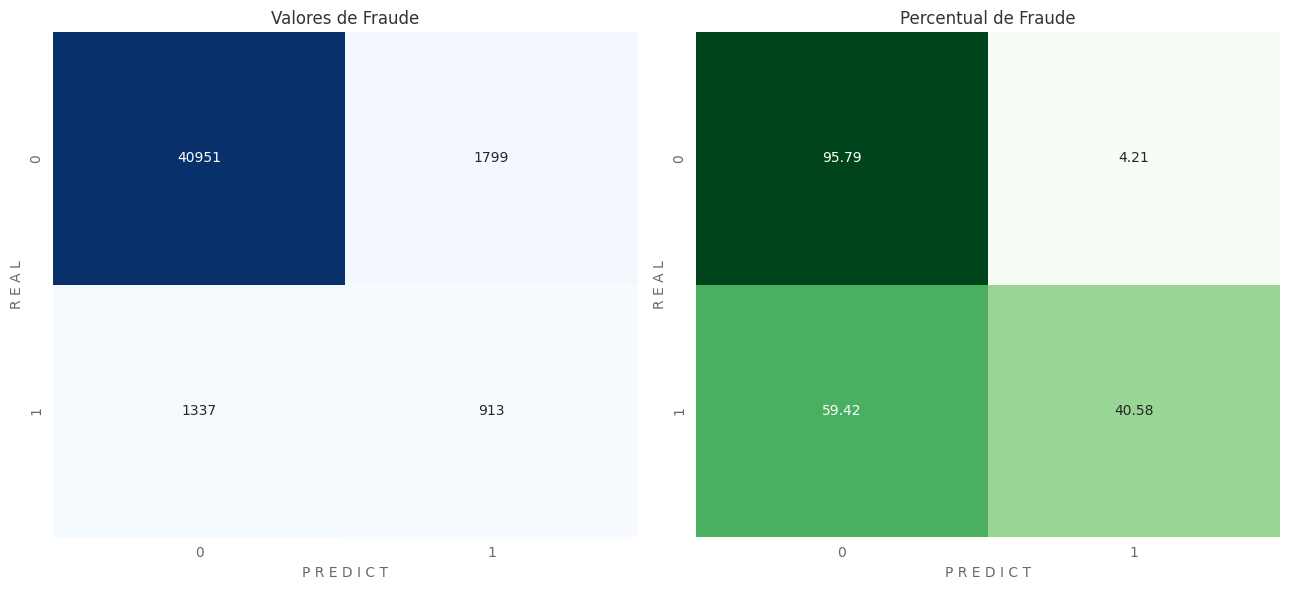

=> DEBUG: Plotagem da matriz de confusão concluída para threshold 0.50.
=> DEBUG: Aplicando plot_roc_auc_curve para o modelo: XGBoostClassifier


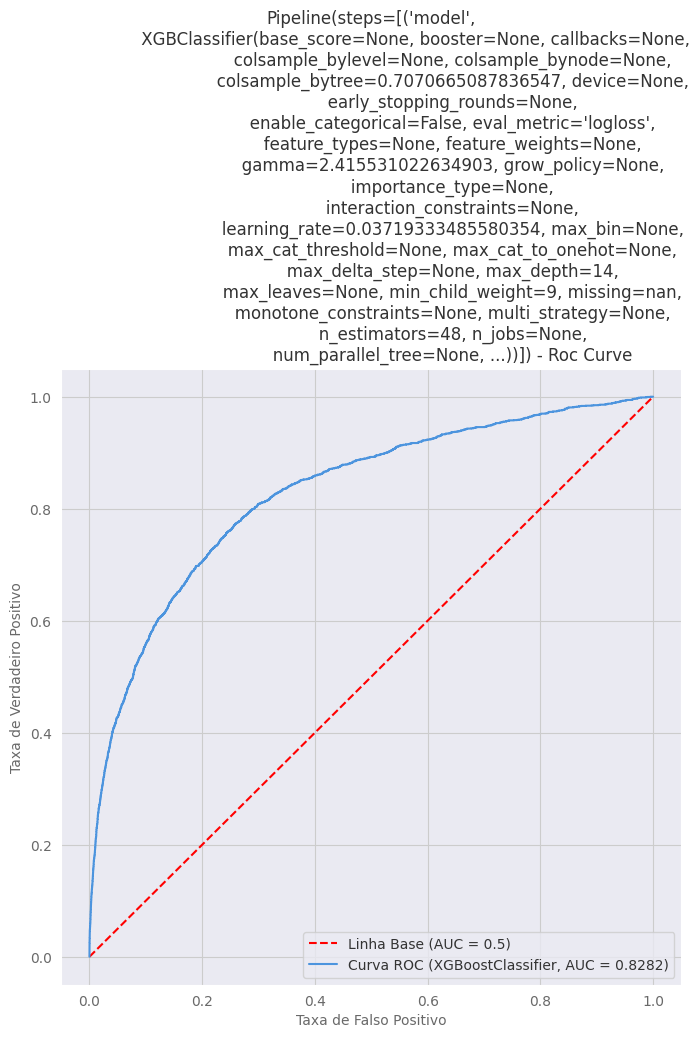

ROC AUC Score: 0.8282045484080571

=> DEBUG: Aplicando plot_roc_auc_curve para o modelo: XGBoostClassifier


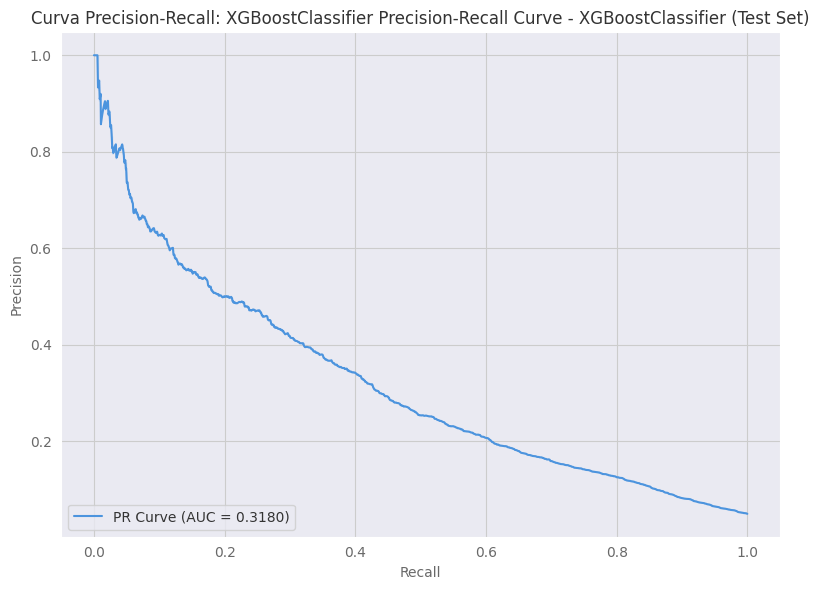

Precision-Recall AUC Score: 0.31800870667965503

  Métricas e plots do modelo XGBoostClassifier no conjunto de teste logados no MLflow.
Avaliação final do modelo XGBoostClassifier concluída.

--------------------------------------------------
Pipeline de ML concluído. Verifique o MLflow UI para os resultados detalhados.
--------------------------------------------------


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  #=> NÃO RODAR ESTA CÉLULA, PROCESSO DE TREINAMENTO LONGO <=

  # Lista dos modelos para rodar no pipeline

  models_to_test = [
          "LogisticRegression",
          "RandomForestClassifier",
          "XGBoostClassifier",
          "LightGBMClassifier"
          ]


  # Execute o pipeline

  pipeline_with_bayes_search(X_val_train, y_val_train, X_test, y_test, models_to_test)

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


## Etapa 5B - Definindo Modelos de Redes Neurais

In [ ]:
# Implementando métrica f1 score personalizada com o melhor threshold

@register_keras_serializable(package="MyCustomMetrics")
class F1Score(keras.metrics.Metric):

  def __init__(self, name= 'f1_score', threshold= 0.5, **kwargs):
    super().__init__(name= name, **kwargs)
    self.true_positives= self.add_weight(name= 'tp', initializer= 'zeros')
    self.false_positives= self.add_weight(name= 'fp', initializer= 'zeros')
    self.false_negatives= self.add_weight(name= 'fn', initializer= 'zeros')
    self.threshold= threshold


  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Binariza a previsão com o threshold
    y_pred_binary = tf.cast(y_pred >= self.threshold, tf.float32)

    true_pos = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred_binary, 1)), tf.float32))
    false_pos = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred_binary, 1)), tf.float32))
    false_neg = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred_binary, 0)), tf.float32))

    self.true_positives.assign_add(true_pos)
    self.false_positives.assign_add(false_pos)
    self.false_negatives.assign_add(false_neg)


  def result(self):
    precision = self.true_positives / (self.true_positives + self.false_positives + keras.backend.epsilon())
    recall = self.true_positives / (self.true_positives + self.false_negatives + keras.backend.epsilon())
    f1_score_result = 2 * precision * recall / (precision + recall + keras.backend.epsilon())

    return f1_score_result

  def reset_state(self):
    self.true_positives.assign(0)
    self.false_positives.assign(0)
    self.false_negatives.assign(0)

  def get_config(self):
      config = super().get_config()
      config.update({"threshold": self.threshold})
      return config


In [ ]:
# Class_weight parâmetro para todos os modelos

# Use the original 1D y_train for bincount
not_fraud_count, fraud_count = np.bincount(y_train.astype(int))
total_count = not_fraud_count + fraud_count

# Calculate class weights using the original counts
weight_for_not_fraud = (1.0 / not_fraud_count) * total_count / 2.0
weight_for_fraud = (1.0 / fraud_count) * total_count / 2.0 # Corrected calculation for fraud weight


class_weight = {0: weight_for_not_fraud, 1: weight_for_fraud}

print(class_weight)



{0: np.float64(0.5263126857574185), 1: np.float64(10.001120573733752)}


### Keras modelo 1

In [ ]:
# Definindo uma função build model para otimizar o modelo keras

def build_model1(hp):

  output_bias = tf.keras.initializers.Constant(np.log([fraud_count / not_fraud_count]))

  dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)

  model = keras.Sequential()
  model.add(layers.Input(shape=(X_train.shape[1],)))

  hp_units_layer1 = hp.Int('units_layer1', min_value= 32, max_value= 256, step= 32)
  model.add(layers.Dense(units= hp_units_layer1, activation= 'relu'))

  if dropout_rate > 0.0:
    model.add(layers.Dropout(dropout_rate))

  if hp.Boolean('add_second_layer'):
    hp_units_layer2 = hp.Int('units_layer2', min_value= 32, max_value= 256, step= 32)
    model.add(layers.Dense(units= hp_units_layer2, activation= 'relu'))

    if dropout_rate > 0.0:
      model.add(layers.Dropout(dropout_rate))

  model.add(layers.Dense(1, activation= 'sigmoid',  bias_initializer= output_bias))

  hp_learning_rate = hp.Choice('learning_rate', values= [1e-3, 1e-4])

  model.compile(
      optimizer = keras.optimizers. Adam(learning_rate = hp_learning_rate),
      loss= 'binary_crossentropy',
      metrics=[ keras.metrics.Precision(name= 'precision'),
        keras.metrics.Recall(name = 'recall'),
        keras.metrics.AUC(name= 'auc'),
        keras.metrics.AUC(name= 'prc', curve= 'PR'),
        F1Score(threshold=0.5, name='f1_score')]
  )

  return model

In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Instanciando Tuner => NÃO RODAR ESTA CÉLULA, PROCESSO DE TREINAMENTO LONGO <=

  tuner = kt.Hyperband(
      build_model1,
      objective= kt.Objective('val_f1_score', direction= 'max'),
      max_epochs= 30,
      factor= 2,
      directory= 'keras_tuner_modelo1_dir',
      project_name= 'fraud_detection_modelo1_tuning'
  )

  early_stopping_callback = EarlyStopping(
      monitor='val_f1_score',
      mode='max',
      patience=5,
      min_delta=0.001,
      restore_best_weights=True
  )

  # Fazendo busca dos hiperparametros com keras tuner
  print("Iniciando busca com Keras Tuner...")
  tuner.search(
      X_train, y_train,
      epochs= 15,
      validation_data= (X_val, y_val),
      class_weight= class_weight,
      callbacks=[early_stopping_callback]
  )


  # Obter os melhores resultados
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

  print(f"\nMelhores Hiperparâmetros encontrados:")
  print(f"  Units na 1ª camada: {best_hps.get('units_layer1')}")
  print(f"  Adicionar 2ª camada: {best_hps.get('add_second_layer')}")
  if best_hps.get('add_second_layer'):
      print(f"  Units na 2ª camada: {best_hps.get('units_layer2')}")
  print(f"  Taxa de aprendizado: {best_hps.get('learning_rate')}")

  # Obter o melhor modelo
  best_model = tuner.get_best_models(num_models=1)[0]

  # Evaluate the best model on the test data (using preprocessed test data)
  print("\nAvaliação do melhor modelo no conjunto de Teste:")
  test_loss, test_precision, test_recall, test_auc, test_prc, test_f1_score = best_model.evaluate(X_test, y_test, verbose=0)

  print(f"  Test Loss: {test_loss:.4f}")
  print(f"  Test Precision: {test_precision:.4f}")
  print(f"  Test Recall: {test_recall:.4f}")
  print(f"  Test AUC (ROC): {test_auc:.4f}")
  print(f"  Test PRC (AUPRC): {test_prc:.4f}")
  print(f"  Test F1-Score: {test_f1_score:.4f}")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Copiando diretório do Keras Tuner para google drive

  # Diretório raiz do Keras Tuner
  keras_tuner_output_dir = 'keras_tuner_modelo1_dir'

  destination_path_in_drive = '/content/drive/My Drive/Keras_Tuner_Results_Modelo1/' + os.path.basename(keras_tuner_output_dir)

  print(f"Copiando o diretório '{keras_tuner_output_dir}' para '{destination_path_in_drive}'...")

  # Copia o diretório inteiro
  if os.path.exists(destination_path_in_drive):
      print(f"Diretório de destino '{destination_path_in_drive}' já existe. Removendo...")
      shutil.rmtree(destination_path_in_drive) # Remove o diretório existente se já existir

  shutil.copytree(keras_tuner_output_dir, destination_path_in_drive)

  print(f"Cópia concluída para o Google Drive: '{destination_path_in_drive}'")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")


  # Recuperado os modelos testados que estão armazenados no google drive

  # Caminho para o diretório onde o Keras Tuner salvou os resultados

  tuner_modelo1_dir = '/content/drive/My Drive/Keras_Tuner_Results_Modelo1/keras_tuner_modelo1_dir'
  project_name_modelo1 = 'fraud_detection_modelo1_tuning'

  tuner = kt.Hyperband(
      build_model1,
      objective= kt.Objective('val_f1_score', direction= 'max'),
      max_epochs= 30,
      factor= 2,
      directory= tuner_modelo1_dir,
      project_name= project_name_modelo1
  )

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  best_hp_1 = tuner.get_best_hyperparameters(num_trials=1)[0]

  hp_model_1 = build_model1(best_hp_1)

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Retreinando o modelo keras com os melhores parâmetros => NÃO RODAR ESTA CÉLULA, PROCESSO DE TREINAMENTO LONGO <=

  # Obter os melhores hiperparâmetros do tuner
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

  # Construir o modelo com os melhores hiperparâmetros
  best_model = build_model1(best_hps)

  early_stopping_callback = EarlyStopping(
    monitor='val_f1_score',
    mode='max',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
  )

  # Treinar o modelo com os melhores hiperparâmetros e capturar o histórico
  print("Treinando o melhor modelo com os hiperparâmetros ideais\n")

  history_best_model = best_model.fit(
      X_train, y_train,
      epochs=50,
      validation_data=(X_val, y_val),
      class_weight=class_weight,
      callbacks=[early_stopping_callback],
      verbose=1
  )

  print("Histórico de treinamento do melhor modelo:")
  print(history_best_model.history.keys())

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
# Plotando histórico de treinamento e validação por epochs

def plot_learning_curves (history_object, title_prefix= "Melhor Modelo"):

  metrics_to_plot = [
    ('loss', "Loss"),
    ('precision', "Precision"),
    ('recall', "Recall"),
    ('auc', "Area under ROC curve"),
    ('prc', "Area under PR curve")
   ]

  fig = make_subplots(
    rows=len(metrics_to_plot),
    cols=1,
    subplot_titles= [name for _,name in metrics_to_plot],
    vertical_spacing= 0.085
    )


  training_color = 'blue'
  validation_color= 'red'

  for i, (metric_key, metric_name) in enumerate(metrics_to_plot):
    epochs = history_object.epoch

    # Adiciona a curva de treinamento
    fig.add_trace(go.Scatter(
        x= epochs,
        y= history_object.history[metric_key],
        mode= 'lines',
        name= f'Treinamento: {metric_name}',
        showlegend= True if i == 0 else False,
        line=dict(color=training_color)),
      row= i + 1, col= 1)

    # Adiciona a curva de validação
    fig.add_trace(go.Scatter(
          x= epochs,
          y= history_object.history[f"val_{metric_key}"],
          mode= "lines",
          line= {"dash": "dash","color": validation_color},
          name= f'Validação: {metric_name}',
          showlegend= True if i == 0 else False),
      row= i + 1, col= 1)

    fig.update_yaxes(title_text= metric_name, row= i+1, col= 1)

    if i ==len(metrics_to_plot) -1:
      fig.update_xaxes(title_text= 'Epoch', row= i+1, col= 1)
    else:
      fig.update_xaxes(showticklabels= True, row= i+1, col= 1)


    fig.update_layout(height= 250 * len(metrics_to_plot),
                    title_text= 'Histórico de Treinamento',
                    title_x= 0.5,
                    margin= {'b': 50, 't': 50},
                    hovermode= 'x unified')

  fig.show()



In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Aplicando função

  plot_learning_curves(history_best_model, title_prefix="Melhor Modelo Retreinado")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


###Keras modelo 2

In [ ]:
# Definindo uma função build model para otimizar o modelo keras

def build_model2(hp):

  output_bias = tf.keras.initializers.Constant(np.log([fraud_count / not_fraud_count]))

  dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)

  model = keras.Sequential()
  model.add(layers.Input(shape=(X_train.shape[1],)))

  hp_units_layer1 = hp.Int('units_layer1', min_value= 32, max_value= 256, step= 32)
  model.add(layers.Dense(units= hp_units_layer1, activation= 'relu'))

  if dropout_rate > 0.0:
    model.add(layers.Dropout(dropout_rate))

  if hp.Boolean('add_second_layer'):
    hp_units_layer2 = hp.Int('units_layer2', min_value= 32, max_value= 256, step= 32)
    model.add(layers.Dense(units= hp_units_layer2, activation= 'relu'))

    if dropout_rate > 0.0:
      model.add(layers.Dropout(dropout_rate))

  if hp.Boolean('add_third_layer'):
    hp_units_layer3 = hp.Int('units_layer3', min_value= 32, max_value= 256, step= 32)
    model.add(layers.Dense(units= hp_units_layer3, activation= 'relu'))

    if dropout_rate > 0.0:
      model.add(layers.Dropout(dropout_rate))

  model.add(layers.Dense(1, activation= 'sigmoid',  bias_initializer= output_bias))

  hp_learning_rate = hp.Choice('learning_rate', values= [1e-3, 1e-4])

  model.compile(
      optimizer = keras.optimizers. Adam(learning_rate = hp_learning_rate),
      loss= 'binary_crossentropy',
      metrics=[ keras.metrics.Precision(name= 'precision'),
        keras.metrics.Recall(name = 'recall'),
        keras.metrics.AUC(name= 'auc'),
        keras.metrics.AUC(name= 'prc', curve= 'PR'),
        F1Score(threshold=0.5, name='f1_score')]
  )

  return model


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Instanciando Tuner => NÃO RODAR ESTA CÉLULA, PROCESSO DE TREINAMENTO LONGO <=

  tuner = kt.Hyperband(
      build_model2,
      objective= kt.Objective('val_f1_score', direction= 'max'),
      max_epochs= 30,
      factor= 2,
      directory= 'keras_tuner_modelo2_dir',
      project_name= 'fraud_detection_model2_tuning'
  )

  early_stopping_callback = EarlyStopping(
      monitor='val_f1_score',
      mode='max',
      patience=5,
      min_delta=0.001,
      restore_best_weights=True
  )

  # Fazendo busca dos hiperparametros com keras tuner
  print("Iniciando busca com Keras Tuner...")
  tuner.search(
      X_train, y_train,
      epochs= 15,
      validation_data= (X_val, y_val),
      class_weight= class_weight,
      callbacks=[early_stopping_callback]
  )


  # Obter os melhores resultados
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

  print(f"\nMelhores Hiperparâmetros encontrados:")
  print(f"  Units na 1ª camada: {best_hps.get('units_layer1')}")
  print(f"  Adicionar 2ª camada: {best_hps.get('add_second_layer')}")
  if best_hps.get('add_second_layer'):
    print(f"  Units na 2ª camada: {best_hps.get('units_layer2')}")
  print(f"  Taxa de aprendizado: {best_hps.get('learning_rate')}")

  # Obter o melhor modelo
  best_model = tuner.get_best_models(num_models=1)[0]

  # Evaluate the best model on the test data (using preprocessed test data)
  print("\nAvaliação do melhor modelo no conjunto de Teste:")
  test_loss, test_precision, test_recall, test_auc, test_prc, test_f1_score = best_model.evaluate(X_test, y_test, verbose=0)

  print(f"  Test Loss: {test_loss:.4f}")
  print(f"  Test Precision: {test_precision:.4f}")
  print(f"  Test Recall: {test_recall:.4f}")
  print(f"  Test AUC (ROC): {test_auc:.4f}")
  print(f"  Test PRC (AUPRC): {test_prc:.4f}")
  print(f"  Test F1-Score: {test_f1_score:.4f}")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Copiando diretório do Keras Tuner para google drive

  # Diretório raiz do Keras Tuner
  keras_tuner_output_dir = 'keras_tuner_modelo2_dir'

  destination_path_in_drive = '/content/drive/My Drive/Keras_Tuner_Results_Modelo2/' + os.path.basename(keras_tuner_output_dir)

  print(f"Copiando o diretório '{keras_tuner_output_dir}' para '{destination_path_in_drive}'...")

  # Copia o diretório inteiro
  if os.path.exists(destination_path_in_drive):
      print(f"Diretório de destino '{destination_path_in_drive}' já existe. Removendo...")
      shutil.rmtree(destination_path_in_drive) # Remove o diretório existente se já existir

  shutil.copytree(keras_tuner_output_dir, destination_path_in_drive)

  print(f"Cópia concluída para o Google Drive: '{destination_path_in_drive}'")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Recuperado os modelos testados que estão armazenados no google drive

  # Caminho para o diretório onde o Keras Tuner salvou os resultados

  tuner_modelo2_dir = '/content/drive/My Drive/Keras_Tuner_Results_Modelo2/keras_tuner_modelo2_dir'
  project_name_modelo2 = 'fraud_detection_model2_tuning'

  # Re-instanciar o Tuner 2
  tuner = kt.Hyperband(
      build_model2,
      objective=kt.Objective('val_f1_score', direction='max'),
      max_epochs=30,
      factor=2,
      directory= tuner_modelo2_dir,
      project_name=project_name_modelo2
  )

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  best_hp_2 = tuner.get_best_hyperparameters(num_trials=1)[0]

  hp_model_2 = build_model2(best_hp_2)

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Retreinando o modelo keras com os melhores parâmetros => NÃO RODAR ESTA CÉLULA, PROCESSO DE TREINAMENTO LONGO <=

  # Obter os melhores hiperparâmetros do tuner
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

  # Construir o modelo com os melhores hiperparâmetros
  best_model = build_model2(best_hps)

  early_stopping_callback = EarlyStopping(
    monitor='val_f1_score',
    mode='max',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
  )

  # Treinar o modelo com os melhores hiperparâmetros e capturar o histórico
  print("Treinando o melhor modelo com os hiperparâmetros ideais\n")

  history_best_model = best_model.fit(
      X_train, y_train,
      epochs=50,
      validation_data=(X_val, y_val),
      class_weight=class_weight,
      callbacks=[early_stopping_callback],
      verbose=1
  )

  print("Histórico de treinamento do melhor modelo:")
  print(history_best_model.history.keys())

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")


  # Plotando histórico de treinamento e validação por epochs

  plot_learning_curves(history_best_model, title_prefix="Melhor Modelo Retreinado")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


###Keras modelo 3

In [ ]:
# Mais uma possível arquitetura de rede neural

def build_model3(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))

    # Definir a função de ativação como um hiperparâmetro
    activation_choice = hp.Choice('activation', values=['relu', 'tanh', 'elu'])

    # Hiperparâmetro para o número de unidades em cada camada densa
    hp_units_layer = hp.Int('units_layer', min_value=32, max_value=256, step=32, default=128)

    # Primeira camada Dense
    model.add(layers.Dense(units=hp_units_layer, activation=activation_choice))

    # Primeira camada Dropout com taxa ajustável
    dropout_rate_1 = hp.Float('dropout_rate_1', min_value=0.1, max_value=0.5, step=0.1, default=0.3)
    model.add(layers.Dropout(dropout_rate_1))

    # Segunda camada Dense
    model.add(layers.Dense(units=hp_units_layer, activation=activation_choice))

    # Segunda camada Dropout com taxa ajustável
    dropout_rate_2 = hp.Float('dropout_rate_2', min_value=0.1, max_value=0.5, step=0.1, default=0.3)
    model.add(layers.Dropout(dropout_rate_2))

    # Camada de saída
    output_bias = tf.keras.initializers.Constant(np.log([fraud_count / not_fraud_count])) # Ensure output_bias is defined

    model.add(layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))

    # Otimizador e Taxa de Aprendizagem como hiperparâmetros
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    hp_learning_rate = hp.Choice('learning_rate', values= [1e-3, 1e-4])

    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate= hp_learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate= hp_learning_rate)
    else: # sgd
        optimizer = tf.keras.optimizers.SGD(learning_rate= hp_learning_rate, momentum=0.9) # Adicione momentum para SGD

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[
                      'accuracy',
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall'),
                      tf.keras.metrics.AUC(name='auc'), # Add AUC for ROC
                      tf.keras.metrics.AUC(name='prc', curve='PR'), # Add AUC for PR
                      tf.keras.metrics.F1Score(average='macro', threshold=0.5, name='f1_score')
                  ])
    return model


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Instanciando Tuner => NÃO RODAR ESTA CÉLULA, PROCESSO DE TREINAMENTO LONGO <=

  tuner = kt.Hyperband(
      build_model3,
      objective= kt.Objective('val_f1_score', direction= 'max'),
      max_epochs= 30,
      factor= 2,
      directory= 'keras_tuner_modelo3_dir',
      project_name= 'fraud_detection_modelo3_tuning'
  )

  early_stopping_callback = EarlyStopping(
      monitor='val_f1_score',
      mode='max',
      patience=5,
      min_delta=0.001,
      restore_best_weights=True
  )

  # Fazendo busca dos hiperparametros com keras tuner
  print("Iniciando busca com Keras Tuner...")
  tuner.search(
      X_train, y_train,
      epochs= 15,
      validation_data= (X_val, y_val),
      class_weight= class_weight,
      callbacks=[early_stopping_callback]
  )

  # Obter os melhores resultados
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

  print("\n Melhores Hiperparâmetros para a Arquitetura Fixa")


  # Print the hyperparameters defined in build_tunable_fixed_arch_model
  print(f"  Activation: {best_hps.get('activation')}")
  # Conditionally print leaky_relu_alpha if activation is leaky_relu
  if best_hps.get('activation') == 'leaky_relu':
      # Ensure these hyperparameters are actually defined in build_tunable_fixed_arch_model
      # Based on the function, they are defined conditionally
      print(f"  LeakyReLU Alpha (Layer 1): {best_hps.get('leaky_relu_alpha')}")
      print(f"  LeakyReLU Alpha (Layer 2): {best_hps.get('leaky_relu_alpha_2')}")
  print(f"  Dropout Rate (Layer 1): {best_hps.get('dropout_rate_1')}")
  print(f"  Dropout Rate (Layer 2): {best_hps.get('dropout_rate_2')}")
  print(f"  Optimizer: {best_hps.get('optimizer')}")
  print(f"  Learning Rate: {best_hps.get('learning_rate')}")


  # Obter o melhor modelo
  best_model = tuner.get_best_models(num_models=1)[0]

  # Evaluate the best model on the test data (using preprocessed test data)
  print("\nAvaliação do melhor modelo no conjunto de Teste:")
  # Include accuracy in the unpacked values (expecting loss + 6 metrics = 7 values)
  test_loss, test_accuracy, test_precision, test_recall, test_auc, test_prc, test_f1_score = best_model.evaluate(X_test, y_test, verbose=0)

  print(f"  Test Loss: {test_loss:.4f}")
  print(f"  Test Accuracy: {test_accuracy:.4f}") # Print Accuracy
  print(f"  Test Precision: {test_precision:.4f}")
  print(f"  Test Recall: {test_recall:.4f}")
  print(f"  Test AUC (ROC): {test_auc:.4f}")
  print(f"  Test PRC (AUPRC): {test_prc:.4f}")
  print(f"  Test F1-Score: {test_f1_score:.4f}")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  print(f"\n--- Resumo dos Trials para {tuner.project_name} ---")
  tuner.results_summary(num_trials=5) # Mostra os 5 melhores trials

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Copiando diretório do Keras Tuner para google drive

  # Diretório raiz do Keras Tuner
  keras_tuner_output_dir = 'keras_tuner_modelo3_dir'

  destination_path_in_drive = '/content/drive/My Drive/Keras_Tuner_Results_Modelo3/' + os.path.basename(keras_tuner_output_dir)

  print(f"Copiando o diretório '{keras_tuner_output_dir}' para '{destination_path_in_drive}'...")

  # Copia o diretório inteiro
  if os.path.exists(destination_path_in_drive):
      print(f"Diretório de destino '{destination_path_in_drive}' já existe. Removendo...")
      shutil.rmtree(destination_path_in_drive) # Remove o diretório existente

  shutil.copytree(keras_tuner_output_dir, destination_path_in_drive)

  print(f"Cópia concluída para o Google Drive: '{destination_path_in_drive}'")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Recuperando os modelos testados que estão armazenados no google drive

  # Caminho para o diretório onde o Keras Tuner salvou os resultados

  tuner_modelo3_dir = '/content/drive/My Drive/Keras_Tuner_Results_Modelo3/keras_tuner_modelo3_dir'
  project_name_modelo3 = 'fraud_detection_modelo3_tuning'

  # Re-instanciar o Tuner 3
  tuner = kt.Hyperband(
      build_model3,
      objective=kt.Objective('val_f1_score', direction='max'),
      max_epochs=30,
      factor=3,
      directory= tuner_modelo3_dir,
      project_name=project_name_modelo3
  )

  best_trials_3 = tuner.oracle.get_best_trials(2)
  best_trials_3

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
 if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  best_hp_3 = tuner.get_best_hyperparameters(num_trials=1)[0]

  hp_model_3 = build_model3(best_hp_3)

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Retreinando o modelo keras com os melhores parâmetros => NÃO RODAR ESTA CÉLULA, PROCESSO DE TREINAMENTO LONGO <=

  # Obter os melhores hiperparâmetros do tuner
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

  # Construir o modelo com os melhores hiperparâmetros
  best_model = build_model3(best_hps)

  early_stopping_callback = EarlyStopping(
    monitor='val_f1_score',
    mode='max',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
  )

  # Treinar o modelo com os melhores hiperparâmetros e capturar o histórico
  print("Treinando o melhor modelo com os hiperparâmetros ideais\n")

  history_best_model = best_model.fit(
      X_train, y_train,
      epochs=50,
      validation_data=(X_val, y_val),
      class_weight=class_weight,
      callbacks=[early_stopping_callback],
      verbose=1
  )

  print("Histórico de treinamento do melhor modelo:")
  print(history_best_model.history.keys())

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Plotando histórico de treinamento e validação por epochs

  plot_learning_curves(history_best_model, title_prefix="Melhor Modelo Retreinado")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


###Keras modelo 4

In [ ]:
# Keras
# Função a ser minimizada é binary cross entropy, padrão em problemas de redes neurais envolvendo problemas de classificação

# Batch size: 64
# Epochs: 40
# Number of hidden layers: 2
# Nodes per hidden layer: 500
# Probability of dropout layer: 0.2
# Learning rate: 0.001

def build_model4(hp):

  output_bias = tf.keras.initializers.Constant(np.log([fraud_count / not_fraud_count]))

  model = keras.Sequential()

  model.add(layers.Input(shape=(X_train.shape[1],))) # Camada de Input explícita

  # Primeira Camada Densa
  hp_units_layer1 = hp.Int('units_layer1', min_value=50, max_value=500, step=50, default=250)
  # Escolha da função de ativação
  model.add(layers.Dense(units=hp_units_layer1, activation='relu'))
  # Taxa de Dropout como hiperparâmetro
  dropout_rate1 = hp.Float('dropout_rate1', min_value=0.1, max_value=0.5, step=0.1, default=0.2)
  model.add(layers.Dropout(dropout_rate1))

  #Segunda Camada Densa (Opcional)
  hp_units_layer2 = hp.Int('units_layer2', min_value=50, max_value=500, step=50, default=250)
  model.add(layers.Dense(units=hp_units_layer2, activation='relu'))
  # Taxa de Dropout como hiperparâmetro
  dropout_rate2 = hp.Float('dropout_rate2', min_value=0.1, max_value=0.5, step=0.1, default=0.2)
  model.add(layers.Dropout(dropout_rate2))

  # Terceira Camada Densa (Opcional, aninhada na segunda camada)
  hp_units_layer3 = hp.Int('units_layer3', min_value=50, max_value=500, step=50, default=250)
  model.add(layers.Dense(units=hp_units_layer3, activation='relu'))
  # Taxa de Dropout como hiperparâmetro
  dropout_rate3 = hp.Float('dropout_rate3', min_value=0.1, max_value=0.5, step=0.1, default=0.2)
  model.add(layers.Dropout(dropout_rate3))

  # Camada de Saída
  model.add(layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))

  # Otimizador e Taxa de Aprendizado como hiperparâmetro
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
  optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)

  model.compile(
      optimizer=optimizer,
      loss='binary_crossentropy',
      metrics=[
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
          keras.metrics.AUC(name='prc', curve='PR'),
          F1Score(threshold=0.5, name='f1_score')
      ]
  )
  return model


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Instanciando Tuner => NÃO RODAR ESTA CÉLULA, PROCESSO DE TREINAMENTO LONGO <=

  tuner = kt.Hyperband( # Corrected variable name
      build_model4,
      objective= kt.Objective('val_f1_score', direction= 'max'),
      max_epochs= 30,
      factor= 2,
      directory= 'keras_tuner_modelo4_dir',
      project_name= 'fraud_detection_modelo4_tuning'
  )

  early_stopping_callback = EarlyStopping(
      monitor='val_f1_score',
      mode='max',
      patience=5,
      min_delta=0.001,
      restore_best_weights=True
  )

  # Fazendo busca dos hiperparametros com keras tuner
  print("Iniciando busca com Keras Tuner...")
  tuner.search(
      X_train, y_train,
      epochs= 15,
      validation_data= (X_val, y_val),
      class_weight= class_weight,
      callbacks=[early_stopping_callback]
  )

  # Obter os melhores resultados
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

  print("\n Melhores Hiperparâmetros para a Arquitetura Fixa")

  # Print the hyperparameters defined in build_tunable_fixed_arch_model
  print(f"  Dropout Rate (Layer 1): {best_hps.get('dropout_rate1')}")
  print(f"  Dropout Rate (Layer 2): {best_hps.get('dropout_rate2')}")
  print(f"  Dropout Rate (Layer 3): {best_hps.get('dropout_rate3')}")
  print(f"  Optimizer: {best_hps.get('optimizer')}")
  print(f"  Learning Rate: {best_hps.get('learning_rate')}")

  # Obter o melhor modelo
  best_model = tuner.get_best_models(num_models=1)[0]

  # Evaluate the best model on the test data (using preprocessed test data)
  print("\nAvaliação do melhor modelo no conjunto de Teste:")
  # Include accuracy in the unpacked values (expecting loss + 6 metrics = 7 values)
  test_loss, test_accuracy, test_precision, test_recall, test_auc, test_prc, test_f1_score = best_model.evaluate(X_test, y_test, verbose=0)

  print(f"  Test Loss: {test_loss:.4f}")
  print(f"  Test Accuracy: {test_accuracy:.4f}") # Print Accuracy
  print(f"  Test Precision: {test_precision:.4f}")
  print(f"  Test Recall: {test_recall:.4f}")
  print(f"  Test AUC (ROC): {test_auc:.4f}")
  print(f"  Test PRC (AUPRC): {test_prc:.4f}")
  print(f"  Test F1-Score: {test_f1_score:.4f}")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Copiando diretório do Keras Tuner para google drive

  # Diretório raiz do Keras Tuner
  keras_tuner_output_dir = 'keras_tuner_modelo4_dir'

  destination_path_in_drive = '/content/drive/My Drive/Keras_Tuner_Results_Modelo4/' + os.path.basename(keras_tuner_output_dir)

  print(f"Copiando o diretório '{keras_tuner_output_dir}' para '{destination_path_in_drive}'...")

  # Copia o diretório inteiro
  if os.path.exists(destination_path_in_drive):
      print(f"Diretório de destino '{destination_path_in_drive}' já existe. Removendo...")
      shutil.rmtree(destination_path_in_drive) # Remove o diretório existente

  shutil.copytree(keras_tuner_output_dir, destination_path_in_drive)

  print(f"Cópia concluída para o Google Drive: '{destination_path_in_drive}'")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Recuperando os modelos testados que estão armazenados no google drive

  # Caminho para o diretório onde o Keras Tuner salvou os resultados

  tuner_modelo4_dir = '/content/drive/My Drive/Keras_Tuner_Results_Modelo4/keras_tuner_modelo4_dir'
  project_name_modelo4 = 'fraud_detection_modelo4_tuning'

  # Re-instanciar o Tuner 4
  tuner = kt.Hyperband(
      build_model4,
      objective=kt.Objective('val_f1_score', direction='max'),
      max_epochs=30,
      factor=3,
      directory= tuner_modelo4_dir,
      project_name=project_name_modelo4
  )

  best_trials_4 = tuner.oracle.get_best_trials(2)
  best_trials_4

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")


  best_hp_4 = tuner.get_best_hyperparameters(num_trials=1)[0]

  hp_model_4 = build_model4(best_hp_4)

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Retreinando o modelo keras com os melhores parâmetros => NÃO RODAR ESTA CÉLULA, PROCESSO DE TREINAMENTO LONGO <=

  # Obter os melhores hiperparâmetros do tuner
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

  # Construir o modelo com os melhores hiperparâmetros
  best_model = build_model4(best_hps)

  early_stopping_callback = EarlyStopping(
    monitor='val_f1_score',
    mode='max',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
  )

  # Treinar o modelo com os melhores hiperparâmetros e capturar o histórico
  print("Treinando o melhor modelo com os hiperparâmetros ideais\n")

  history_best_model = best_model.fit(
      X_train, y_train,
      epochs=50,
      validation_data=(X_val, y_val),
      class_weight=class_weight,
      callbacks=[early_stopping_callback],
      verbose=1
  )

  print("Histórico de treinamento do melhor modelo:")
  print(history_best_model.history.keys())

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Plotando histórico de treinamento e validação por epochs

  plot_learning_curves(history_best_model, title_prefix="Melhor Modelo Retreinado")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


### Usando cross validation e ML Flow para monitorar a consistência dos melhores modelos Keras

In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Criar experimento no ML Flow

  mlflow.set_experiment(experiment_name='Modelos_Fraude_Keras')

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Lista de tuners para cada modelo => NÃO RODAR ESTA CÉLULA, PROCESSO DE TREINAMENTO LONGO <=
  tuner_list = [
      kt.Hyperband(build_model1, objective=kt.Objective('val_f1_score', direction='max'), max_epochs=30, factor=2, directory='/content/drive/My Drive/Keras_Tuner_Results_Modelo1/keras_tuner_modelo1_dir', project_name='fraud_detection_modelo1_tuning'),
      kt.Hyperband(build_model2, objective=kt.Objective('val_f1_score', direction='max'), max_epochs=30, factor=2, directory='/content/drive/My Drive/Keras_Tuner_Results_Modelo2/keras_tuner_modelo2_dir', project_name='fraud_detection_model2_tuning'),
      kt.Hyperband(build_model3, objective=kt.Objective('val_f1_score', direction='max'), max_epochs=30, factor=3, directory='/content/drive/My Drive/Keras_Tuner_Results_Modelo3/keras_tuner_modelo3_dir', project_name='fraud_detection_modelo3_tuning'),
      kt.Hyperband(build_model4, objective=kt.Objective('val_f1_score', direction='max'), max_epochs=30, factor=3, directory='/content/drive/My Drive/Keras_Tuner_Results_Modelo4/keras_tuner_modelo4_dir', project_name='fraud_detection_modelo4_tuning')
  ]

  # Lista de build_models
  build_model_list = [build_model1, build_model2, build_model3, build_model4]

  # Definindo K-folds
  n_splits = 5

  k_folds_CV = KFold(n_splits= n_splits, shuffle= True, random_state= 71)

  for i, tuner in enumerate(tuner_list):
    model_name = f'Modelo Candidato_{i+1}'
    print(f'Iniciando Cross Validation para {model_name}')

    start_time_model_cv = time.time()

    CV_metrics = {
          'loss': [],
          'precision': [],
          'recall': [],
          'auc': [],
          'prc': [],
          'f1_score': [],
          'time_per_fold_seconds': []
          }

    # Iniciar ML Flow
    with mlflow.start_run(run_name= f'{model_name}_CV_run', nested=True):
      # Pega os best hyperparameters para cada modelo
      best_hp_model = tuner.get_best_hyperparameters(num_trials=1)[0]

      # Log ml flow
      for param, value in best_hp_model.values.items():
        mlflow.log_param(f'hp_{param}', value)

      # Iterar sobre K-fold
      for fold_idx, (train_index, val_index) in tqdm(enumerate(k_folds_CV.split(X_full, y_full)),
                                                    total=n_splits,
                                                    desc=f"CV Folds para {model_name}"):
        fold_number = fold_idx + 1

        start_time_fold = time.time() # Início da contagem de tempo para o fold

        # Split para cada fold
        X_train_fold_raw, X_val_fold_raw = X_full.iloc[train_index], X_full.iloc[val_index]
        y_train_fold, y_val_fold = y_full.iloc[train_index], y_full.iloc[val_index]

        # Aplicar pipeline de pré processamento em cada fold
        X_train_fold = pre_pipe.transform(X_train_fold_raw).astype('float32')
        X_val_fold = pre_pipe.transform(X_val_fold_raw).astype('float32')

        # Preparando shapes para keras (tudo em arrays numpy e float)
        y_train_fold = np.asarray(y_train_fold).astype('float32')
        y_train_fold = np.expand_dims(y_train_fold, axis=-1)
        y_val_fold = np.asarray(y_val_fold).astype('float32')
        y_val_fold = np.expand_dims(y_val_fold, axis=-1)

        # Aplica build model para cada best hp models
        build_current_model= build_model_list[i]
        model= build_current_model(best_hp_model)

        # Calcula class weights par o respectivo fold (pode ser diferente do global?)
        not_fraud_count_fold, fraud_count_fold = np.bincount(y_train_fold.flatten().astype(int))
        total_count_fold = not_fraud_count_fold + fraud_count_fold
        class_weight_fold = {
            0: (1.0 / not_fraud_count_fold) * total_count_fold / 2.0,
            1: (1.0 / fraud_count_fold) * total_count_fold / 2.0
        }

        # Treinamento do modelo
        history = model.fit(
                            X_train_fold, y_train_fold,
                            epochs= 30,
                            batch_size= 64,
                            verbose= 0,
                            class_weight= class_weight_fold # Use fold-specific class weights
                          )

        # Avaliação do modelo no fold de validação
        results = model.evaluate(X_val_fold, y_val_fold, verbose=0)

        mlflow.keras.log_model(model, artifact_path=f"model_fold_{fold_number}") # Loga com nome específico por fold

        end_time_fold = time.time() # Fim da contagem de tempo para o fold
        time_elapsed_fold = end_time_fold - start_time_fold

        # Lista das métrica a serem avaliadas
        metric_names = ['loss', 'precision', 'recall', 'auc', 'prc', 'f1_score']

        for i_metric, name in enumerate(metric_names):
          value = results[i_metric]
          CV_metrics[name].append(value)
          mlflow.log_metric(f"{name}_fold_{fold_number}", value)

        CV_metrics['time_per_fold_seconds'].append(time_elapsed_fold) # Acumula o tempo
        mlflow.log_metric(f"time_fold_{fold_number}_s", time_elapsed_fold) # Log do tempo do fold

      # Calcula e salva as médias e desvios padrão para cada métrica no ML Flow
      for metric_name, values in CV_metrics.items():
        if values:
          mean_value = np.mean(values)
          std_value = np.std(values)
          mlflow.log_metric(f"mean_{metric_name}", mean_value)
          mlflow.log_metric(f"std_{metric_name}", std_value)
        else:
          print(f"Sem valores para a métrica: {metric_name}")

      end_time_model_cv = time.time()
      total_time_model_cv = end_time_model_cv - start_time_model_cv
      mlflow.log_metric("total_cv_time_seconds", total_time_model_cv)

    print(f'Cross-Validation para {model_name} concluída. Resultados logados no MLflow \n')

  print("Processo de Cross-Validation completo")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


## Etapa 6 - Avaliando experimentos

### Experimento ML Flow Modelos de ML Clássicos

In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Acessar experimento no ml flow para os modelos clássicos
  # Nome do experimento
  experiment_name = "Modelo_Fraude_ML_Classico_CV_5_Refit"

  print(f"Tentando acessar o experimento: '{experiment_name}'")
  print(f"MLflow Tracking URI configurado: {mlflow.get_tracking_uri()}")

  experiment = mlflow.get_experiment_by_name(experiment_name)

  if experiment is None:
    print(f"Erro: Experimento '{experiment_name}' não encontrado no Tracking Server.")
    exit() # Sai do script se o experimento não for encontrado

  experiment_id = experiment.experiment_id
  print(f"Experimento '{experiment_name}' (ID: {experiment_id}) encontrado com sucesso.")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Executando bloco de treinamento
Tentando acessar o experimento: 'Modelo_Fraude_ML_Classico_CV_5_Refit'
MLflow Tracking URI configurado: file:///content/drive/MyDrive/Data Science/Puc Rio DS/04_Sprint Machine Learning/ML_Flow
Experimento 'Modelo_Fraude_ML_Classico_CV_5_Refit' (ID: 463805179950073857) encontrado com sucesso.


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Recuperar as métricas salvas nos experimentos para comparação dos modelos de ML clássicos => NÃO RODAR ESTA CÉLULA, PROCESSO DE TREINAMENTO LONGO <=

  # Busca os runs pai (pipelines completos)
  parent_runs = mlflow.search_runs(
      experiment_ids=[experiment_id],
      filter_string="tags.mlflow.runName LIKE 'Full_ML_Pipeline_Bayesian_Optimization'",
      order_by=["start_time DESC"]
  )
  print(f"Parent Runs encontrados dentro do experimento {experiment_id}")

  # Inicializa as listas para armazenar os dados recuperados
  model_comparison_data = []
  plot_data_roc_auc = []
  plot_data_f1 = []
  plot_data_precision = []
  plot_data_recall = []

  if not parent_runs.empty:
    for idx, parent_run_info in parent_runs.iterrows():
      parent_run_id = parent_run_info['run_id']

      # Busca os runs de otimização (Tuning_) filhos deste run pai
      tuning_filter = f"tags.mlflow.parentRunId = '{parent_run_id}' AND tags.mlflow.runName LIKE 'Tuning_%'"
      tuning_runs_direct_children = mlflow.search_runs(
          experiment_ids=[experiment_id],
          filter_string=tuning_filter,
          order_by=["start_time DESC"]
          ).copy()

      print(f"Runs de otimização encontrados e recuperados")

      if not tuning_runs_direct_children.empty:
        for _, tuning_run_info in tuning_runs_direct_children.iterrows():
          tuning_run_id = tuning_run_info['run_id']
          tuning_run_name = tuning_run_info['tags.mlflow.runName']
          model_name = tuning_run_info.get('params.model_type', 'UNKNOWN_MODEL')

          if model_name != "UNKNOWN_MODEL":
            print(f"  Processando modelo: {model_name} (Run Tuning ID: {tuning_run_id})")

            expected_eval_run_name = f'CV_Eval_{model_name}_Best%'

            # Busca o run de re-avaliação usando o nome do run e a tag mlflow.parentRun ID
            eval_filter = (
                f"tags.mlflow.runName LIKE 'CV_Eval_{model_name}_Best_ReEvaluated' " # Nome do run de avaliação
                f"AND tags.evaluation_type = 'Cross-Validation of Best Estimator (Re-Evaluated)' " # Tag confirmada
                f"AND tags.mlflow.parentRunId = '{tuning_run_id}'" # Usando o parentRunId do MLflow
                )

            evaluation_runs = mlflow.search_runs(
            experiment_ids= [experiment_id],
            filter_string= eval_filter,
            order_by= ["start_time DESC"],
            max_results= 1
            ).copy()

            if not evaluation_runs.empty:
              eval_run_id = evaluation_runs.iloc[0]['run_id']
              print(f"Run de avaliação encontrado para '{model_name}': ID = {eval_run_id}")
              eval_run = mlflow.get_run(eval_run_id)
              tuning_run = mlflow.get_run(tuning_run_id)

              # Calcula o prefixo para as métricas de teste do modelo (e.g., lightgbm_ para LightGBMClassifier)
              prefix = model_name.lower().replace('classifier', '') + '_' if 'classifier' in model_name.lower() else model_name.lower() + '_'

              # Coleta as métricas de comparação de alto nível
              metrics = {
                  "Model": model_name,
                  "Best Val ROC AUC (Bayes Search)": tuning_run.data.params.get("best_validation_roc_auc"),
                  "Mean CV ROC AUC": eval_run.data.metrics.get("mean_test_roc_auc"),
                  "Std CV ROC AUC": eval_run.data.metrics.get("std_test_roc_auc"),
                  "Mean CV F1-Score": eval_run.data.metrics.get("mean_test_f1"),
                  "Std CV F1-Score": eval_run.data.metrics.get("std_test_f1"),
                  "Mean CV Recall": eval_run.data.metrics.get("mean_test_recall"),
                  "Std CV Recall": eval_run.data.metrics.get("std_test_recall"),
                  "Mean CV Precision": eval_run.data.metrics.get("mean_test_precision"),
                  "Std CV Precision": eval_run.data.metrics.get("std_test_precision"),

                  "Test Accuracy": eval_run.data.metrics.get(f"{prefix}test_accuracy"),
                  "Test Recall": eval_run.data.metrics.get(f"{prefix}test_recall"),
                  "Test Precision": eval_run.data.metrics.get(f"{prefix}test_precision"),
                  "Test F1-Score": eval_run.data.metrics.get(f"{prefix}test_f1_score"),
                  "Test ROC AUC": eval_run.data.metrics.get(f"{prefix}test_roc_auc"),
                  "Test Log Loss": eval_run.data.metrics.get(f"{prefix}test_log_loss"),

                  "Total Optimization Duration (s)": tuning_run.data.metrics.get("bayes_search_fit_duration_seconds"),
                  "Total Evaluation Duration (s)": eval_run.data.metrics.get("total_model_cv_evaluation_duration_seconds")
              }
              print(f"Métricas calculadas")

              model_comparison_data.append(metrics)

              # Coleta os scores por fold para os box plots
              num_folds_tag = eval_run.data.tags.get('n_splits_cv_eval')
              num_folds = int(num_folds_tag) if num_folds_tag else 5

              for i in range(1, num_folds + 1):
                roc_auc_sco = eval_run.data.metrics.get(f"fold_{i}_test_roc_auc")
                if roc_auc_sco is not None:
                  plot_data_roc_auc.append({"Model": model_name, "ROC AUC Score": roc_auc_sco})

                f1_sco = eval_run.data.metrics.get(f"fold_{i}_test_f1")
                if f1_sco is not None:
                  plot_data_f1.append({"Model": model_name, "F1-Score": f1_sco})

                precision_sco = eval_run.data.metrics.get(f"fold_{i}_test_precision")
                if precision_sco is not None:
                  plot_data_precision.append({"Model": model_name, "Precision": precision_sco})

                recall_sco = eval_run.data.metrics.get(f"fold_{i}_test_recall")
                if recall_sco is not None:
                  plot_data_recall.append({"Model": model_name, "Recall": recall_sco})

  # Cria o DataFrame de comparação
  comparison_df_classicos = pd.DataFrame(model_comparison_data).sort_values(by="Test ROC AUC", ascending=False).reset_index(drop=True) if model_comparison_data else pd.DataFrame()

  print(f"Listas de métricas por CV run salvas")
  print("Recuperação de métricas concluída. O DataFrame 'comparison_df' e as listas 'plot_data_...' estão prontas para uso.")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Executando bloco de treinamento
Parent Runs encontrados dentro do experimento 463805179950073857
Runs de otimização encontrados e recuperados
  Processando modelo: LightGBMClassifier (Run Tuning ID: 04506498a84b43feaa52819d8d3528d5)
Run de avaliação encontrado para 'LightGBMClassifier': ID = 00a7ef758b7545398555a4ac4a5dcf49
Métricas calculadas
  Processando modelo: XGBoostClassifier (Run Tuning ID: 6022767bfa8f44acb044f03ea320206d)
Run de avaliação encontrado para 'XGBoostClassifier': ID = dbb8a28289594ea681e5d366b9c6470b
Métricas calculadas
  Processando modelo: RandomForestClassifier (Run Tuning ID: e80fece5281b42a690117e8947175351)
Run de avaliação encontrado para 'RandomForestClassifier': ID = 9cbe8dd1734045d686ee64a42ccc5b7f
Métricas calculadas
  Processando modelo: LogisticRegression (Run Tuning ID: 42ebc6feacde4eea94fc593ecc36fef4)
Run de avaliação encontrado para 'LogisticRegression': ID = a7c5702ccd664a6d8715715d682e81d5
Métricas calculadas
Runs de otimização encontrados e rec

In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Dataframe comparativo entre os modelos de ML clássicos => NÃO RODAR ESTA CÉLULA, PROCESSO DE TREINAMENTO LONGO <=

  print("\n" + "-" * 50)
  print("DataFrame de Comparação de Modelos:")

  display(comparison_df_classicos.round(4))

  comparison_df_classicos.to_csv("df_comparativo_scikitlearn", index= False)

  print("-" * 50)

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")

### Experimento ML Flow Modelos Redes Neurais

In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Recuperando métricas dos modelos Keras => NÃO RODAR ESTA CÉLULA, PROCESSO DE TREINAMENTO LONGO <=

  experiment_name='Modelos_Fraude_Keras'
  experiment = mlflow.get_experiment_by_name(experiment_name)

  client = mlflow.tracking.MlflowClient()

  # Listas para armazenar os dados
  model_comparison_data_keras = []

  # Para os box plots (métricas por fold)
  plot_data_loss_keras = []
  plot_data_precision_keras = []
  plot_data_recall_keras = []
  plot_data_auc_keras = []
  plot_data_prc_keras = []
  plot_data_f1_score_keras = []

  keras_experiment = client.get_experiment_by_name(experiment_name)
  if keras_experiment is None:
    print(f"ERRO: Experimento '{experiment_name}' não encontrado. Verifique o nome do experimento no MLflow UI.")
    keras_experiment_id = None
  else:
    keras_experiment_id = keras_experiment.experiment_id
    print(f"Experimento '{experiment_name}' (ID: {keras_experiment_id}) encontrado.")

  # Nomes das métricas individuais logadas por fold no seu código Keras
  keras_metric_names = ['loss', 'precision', 'recall', 'auc', 'prc', 'f1_score']

  # Número de folds
  n_splits_keras = 5

  best_keras_run_id = None # Inicializa para armazenar o ID do melhor run
  best_keras_model_name_from_run = None

  if keras_experiment_id:
    print("INICIANDO BUSCA DE RUNS Keras")

    # Busca os runs de Cross-Validation dos modelos Keras
    keras_cv_runs = mlflow.search_runs(
          experiment_ids=[keras_experiment_id],
          filter_string="tags.mlflow.runName LIKE 'Modelo Candidato_%_CV_run'",
          order_by=["metrics.mean_f1_score DESC"]
          ).copy()

    print(f"=> DEBUG: Filtro para runs Keras CV: 'tags.mlflow.runName LIKE 'Modelo Candidato_%_CV_run''")
    print(f"=> DEBUG: Encontrados {len(keras_cv_runs)} runs de CV Keras.")

    if keras_cv_runs.empty:
      print("NENHUM run de CV Keras encontrado. Verifique os nomes dos runs na UI do MLflow e o filtro.")
    else:
      processed_model_names = set()

      for _, run_info in keras_cv_runs.iterrows():
        model_run_name_full = run_info['tags.mlflow.runName']
        model_name_keras = model_run_name_full.replace('_CV_run', '')

        if model_name_keras in processed_model_names:
            print(f" IGNORANDO run duplicado (mais antigo) para: {model_name_keras} (Run ID: {run_info['run_id']})")
            continue # Pula este run se já processamos o mais recente para este modelo

        processed_model_names.add(model_name_keras) # Marca este modelo como processado
        current_run_id = run_info['run_id'] # Usar uma variável diferente para o run_id do loop

        print(f" Processando Run Keras ID: {current_run_id} (Nome: {model_name_keras}) - ESTE É O MAIS RECENTE PARA ESTE MODELO")

        # Obtém o objeto Run completo para acessar métricas
        keras_run = client.get_run(current_run_id)

        # Coleta métricas para a tabela comparativa (médias e desvios padrão)
        metrics_table = {
            "Run ID": current_run_id,
            "Model": model_name_keras,
            "Mean Loss": keras_run.data.metrics.get("mean_loss"),
            "Std Loss": keras_run.data.metrics.get("std_loss"),
            "Mean Precision": keras_run.data.metrics.get("mean_precision"),
            "Std Precision": keras_run.data.metrics.get("std_precision"),
            "Mean Recall": keras_run.data.metrics.get("mean_recall"),
            "Std Recall": keras_run.data.metrics.get("std_recall"),
            "Mean AUC": keras_run.data.metrics.get("mean_auc"),
            "Std AUC": keras_run.data.metrics.get("std_auc"),
            "Mean PRC": keras_run.data.metrics.get("mean_prc"),
            "Std PRC": keras_run.data.metrics.get("std_prc"),
            "Mean F1-Score": keras_run.data.metrics.get("mean_f1_score"),
            "Std F1-Score": keras_run.data.metrics.get("std_f1_score"),
            "Total CV Time (s)": keras_run.data.metrics.get("total_cv_time_seconds")
        }

        # Preenche valores None com np.nan para melhor manipulação no DataFrame
        for k, v in metrics_table.items():
          if v is None:
            metrics_table[k] = np.nan
        model_comparison_data_keras.append(metrics_table)

        print(f" => DEBUG: metrics_table para {model_name_keras}: {metrics_table}")
        print(f" => DEBUG: model_comparison_data_keras após append: {model_comparison_data_keras}")

        # Coleta métricas por fold para os box plots
        for fold_idx in range(1, n_splits_keras + 1):
          for metric_name in keras_metric_names:
            # O nome da métrica logada por fold é f"{metric_name}_fold_{fold_number}"
            fold_metric_key = f"{metric_name}_fold_{fold_idx}"
            metric_value = keras_run.data.metrics.get(fold_metric_key)

            if metric_value is not None:
              # Adiciona o valor à lista de plotagem correspondente
              if metric_name == 'loss':
                plot_data_loss_keras.append({"Model": model_name_keras, "Loss": metric_value})
              elif metric_name == 'precision':
                plot_data_precision_keras.append({"Model": model_name_keras, "Precision": metric_value})
              elif metric_name == 'recall':
                plot_data_recall_keras.append({"Model": model_name_keras, "Recall": metric_value})
              elif metric_name == 'auc':
                plot_data_auc_keras.append({"Model": model_name_keras, "AUC": metric_value})
              elif metric_name == 'prc':
                plot_data_prc_keras.append({"Model": model_name_keras, "PRC": metric_value})
              elif metric_name == 'f1_score':
                plot_data_f1_score_keras.append({"Model": model_name_keras, "F1-Score": metric_value})

      print(f"=> DEBUG: Métricas por fold para {model_name_keras} coletadas.")

  # DataFrame de Comparação
  comparison_df_keras = pd.DataFrame(model_comparison_data_keras)
  if not comparison_df_keras.empty:
    # Ordena pelo F1-Score médio para melhor visualização
    comparison_df_keras = comparison_df_keras.sort_values(by="Mean F1-Score", ascending=False).reset_index(drop=True)

    best_keras_run_info = comparison_df_keras.iloc[0] # Pega a primeira linha (o melhor modelo)
    best_keras_run_id = best_keras_run_info['Run ID']
    best_keras_model_name_from_run = best_keras_run_info['Model']
    registered_model_name_for_best = "Best_Keras_Model_CV" # Nome para o modelo registrado
    try:
      # Carregando o Melhor Modelo Keras
      best_keras_model_uri = f"runs:/{best_keras_run_id}/model" # Assume "model" como artifact_path
      final_keras_model = mlflow.keras.load_model(best_keras_model_uri)
      print(f"\nModelo Keras '{best_keras_model_name_from_run}' carregado com sucesso a partir do Run ID: {best_keras_run_id}!")

      # Registrar o Modelo Keras
      print(f"Registrando o melhor modelo Keras como '{registered_model_name_for_best}'...")

      with mlflow.start_run(run_name=f"Register_{registered_model_name_for_best}_from_Run_{best_keras_run_id[:8]}", nested=True) as register_run:
          registered_model = mlflow.register_model(
              model_uri=best_keras_model_uri,
              name=registered_model_name_for_best
          )
      print(f"Modelo '{registered_model_name_for_best}' registrado com sucesso!")
      print(f"Nome do Modelo Registrado: {registered_model.name}")
      print(f"Versão: {registered_model.version}")
      print(f"URI: {registered_model.mlflow_format.source}")
    except Exception as e:
        print(f"\nERRO ao carregar ou registrar o MELHOR modelo Keras (Run ID: {best_keras_run_id}): {e}")

  print("\nBUSCA DE RUNS Keras CONCLUÍDA")

  print(f"\nListas de métricas por CV run Keras salvas para plotagem: 'plot_data_loss_keras', 'plot_data_precision_keras', etc.")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Executando bloco de treinamento
Experimento 'Modelos_Fraude_Keras' (ID: 617598318043143527) encontrado.
INICIANDO BUSCA DE RUNS Keras
=> DEBUG: Filtro para runs Keras CV: 'tags.mlflow.runName LIKE 'Modelo Candidato_%_CV_run''
=> DEBUG: Encontrados 21 runs de CV Keras.
 Processando Run Keras ID: 060b4ea722aa4a409c75219ca5782402 (Nome: Modelo Candidato_4) - ESTE É O MAIS RECENTE PARA ESTE MODELO
 => DEBUG: metrics_table para Modelo Candidato_4: {'Run ID': '060b4ea722aa4a409c75219ca5782402', 'Model': 'Modelo Candidato_4', 'Mean Loss': 0.31800100207328796, 'Std Loss': 0.010157366876096372, 'Mean Precision': 0.3544382870197296, 'Std Precision': 0.04869731047292482, 'Mean Recall': 0.3373790800571442, 'Std Recall': 0.06641365405456875, 'Mean AUC': 0.835893452167511, 'Std AUC': 0.004480155437974294, 'Mean PRC': 0.30011048913002014, 'Std PRC': 0.009437215358626816, 'Mean F1-Score': 0.3358233213424683, 'Std F1-Score': 0.0233693501599161, 'Total CV Time (s)': 2624.217512845993}
 => DEBUG: model_c


ERRO ao carregar ou registrar o MELHOR modelo Keras (Run ID: 060b4ea722aa4a409c75219ca5782402): Failed to download artifacts from path 'model', please ensure that the path is correct.

BUSCA DE RUNS Keras CONCLUÍDA

Listas de métricas por CV run Keras salvas para plotagem: 'plot_data_loss_keras', 'plot_data_precision_keras', etc.


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Dataframe comparativo entre os modelos Keras => NÃO RODAR ESTA CÉLULA, PROCESSO DE TREINAMENTO LONGO <=

  print("\n" + "-" * 50)
  print("DataFrame de Comparação de Modelos:")

  display(comparison_df_keras.round(4))

  comparison_df_keras.to_csv("df_comparativo_keras", index= False)

  print("-" * 50)

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


### Escolha dos Melhores Modelos Após CV

In [ ]:
# Carregando datasets do github para plotar os gráficos comparativos

comparison_df_classicos = pd.read_csv("https://raw.githubusercontent.com/BLayus/MVP_Machine-Learning/refs/heads/main/Dataset/df_comparativo_scikitlearn")

comparison_df_keras = pd.read_csv("https://raw.githubusercontent.com/BLayus/MVP_Machine-Learning/refs/heads/main/Dataset/df_comparativo_keras")

print(f"Baixando dataset do GitHub: comparison_df_classicos")
print(f"Baixando dataset do GitHub: comparison_df_keras")



Baixando dataset do GitHub: comparison_df_classicos
Baixando dataset do GitHub: comparison_df_keras


In [ ]:
# Função para plotar box plots com as métricas de cross validation

def plot_metric_boxplot(metric_label, plot_data_list):

  df_plot = pd.DataFrame(plot_data_list)

  fig = px.box(
      df_plot,
      x="Model",
      y=metric_label,
      title=f"Distribuição de {metric_label} por Modelo (Validação Cruzada)",
      labels={"Model": "Modelo", metric_label: metric_label},
      color="Model"
      )

  fig.update_layout(
    showlegend=False,
    width=800,    # Define a largura da figura
    height=500
      )

  fig.show()


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Plotando gráficos comparativos lado a lado boxplots dos modelos já otimizados e cross validados
  # => NÃO RODAR ESTA CÉLULA, PROCESSO DE TREINAMENTO LONGO <=

  def create_boxplot_traces(df_metric_data, metric_column, model_display_name_prefix="", box_width= 0.7):

    if 'Model' not in df_metric_data.columns or metric_column not in df_metric_data.columns:
      print(f"AVISO: DataFrame para a métrica '{metric_column}' não contém as colunas 'Model' ou '{metric_column}'")
      return []

    traces = []
    # Itera sobre cada modelo único para criar um box plot individual
    for model_name in df_metric_data['Model'].unique():
      # Filtra os valores da métrica para o modelo atual
      model_metric_values = df_metric_data[df_metric_data['Model'] == model_name][metric_column]

      # Garante que há dados para o modelo antes de tentar criar o trace
      if not model_metric_values.empty:
        display_name = f"{model_display_name_prefix}{model_name}"
        traces.append(
            go.Box(
                y=model_metric_values,
                name=display_name,
                showlegend= False,
                width=box_width ))

    return traces


  keras_graficos = {
      "Recall": plot_data_recall_keras,
      "AUC": plot_data_auc_keras,
      "F1-Score": plot_data_f1_score_keras
      }

  classicos_graficos = {
      "ROC AUC Score": plot_data_roc_auc,
      "Recall": plot_data_recall,
      "F1-Score": plot_data_f1
      }

  metric_pairs_to_plot = [
        {"classic_metric_name": "ROC AUC Score", "keras_metric_name": "AUC"},
        {"classic_metric_name": "F1-Score", "keras_metric_name": "F1-Score"},
        {"classic_metric_name": "Recall", "keras_metric_name": "Recall"}
      ]


  for pair in metric_pairs_to_plot:
    classic_metric_name= pair["classic_metric_name"]
    keras_metric_name= pair["keras_metric_name"]

    DESIRED_BOX_WIDTH = 0.8

    # Obtenha os dados por fold para o par de métricas
    classic_data = classicos_graficos.get(classic_metric_name, [])
    keras_data = keras_graficos.get(keras_metric_name, [])

    # Converta as listas de dicionários para DataFrames para a função auxiliar
    df_classic_metric = pd.DataFrame(classic_data) if classic_data else pd.DataFrame()
    df_keras_metric = pd.DataFrame(keras_data) if keras_data else pd.DataFrame()

    # Cria a figura com 2 subplots lado a lado
    fig = make_subplots(rows=1, cols=2,
                          subplot_titles=[f"Scikit Learn: {classic_metric_name}", f"Keras: {keras_metric_name}"])

    # Plotar Métricas Clássicas
    if not df_classic_metric.empty:
      traces_classic = create_boxplot_traces(df_classic_metric, classic_metric_name,
                        model_display_name_prefix="Scikit Learn: ", box_width= DESIRED_BOX_WIDTH )

      for trace in traces_classic:
        fig.add_trace(trace, row=1, col=1)
      fig.update_yaxes(title_text=classic_metric_name, row=1, col=1)
    else:
      fig.add_annotation(xref="x domain", yref="y domain", x=0.5, y=0.5,
                          text="Sem dados para este subplot", showarrow=False,
                          font=dict(size=16, color="gray"), row=1, col=1)

    # Plotar Métricas Keras
    if not df_keras_metric.empty:
      traces_keras = create_boxplot_traces(df_keras_metric, keras_metric_name,
                      model_display_name_prefix="Keras: ", box_width=DESIRED_BOX_WIDTH )

      for trace in traces_keras:
        fig.add_trace(trace, row=1, col=2)
      fig.update_yaxes(title_text=keras_metric_name, row=1, col=2)
    else:
      fig.add_annotation(xref="x domain", yref="y domain", x=0.5, y=0.5,
                            text="Sem dados para este subplot", showarrow=False,
                            font=dict(size=16, color="gray"), row=1, col=2)

    # Configura o layout da figura
    fig.update_layout(
        title_text=f"Comparação: {classic_metric_name} (Scikit Learn) vs. {keras_metric_name} (Keras)",
        boxmode='group',
        height=500, width=1200,
        hovermode="x unified")

    fig.show()

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Executando bloco de treinamento


####**Análise dos Gráficos Box Plot**

  * Os gráficos box plot comparados lado a lado são informativos pois mostram as métricas para cada modelo, juntamente com a variabilidade de cada métrica. Modelos mais estáveis, cuja variabilidade das métricas é menor, podem ser considerados mais precisos e consistentes, portanto melhores.

  * Quando comparamos a métrica ROC AUC Score, vemos que 3 dos 4 modelos clássicos possuem performance bem semelhante, com uma pequena vantagem do XGBoost e Random Forest, que apresentam um score um pouco maior porém uma variabilidade também maior. Logo depois vem o modelo LGBM, com uma performance de alguns centésimos menor. Já no caso dos modelos Keras podemos observar como 3 dos 4 modelos possuem métricas e variabilidades bem semelhantes, enquanto um quarto modelo destoa bastante.

  * A métrica F1-Score normalmente é a métrica mais indicada para casos de classificação de fraude (classificação binária desbalanceada). Nos modelos clássicos o XGBoost  fica à frente dos demais mas com uma variabilidade maior. O LGBM fica meio empatado com o Random Forest, porém tem uma variabilidade menor, o que o torna mais consistente. O  modelo clássicos de Regressão Logística fica com a pior colocação. Nos modelos de redes neurais, o Modelo Candidato 4 se destaca, enquanto o Modelo 3 destoa muito por sua ampla variação.

  * A métrica Recall, também é considerada muito importante para este projeto, onde o custo de um falso negativo (perda do valor da transação) é mais alto do que o custo de um falso positivo (transação bloqueada para análise).  Neste quesito, por fim, entre os modelos clássicos, a regressão Logística e o Random Forest ficam com os maiores valores, mas são tão altos que certamente estes modelos sacrificaram a precisão na previsão da classe majoritária. Olhando para uma faixa mais equilibrada de Recall, LGBM se destaca um pouco em relação ao XGBoost, que apesar do menor recall, também apresenta a menor variabilidade. Dentre os modelos Keras, o Modelo Candidato 1 apresenta o maior valor e o Modelo 3 a maior variabilidade. No caso do recall, é importante avaliar que não necessariamente um valor mais alto de recall significa que o modelo é melhor, apenas que ele está classificando mais casos como positivos, sejam eles verdadeiros ou falsos.

  * Para completar a avaliação dos modelos, é necessário olharmos em conjunto para outras informações, como por exemplo a matriz de confusão, o tempo de execução do treino e das predições e sobretudo o balanço financeiro do modelo que consegue maximizar o lucro.



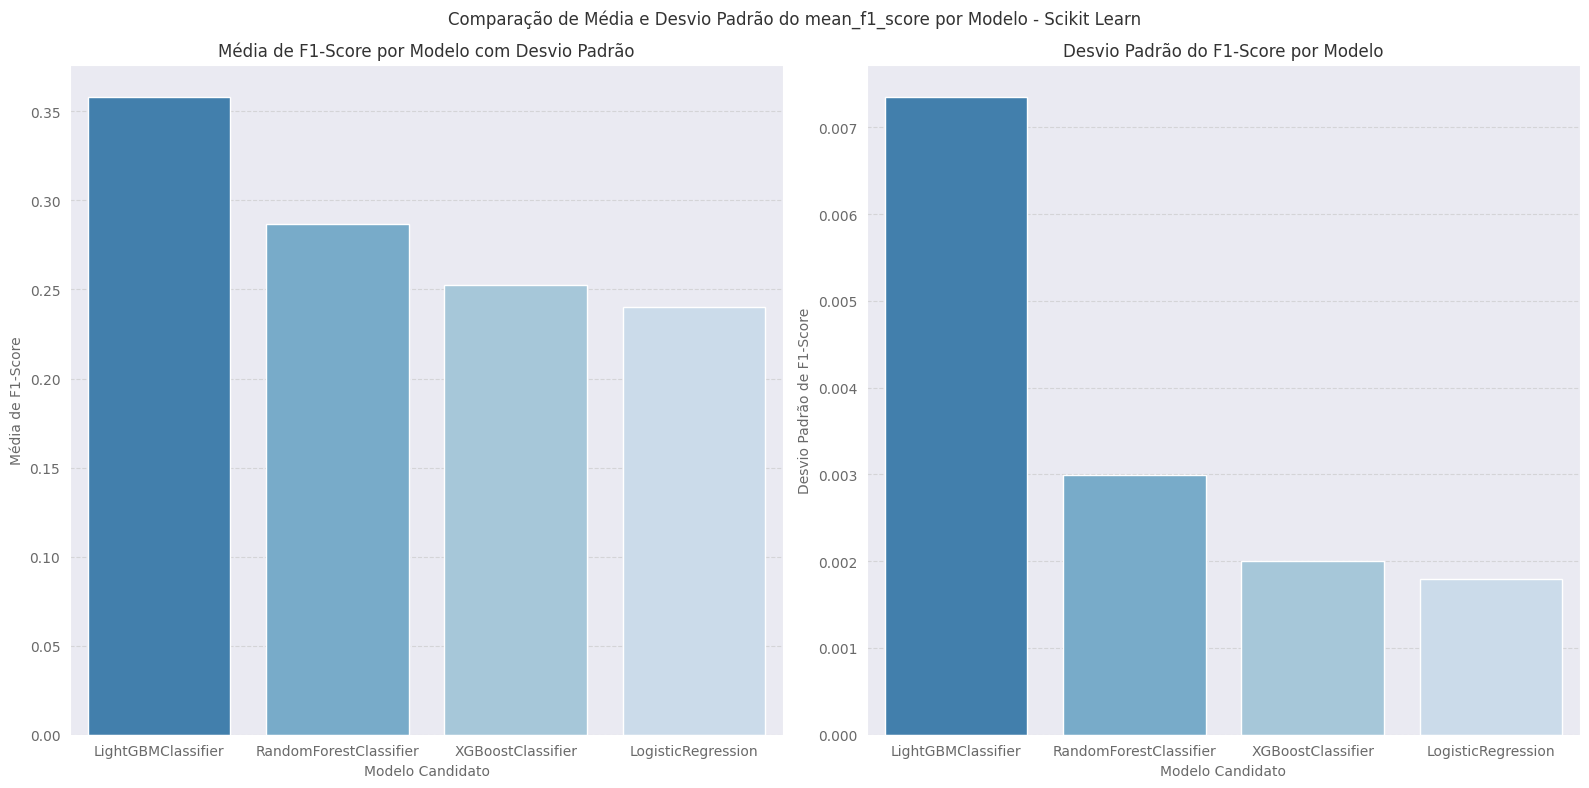

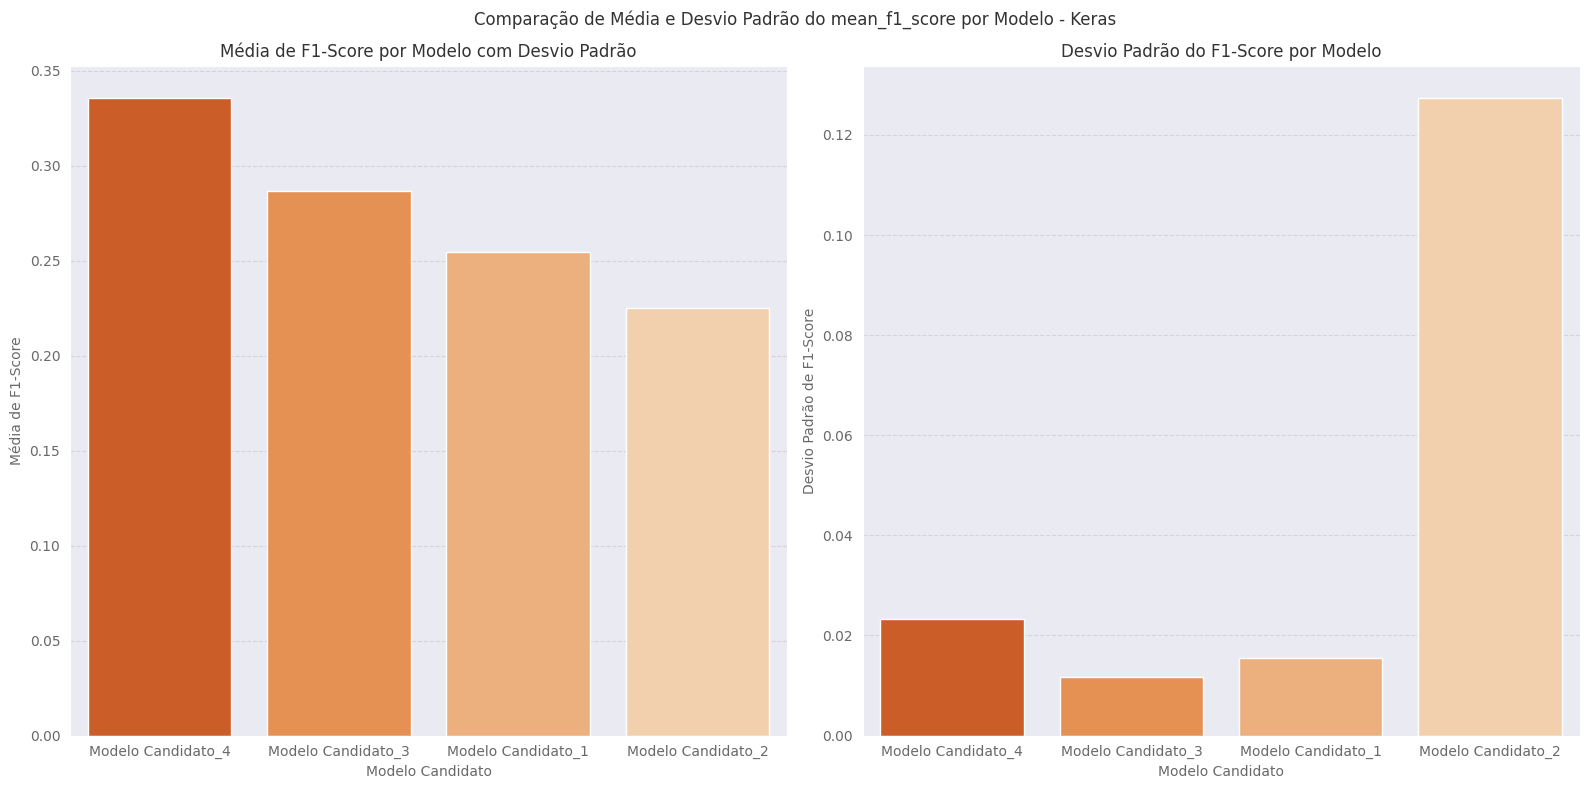

In [ ]:
# Plotando gráfico com as métricas

# comparison_df_classicos => modelos clássicos
# comparison_df_keras => modelos RN

chartpalette = plt.get_cmap('tab20c')

# Plot para modelos Scikit Learn
df_plot = comparison_df_classicos.sort_values(by= "Mean CV F1-Score", ascending= False).copy()
df_plot_filtered = df_plot.dropna(subset=['Mean CV F1-Score', 'Std CV F1-Score']).copy().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)
sns.barplot(
        data= df_plot_filtered,
        x= 'Model',
        y= "Mean CV F1-Score",
        hue= 'Model',
        palette= chartpalette.colors[0:],
        ax= axes[0])

axes[0].set_title('Média de F1-Score por Modelo com Desvio Padrão')
axes[0].set_xlabel('Modelo Candidato')
axes[0].set_ylabel('Média de F1-Score')
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

sns.barplot(
       data=df_plot_filtered,
       x='Model',
       y="Std CV F1-Score",
       hue= 'Model',
       ax=axes[1],
       palette=chartpalette.colors[0:])

axes[1].set_title('Desvio Padrão do F1-Score por Modelo')
axes[1].set_xlabel('Modelo Candidato')
axes[1].set_ylabel('Desvio Padrão de F1-Score')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle(f'Comparação de Média e Desvio Padrão do mean_f1_score por Modelo - Scikit Learn')

plt.tight_layout()
plt.show()


# Plot para Keras

df_plot = comparison_df_keras.sort_values(by= "Mean F1-Score", ascending= False).copy()
df_plot_filtered = df_plot.dropna(subset=['Mean F1-Score', 'Std F1-Score']).copy().reset_index()


fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)
sns.barplot(
        data= df_plot_filtered,
        x= 'Model',
        y= "Mean F1-Score",
        hue= 'Model',
        palette= chartpalette.colors[4:],
        ax= axes[0])

axes[0].set_title('Média de F1-Score por Modelo com Desvio Padrão')
axes[0].set_xlabel('Modelo Candidato')
axes[0].set_ylabel('Média de F1-Score')
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

sns.barplot(
       data=df_plot_filtered,
       x='Model',
       y="Std F1-Score",
       hue= 'Model',
       ax=axes[1],
       palette= chartpalette.colors[4:])

axes[1].set_title('Desvio Padrão do F1-Score por Modelo')
axes[1].set_xlabel('Modelo Candidato')
axes[1].set_ylabel('Desvio Padrão de F1-Score')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle(f'Comparação de Média e Desvio Padrão do mean_f1_score por Modelo - Keras')

plt.tight_layout()
plt.show()


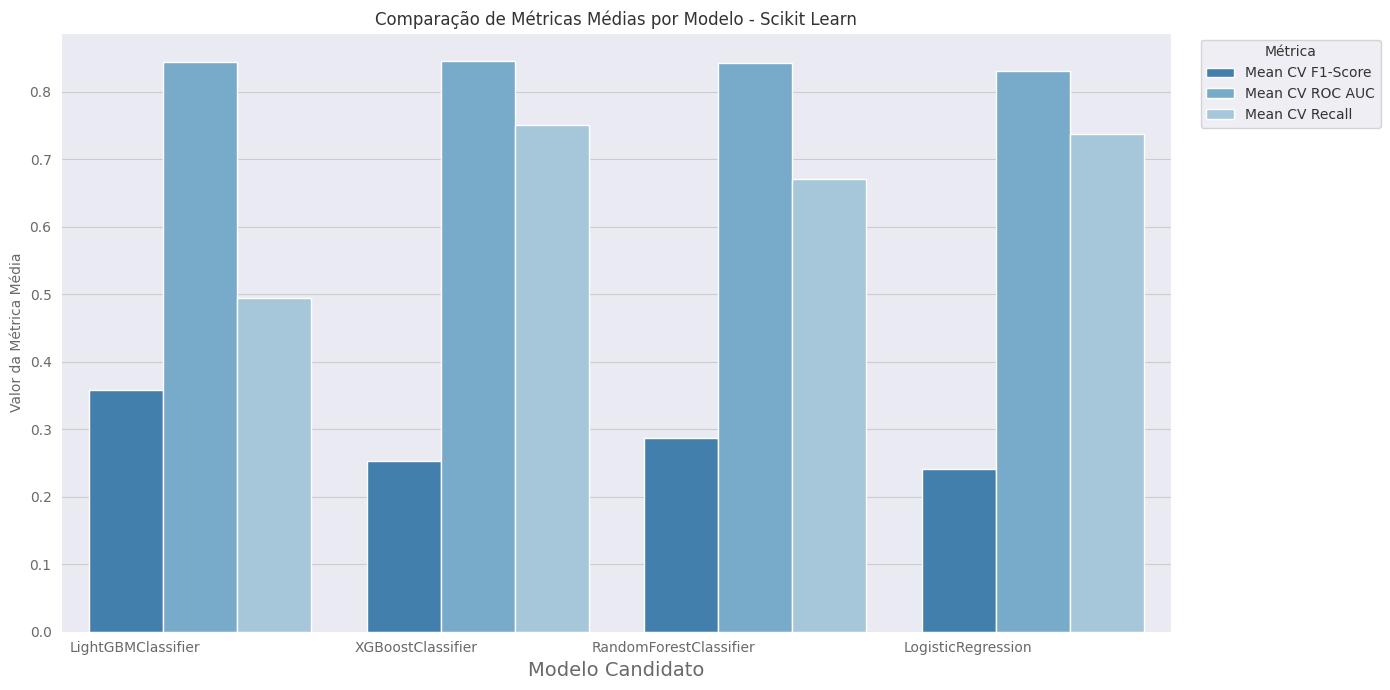

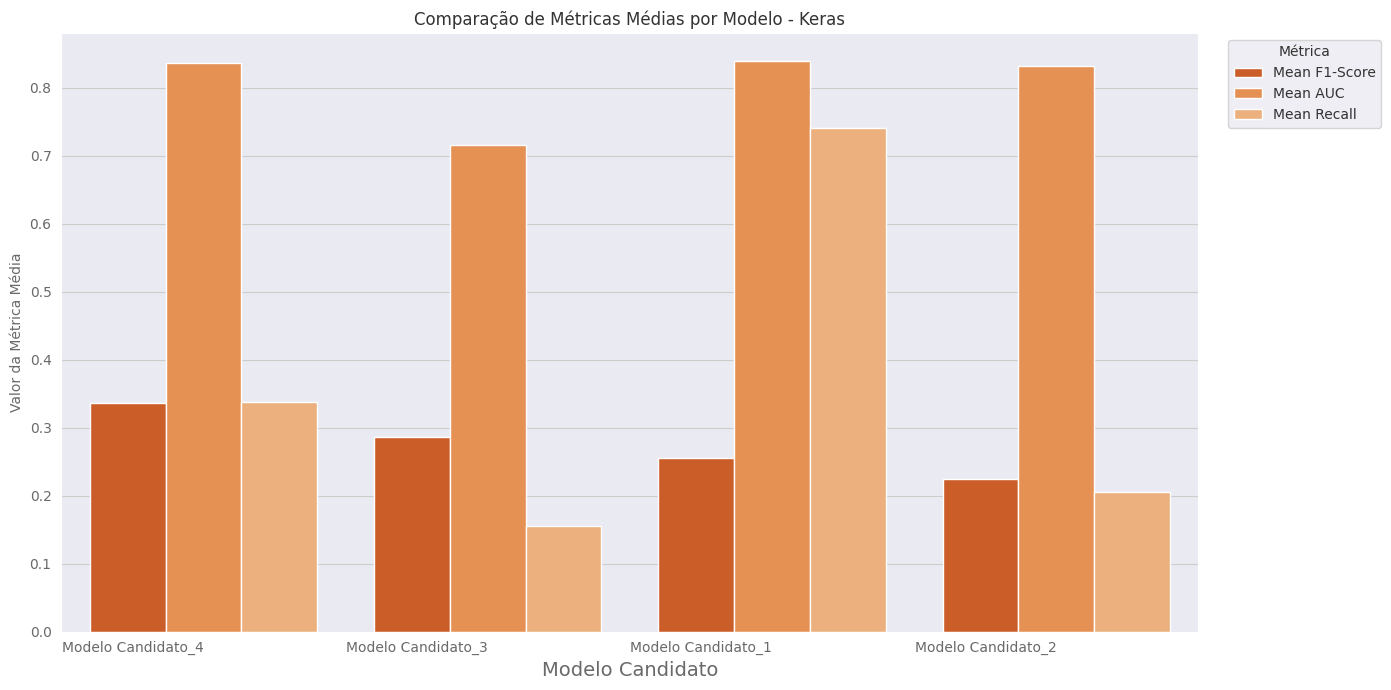

In [ ]:
# Barras agrupadas

metrics_to_compare = ['Mean CV F1-Score', 'Mean CV ROC AUC', 'Mean CV Recall']

# Preparar o DataFrame para o seaborn (formato "long") para df com modelos scikit learn
df_plot_multi = comparison_df_classicos[['Model'] + metrics_to_compare].melt(
        id_vars='Model', var_name='Métrica', value_name='Valor Médio')


plt.figure(figsize=(14, 7))
sns.barplot(data=df_plot_multi, x='Model', y='Valor Médio', hue='Métrica', palette= chartpalette.colors[0:])
plt.title('Comparação de Métricas Médias por Modelo - Scikit Learn')
plt.xlabel('Modelo Candidato', fontsize= 14)
plt.ylabel('Valor da Métrica Média')
plt.xticks(rotation=0, ha='right')
plt.legend(title='Métrica', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()



metrics_to_keras = ['Mean F1-Score', 'Mean AUC', 'Mean Recall']

# Preparar o DataFrame para o seaborn (formato "long") para df com modelos keras
df_plot_multi = comparison_df_keras[['Model'] + metrics_to_keras].melt(
        id_vars='Model', var_name='Métrica', value_name='Valor Médio')


plt.figure(figsize=(14, 7))
sns.barplot(data=df_plot_multi, x='Model', y='Valor Médio', hue='Métrica', palette=chartpalette.colors[4:])
plt.title('Comparação de Métricas Médias por Modelo - Keras')
plt.xlabel('Modelo Candidato', fontsize= 14)
plt.ylabel('Valor da Métrica Média')
plt.xticks(rotation=0, ha='right')
plt.legend(title='Métrica', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

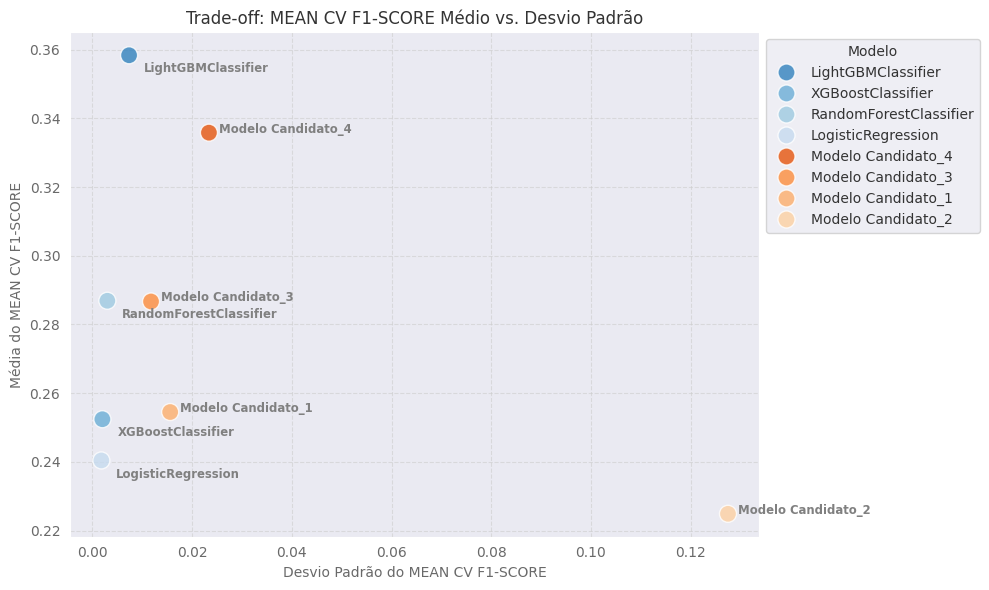

In [ ]:
# F1-score Médio vs. Desvio Padrão do F1-score

x_metric = 'Std CV F1-Score'
y_metric = 'Mean CV F1-Score'

x_metric_keras = 'Std F1-Score'
y_metric_keras = 'Mean F1-Score'

plt.figure(figsize=(10, 6))
sns.scatterplot(data= comparison_df_classicos, x= x_metric,y= y_metric,hue='Model', s=150, alpha=0.8, palette= chartpalette.colors[0:])

sns.scatterplot(data= comparison_df_keras, x= x_metric_keras,y= y_metric_keras, hue='Model', s=150, alpha=0.8, palette= chartpalette.colors[4:])

# Adicionar anotações para cada ponto (nome do modelo)
for i, row in comparison_df_classicos.iterrows():
  plt.text(row[x_metric] + 0.003, row[y_metric] - 0.005,
           row['Model'],horizontalalignment='left', size='small', color='gray', weight='semibold')

for i, row in comparison_df_keras.iterrows():
  plt.text(row[x_metric_keras] + 0.002, row[y_metric_keras],
           row['Model'],horizontalalignment='left', size='small', color='gray', weight='semibold')

plt.title(f'Trade-off: {y_metric.replace("mean_", "").upper()} Médio vs. Desvio Padrão')
plt.xlabel(f'Desvio Padrão do {y_metric.replace("mean_", "").upper()}')
plt.ylabel(f'Média do {y_metric.replace("mean_", "").upper()}')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Modelo', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()



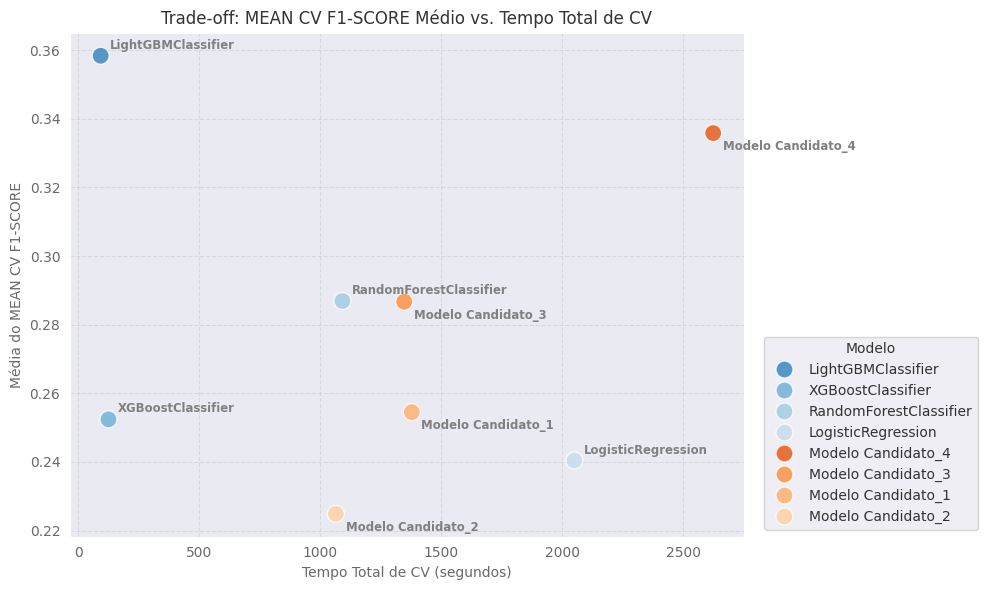

In [ ]:
#  F1-score médio vs. tempo médio de CV

x_metric_time = 'Total Optimization Duration (s)'
y_metric_f1 = 'Mean CV F1-Score'


x_metric_time_keras = 'Total CV Time (s)'
y_metric_f1_keras = 'Mean F1-Score'

plt.figure(figsize=(10, 6))

sns.scatterplot(data= comparison_df_classicos,x= x_metric_time, y= y_metric_f1, hue= 'Model', s=150, alpha=0.8, palette= chartpalette.colors[0:])

sns.scatterplot(data= comparison_df_keras,x= x_metric_time_keras, y= y_metric_f1_keras, hue= 'Model', s=150, alpha=0.8, palette= chartpalette.colors[4:])


# Adicionar anotações para cada ponto (nome do modelo)
for i, row in comparison_df_classicos.iterrows():
  plt.text(row[x_metric_time] + 40, row[y_metric_f1] + 0.002, row['Model'],
                 horizontalalignment='left', size='small', color='gray', weight='semibold')

# Adicionar anotações para cada ponto (nome do modelo)
for i, row in comparison_df_keras.iterrows():
  plt.text(row[x_metric_time_keras] + 40, row[y_metric_f1_keras] - 0.005, row['Model'],
                 horizontalalignment='left', size='small', color='gray', weight='semibold')


plt.title(f'Trade-off: {y_metric_f1.replace("mean_", "").upper()} Médio vs. Tempo Total de CV')
plt.xlabel('Tempo Total de CV (segundos)')
plt.ylabel(f'Média do {y_metric_f1.replace("mean_", "").upper()}')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Modelo', bbox_to_anchor=(1.02, 0), loc='lower left')
plt.tight_layout()
plt.show()


####**Análise dos Gráficos Comparativos**

  * Estes gráficos confirmam a escolha dos modelos LightGBM e do Modelo Candidato 4 das Redes Neurais, pois estes modelos são os que apresentam o melhor desempenho quando avaliamos consistência entre diferentes folds nas métricas de F1 Score, Recall e ROC AUC.

  * A respeito do primeiro conjunto de gráficos, podemos perceber como o modelo LightGBM apresenta o melhor F1 Score em relação aos outros. Apesar de o desvio padrão deste modelo ser o maior, o número absoluto mesmo assim é muito baixo (0.0075 aproximadamente) o que não representa uma grande variação.
  
  * Quando olhamos para os modelos Keras, fica evidente que o Modelo Candidato 4 também se destaca por ter o melhor F1 Score e ainda possui o menor desvio padrão.

  * Na métrica Recall, a situação é diferente.Os modelos LightGBM e Keras Modelo Candidato 4 possuem recalls menores do que os outros, mas como já discutimos em outros momentos, esse Recall alto nem sempre significa melhor qualidade da classificação pois gera muitos falsos positivos. Os modelos com alto recall tendem a acertar mais verdadeiros positivos, sim de fato, porém também erram mais falsos positivos em geral. Neste caso queremos um equilíbrio, com um modelo que classifique muitos verdadeiros positivos mas sem exagerar na classificação de falsos positivos.

  * Os valores de ROC AUC são todos muito semelhantes e bem altos, tanto para modelos Scikit Learn (clássicos), como para modelos de redes neurais (Keras).

  * Quando olhamos para o gráfico que relaciona F1 Score com tempo gasto por fold, vemos que o Modelo LightGBM possui uma ótima relação entre F1 Score alto e pouco tempo de processamento. Já o Modelo candidato 4 possui a pior relação entre tempo e F1 Score, assumindo a posição de modelo mais lento.

## Etapa 7 - Modelos Finais

### Funções para Validação do Melhor Threshold de Classificação

In [ ]:
# Definindo uma função para testar e definir o melhor threshold com base nas métricas

def evaluate_thresholds(labels, pred_probs, thresholds):

  results= []

  # Garante que labels e pred_probs estejam em formato 1D
  labels_flat = np.asarray(labels).flatten()
  pred_probs_flat = np.asarray(pred_probs).flatten()

  for t in thresholds:
    prediction = (pred_probs >= t).astype(int)

    # Calculo das métricas pra cada limiar (threshold)
    precision_sco = precision_score(labels.flatten(), prediction, zero_division=0)
    recall_sco = recall_score(labels.flatten(), prediction, zero_division=0)
    f1_sco = f1_score(labels.flatten(), prediction, zero_division=0)

    # Armazenar os resultados em um dataframe
    results.append({'Threshold': t, 'Precision': precision_sco, 'Recall': recall_sco, 'F1_Score': f1_sco})

  return pd.DataFrame(results)


In [ ]:
# Função plotar o gráfico com os melhores thresholds

def plot_best_threshold(df_metrics, dataset_name, best_f1_threshold=None, best_financial_threshold=None):

  print(f"=> DEBUG: Gerando plot de Métricas X Threshold para o conjunto: {dataset_name}")

  fig= go.Figure()

  fig.add_trace(go.Scatter(x= df_metrics['Threshold'], y= df_metrics['Precision'],
                           mode= 'lines', name= 'Precision',
                           line= dict(color= 'blue')))

  fig.add_trace(go.Scatter(x= df_metrics['Threshold'], y= df_metrics['Recall'],
                            mode= 'lines', name= 'Recall',
                            line= dict(color= 'red')))

  fig.add_trace(go.Scatter(x= df_metrics['Threshold'], y= df_metrics['F1_Score'],
                           mode= 'lines', name= 'F1_Score',
                           line= dict(color= 'green', dash= 'dash')))

  # Adiciona linha vertical para o threshold ótimo F1
  if best_f1_threshold  is not None:
      fig.add_vline(x=best_f1_threshold , line_dash="dash", line_color="purple",
                    annotation_text=f"F1 Ótimo: {best_f1_threshold :.2f}",
                    annotation_position="top right", name=f"F1 Ótimo: {best_f1_threshold :.2f}")

  # Adiciona linha vertical para o threshold ótimo Financeiro
  if best_financial_threshold  is not None:
      fig.add_vline(x=best_financial_threshold , line_dash="dot", line_color="darkorange",
                    annotation_text=f"Financeiro Ótimo: {best_financial_threshold :.2f}",
                    annotation_position="bottom right", name=f"Financeiro Ótimo: {best_financial_threshold :.2f}")

  fig.update_layout(title_text = f'Métricas X Threshold para o conjunto {dataset_name}',
                    title_x= 0.5,
                    xaxis_title= 'Threshold',
                    yaxis_title= 'Valor da Métrica',
                    hovermode= 'x unified',
                    legend= dict(x= 1.02, y= 1, xanchor= 'left', yanchor= 'top'),
                    width= 1000,
                    height= 600)

  fig.show()


In [ ]:
# Definindo uma função para otimizar o threshold que oferece o melhor retorno financeiro

def financial_return_calculator(y_true, y_pred_proba, transaction_value,
                                 profit_rate, rev_cost, thresholds_to_test):

  print("=> DEBUG: Iniciando cálculo de retorno financeiro")

  # Garante que as entradas sejam arrays 1D
  y_true_flat = np.asarray(y_true).flatten()
  y_pred_proba_flat = np.asarray(y_pred_proba).flatten()
  transaction_value_flat = np.asarray(transaction_value).flatten()

  if len(y_true) == 0:
    return 0.0, 0.0

  max_overall_profit = -np.inf
  best_threshold = 0.0
  all_returns_data = []

  for t in thresholds_to_test:
    y_pred_binary = (y_pred_proba_flat >= t).astype(int)
    current_threshold_total_return = 0.0 # restarta em cada threshold

    tn, fp, fn, tp = confusion_matrix(y_true_flat, y_pred_binary).ravel()

    true_pos = (y_true_flat == 1) & (y_pred_binary == 1)
    true_neg = (y_true_flat == 0) & (y_pred_binary == 0)
    false_pos = (y_true_flat == 0) & (y_pred_binary == 1)
    false_neg = (y_true_flat == 1) & (y_pred_binary == 0)

    # Perdas por fraude (False Negatives):
    # Transação NÃO bloqueada E É fraude -> Perda total do valor da transação
    current_fraud_losses = np.sum(transaction_value_flat[false_neg])

    # Receitas de transações legítimas aprovadas (True Negatives):
    # Transação NÃO bloqueada E NÃO É fraude -> Ganho de (valor * profit_rate)
    current_revenues = np.sum(profit_rate * transaction_value_flat[true_neg])

    # Custos de Revisão/Bloqueio:
    # Custo aplicado a CADA transação que foi bloqueada (True Positives e False Positives)
    num_blocked = np.sum(true_pos) + np.sum(false_pos)
    current_review_costs = num_blocked * rev_cost

    # Lucro Total: Receitas - Perdas por Fraude - Custos de Revisão
    current_profit = current_revenues - current_fraud_losses - current_review_costs

    all_returns_data.append({
        'Threshold': t,
        'Profit': current_profit,
        'Fraud_Losses': current_fraud_losses,
        'Revenues': current_revenues,
        'Review_Costs': current_review_costs
    })


    if current_profit > max_overall_profit:
      max_overall_profit = current_profit
      best_threshold = t

  df_financial_details = pd.DataFrame(all_returns_data)

  return max_overall_profit, best_threshold, df_financial_details


In [ ]:
# Plotando melhor threshold com maior retorno financeiro

def plot_financial_threshold(df_financial_return, dataset_name, best_f1_threshold = None, best_financial_threshold = None):

  print(f"=> DEBUG: Gerando plot de Retorno Financeiro X Threshold para o conjunto: {dataset_name}")

  fig = go.Figure()

  fig.add_traces(go.Scatter(x= df_financial_return['Threshold'], y= df_financial_return['Profit'],
                            mode= 'lines',
                            name= 'Retorno Financeiro Total em R$',
                            line= dict(width =2)))

  fig.add_vline(x= best_financial_threshold,
                line_dash= 'dash',
                annotation_text= f"Financeiro Ótimo: {best_financial_threshold:.2f}",
                annotation_position= 'top right',
                name= f"Financeiro Ótimo: {best_financial_threshold:.2f}")

  fig.add_vline(x=best_f1_threshold , line_dash="dash", line_color="purple",
                      annotation_text=f"F1 Ótimo: {best_f1_threshold :.2f}",
                      annotation_position="bottom right", name=f"F1 Ótimo: {best_f1_threshold :.2f}")

  fig.update_layout( title= 'Retorno Financeiro X Threshold de Classificação',
                    xaxis_title= 'Threshold',
                    yaxis_title= 'Retorno Financeiro Total (R$)',
                    hovermode= 'x unified',
                    showlegend= True,
                    width= 1100,
                    height= 600)

  fig.show()


In [ ]:
# Função para visualizar separação entre as classe

def plot_class_distribution(df, score_column, target_column, threshold= None):

  fig, ax = plt.subplots(1, 1, figsize=(8, 6))
  sns.kdeplot(df.loc[df[target_column] == 0, score_column], ax= ax, color= cor_fraudes[0],
              alpha= 0.45, fill= True, label=f'Classe = 0')

  sns.kdeplot(df.loc[df[target_column] == 1, score_column], ax= ax, color= cor_fraudes[1],
              alpha= 0.45, fill= True, label=f'Classe = 1')

  if threshold is not None:
    ax.axvline(threshold, color='gray', linestyle='--', label=f'Threshold ({threshold:.2f})')

  ax.set_title("Distribuição de Score por Fraude ou Não Fraude")
  ax.set_xlabel("Score")
  ax.set_ylabel("Densidade")
  ax.legend(title=target_column)

  plt.tight_layout()
  plt.show()


### Treinamento Final Modelo Best LightGBM


In [ ]:
# Função para recuperar os hiperparâmetros do ml flow

def get_best_params_from_run(run_id):
  run = client.get_run(run_id)
  params = run.data.params

  # Converter os params string para o tipo correto
  processed_params = {}

  for k, v in params.items():
    try:
      # Tenta converter para int, depois float
      processed_params[k] = int(v)
    except ValueError:
      try:
        processed_params[k] = float(v)
      except ValueError:
        # Se não for int nem float, mantém como string
        processed_params[k] = v


  return processed_params


In [ ]:

# mlflow.end_run()


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  #  Recupera os parâmetros do melhor modelo do ML Flow e avalia melhores thresholds no dataset de validação
  #  => NÃO RODAR ESTA CÉLULA, PROCESSO DE TREINAMENTO LONGO <=

  mlflow.set_tracking_uri("file:///content/drive/MyDrive/Data Science/Puc Rio DS/04_Sprint Machine Learning/ML_Flow")
  mlflow.set_experiment("Modelo_Fraude_ML_Classico_CV_5")
  client = MlflowClient()

  # Nome do melhor modelo lgbm logado com um id
  model_name = "LightGBMClassifier"
  best_lgbm_run_id = "8c070a54877f45a39a931c8dd50a88da"

  print(f"Modelo '{model_name}' carregado com sucesso")

  raw_best_params = get_best_params_from_run(best_lgbm_run_id)

  best_params = {}
  for k, v in raw_best_params.items():
      if k.startswith('best_param_'):
          param_name = k.replace('best_param_', '')
          best_params[param_name] = v

  print(f"Hiperparâmetros Limpos para {model_name}: {best_params}")

  # Definindo range dos thresholds a serem testados
  thresholds_to_test = np.arange(0.1, 1, 0.01) # de 0.1 a 0.99 com passo de 0.01

  # Define os parâmetros de negócio
  profit_rate = 0.10
  rev_cost = 5.0

  # Calcule os pesos de classe para o conjunto de treinamento FINAL
  final_class_weights = calculate_class_weights(y_train_initial)

  # Debug Verifique se X_train é um DataFrame e tem colunas
  print(f"=> Debug Tipo de X_train após pre_pipe e astype: {type(X_train)}")
  if isinstance(X_train, pd.DataFrame):
    print(f"=> DebugColunas de X_train: {X_train.columns.tolist()}")

  print(f"Hiperparâmetros recuperados para {model_name}: {best_params}")

  # Instanciar o modelo com os melhores hiperparâmetros
  final_lgbm_model = None

  final_lgbm_model = LGBMClassifier(random_state= 71, **best_params)
  if 'scale_pos_weight' not in best_params and 'class_weight' not in best_params:
    final_lgbm_model.set_params(class_weight=final_class_weights) # Aplica os pesos
  elif 'scale_pos_weight' in best_params:
    pass # Usar o que veio dos params se já existe.
  elif 'class_weight' in best_params:
    pass # Usar o que veio dos params se já existe.

  with mlflow.start_run(run_name=f"Final_Eval_{model_name}", nested=True) as final_eval_run:
              mlflow.set_tag("evaluation_type", "Final Model Evaluation on Test Set")
              mlflow.log_params(best_params)

  final_lgbm_model.fit(X_train, y_train_raw.values)
  print(f"Treinamento final de {model_name} concluído.")

  print(f"=>> Debug Colunas com as quais o LGBM foi treinado: {final_lgbm_model.feature_name_}")

  print(f"=> Debug Tipo de X_val: {type(X_val_train)}")
  if isinstance(X_val_train, pd.DataFrame):
    print(f"=> Debug Colunas de X_val (antes da previsão): {X_val_train.columns.tolist()}")


  # Otimizar Thresholds no Conjunto de Validação (X_val)
  print(f"Otimizando thresholds para {model_name} no conjunto de VALIDAÇÃO...")
  pred_proba_val = final_lgbm_model.predict_proba(X_val_train)[:, 1] # Para sklearn

  y_val_np = y_val_raw.values
  tv_val_np = tv_val.values

  # Calcula métricas para diferentes thresholds
  df_metrics_val = evaluate_thresholds(y_val_np, pred_proba_val, thresholds_to_test)
  best_f1_threshold_val = df_metrics_val.loc[df_metrics_val['F1_Score'].idxmax()]['Threshold']

  # Função calcula retorno financeiro para diferentes thresholds
  max_return_val, best_financial_threshold_val, df_financial_returns_val = financial_return_calculator(
      y_val_np, pred_proba_val, tv_val_np,
      profit_rate, rev_cost, thresholds_to_test)

  print(f"No conjunto de Validação para {model_name}:")
  print(f"Retorno Financeiro Máximo: R$ {max_return_val:.2f} (Threshold: {best_financial_threshold_val:.4f})")
  print(f"Melhor F1-Score Threshold: {best_f1_threshold_val:.4f}")

  # Loga os thresholds escolhidos no mlflow
  mlflow.log_metric("best_f1_threshold_val", best_f1_threshold_val)
  mlflow.log_metric("best_financial_threshold_val", best_financial_threshold_val)
  mlflow.log_metric("max_financial_return_val", max_return_val)

  # Funções para plotar os gráficos de threshold para validação
  plot_best_threshold(df_metrics_val, "Validação", best_f1_threshold_val, best_financial_threshold_val)

  plot_financial_threshold(df_financial_returns_val, "Validação", best_f1_threshold_val, best_financial_threshold_val)

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Salvando modelo no formato pkl

  model = final_lgbm_model
  model_filename = "LightGBM_Best_Model.pkl"
  joblib.dump(model, model_filename)

  print(f"Modelo salvo como '{model_filename}'")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
# Recuperando modelo no formato pkl

github_url = "https://raw.githubusercontent.com/BLayus/MVP_Machine-Learning/main/Models/LightGBM_Best_Model.pkl"

model_name = "LightGBM_Best_Model.pkl"

print(f"Baixando modelo do GitHub: {github_url}")
response = requests.get(github_url)
response.raise_for_status()

LGBM_Model = joblib.load(BytesIO(response.content))

print("Modelo carregado com sucesso!")


Baixando modelo do GitHub: https://raw.githubusercontent.com/BLayus/MVP_Machine-Learning/main/Models/LightGBM_Best_Model.pkl
Modelo carregado com sucesso!


Pesos de Classe Calculados: {0: np.float64(0.5263157894736842), 1: np.float64(10.0)}
Contagem de Não-Fraude (Classe 0): 99750
Contagem de Fraude (Classe 1): 5250
=> Previsões de probabilidades no conjunto de TESTE
=> ROC AUC Score no conjunto de TESTE: 0.8501

=> Avaliando métricas por threshold no conjunto de TESTE...
=> Calculando retorno financeiro por threshold no conjunto de TESTE...
=> DEBUG: Iniciando cálculo de retorno financeiro
Retorno Financeiro Máximo no TESTE: R$ 80855.23 (Threshold: 0.4700)

Recall no Threshold Financeiro Ótimo: 0.5329
F1-Score no Threshold Financeiro Ótimo: 0.3547
=> Matriz de Confusão no conjunto de TESTE (Threshold Financeiro Ótimo):

[[39439  3311]
 [ 1051  1199]]
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.95     42750
         1.0       0.27      0.53      0.35      2250

    accuracy                           0.90     45000
   macro avg       0.62      0.73      0.65     45000
weighted avg       0

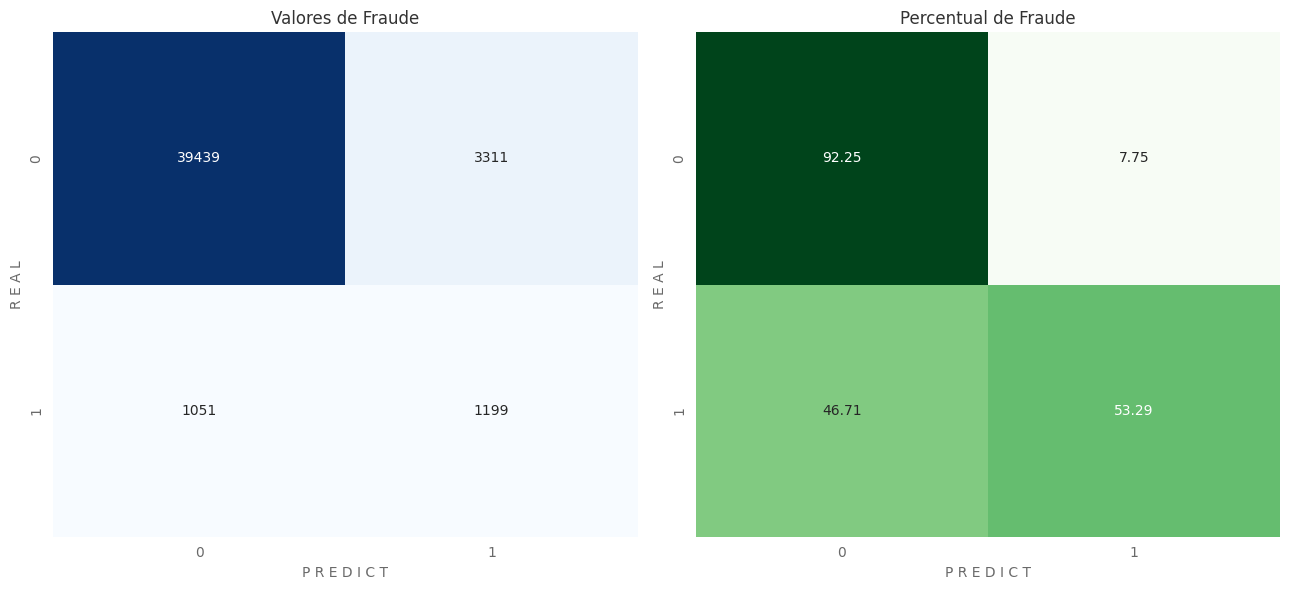

=> DEBUG: Plotagem da matriz de confusão concluída para threshold 0.47.
None
=> Gerando plots para o conjunto de TESTE...
=> DEBUG: Aplicando plot_roc_auc_curve para o modelo: LightGBM


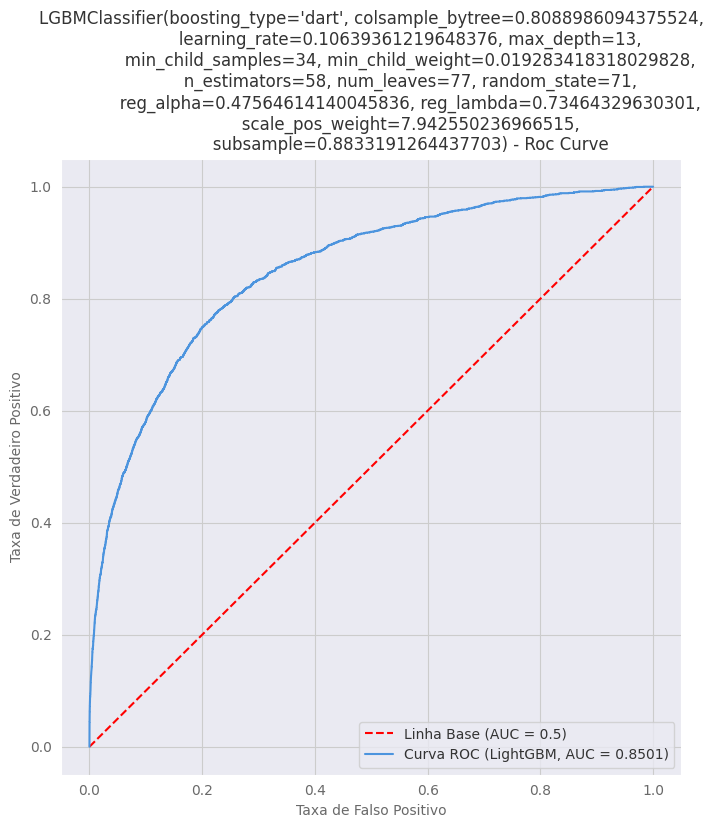

ROC AUC Score: 0.8501320285899935

=> DEBUG: Aplicando plot_roc_auc_curve para o modelo: LightGBM


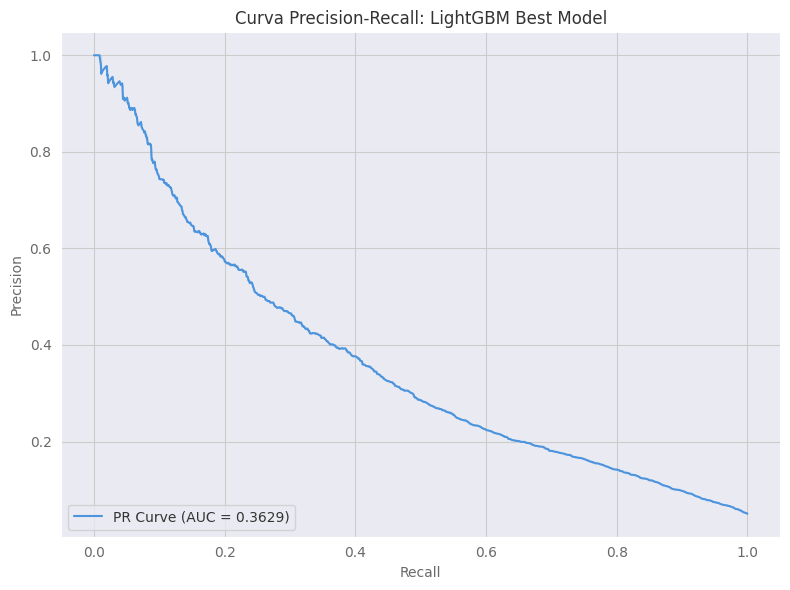

Precision-Recall AUC Score: 0.3629006930195795



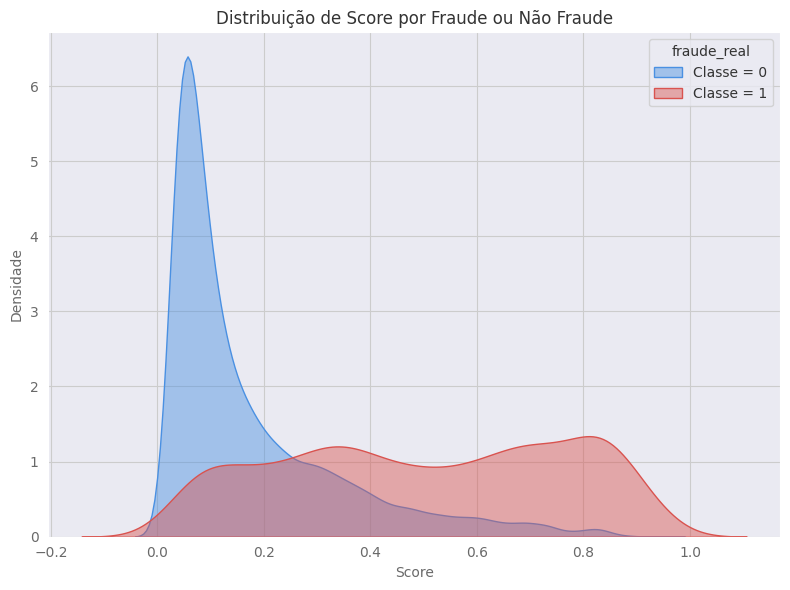

=> DEBUG: Gerando plot de Métricas X Threshold para o conjunto: Teste


=> DEBUG: Gerando plot de Retorno Financeiro X Threshold para o conjunto: Teste


Detalhes Financeiros do Threshold Ótimo:
Lucro: R$ 80855.23
Perdas por Fraude: R$ 57181.80
Receitas: R$ 160587.03
Custos de Revisão: R$ 22550.00
Razão de Lucro: 0.503
=> Coletando lista com métricas para comparação
=> Avaliação do modelo no conjunto de TESTE concluída.


In [ ]:
# Rodando o melhor modelo no dataset de teste e aplicando funções finais de avaliação

# Definindo range dos thresholds a serem testados
thresholds_to_test = np.arange(0.1, 1, 0.01) # de 0.1 a 0.99 com passo de 0.01

# Define os parâmetros de negócio
profit_rate = 0.10
rev_cost = 5.0

# Calcule os pesos de classe para o conjunto de treinamento FINAL
final_class_weights = calculate_class_weights(y_train_initial)

# Class labels
class_names_labels = ['Não Fraude', 'Fraude']


# 1=> Prever probabilidades no conjunto de teste
print("=> Previsões de probabilidades no conjunto de TESTE")
pred_proba_test = LGBM_Model.predict_proba(X_test)[:, 1]

# Converter y_test_raw e tv_raw para arrays NumPy 1D
y_test_np = y_test_raw.values.astype('float32') # Convertendo Series para NumPy array 1D
tv_test_np = tv_raw.values.astype('float32')

# 2=> Calcular ROC AUC Score para o conjunto de TESTE
roc_auc_test = roc_auc_score(y_test_np, pred_proba_test)
print(f"=> ROC AUC Score no conjunto de TESTE: {roc_auc_test:.4f}\n")

# 3=> Avaliar métricas para diferentes thresholds no conjunto de TESTE
print("=> Avaliando métricas por threshold no conjunto de TESTE...")
df_metrics_test = evaluate_thresholds(y_test_np, pred_proba_test, thresholds_to_test)

# 4=> Calcular o Retorno Financeiro para diferentes thresholds no conjunto de TESTE
print("=> Calculando retorno financeiro por threshold no conjunto de TESTE...")
max_overall_profit, best_financial_threshold_test, df_financial_details = \
    financial_return_calculator(
        y_test_np, pred_proba_test, tv_test_np,
        profit_rate, rev_cost, thresholds_to_test)

print(f"Retorno Financeiro Máximo no TESTE: R$ {max_overall_profit:.2f} (Threshold: {best_financial_threshold_test:.4f})\n")

# Para o threshold financeiro ótimo, obtenha as métricas de classificação
best_f1_threshold_test = df_metrics_test.loc[df_metrics_test['F1_Score'].idxmax()]['Threshold']

y_pred_at_financial_threshold_test = (pred_proba_test >= best_financial_threshold_test).astype(int)
financial_threshold_recall_test = recall_score(y_test_np, y_pred_at_financial_threshold_test)
financial_threshold_f1_test = f1_score(y_test_np, y_pred_at_financial_threshold_test)

print(f"Recall no Threshold Financeiro Ótimo: {financial_threshold_recall_test:.4f}")
print(f"F1-Score no Threshold Financeiro Ótimo: {financial_threshold_f1_test:.4f}")

# 5=> Gerar Matrizes de Confusão nos thresholds ótimos
print("=> Matriz de Confusão no conjunto de TESTE (Threshold Financeiro Ótimo):\n")
y_pred_financial_optimal_test = (pred_proba_test >= best_financial_threshold_test).astype(int)
cm_financial_optimal_test = confusion_matrix(y_test_np, y_pred_financial_optimal_test)
print(cm_financial_optimal_test)
print(classification_report(y_test_np, y_pred_financial_optimal_test))

# Plot da Matriz de Confusão para Threshold Financeiro Ótimo
print(plot_confusion_matrix(LGBM_Model, X_test, y_test_np, best_financial_threshold_test,
                            class_names_labels, title_suffix="Teste - Threshold Financeiro Ótimo"))

# 6=> Gerar Plots para o conjunto de TESTE
print("=> Gerando plots para o conjunto de TESTE...")

# Plot roc auc curve and pr curve
plot_roc_auc_curve (LGBM_Model, X_test, y_test_np, model_name="LightGBM", title_suffix="Best Model")

plot_precision_recall_curve(LGBM_Model, X_test, y_test_np, model_name="LightGBM", title_suffix="Best Model")

# Plot class distribution
df_class_dist = pd.DataFrame({
    'scores_modelo': pred_proba_test,        # Coluna para os scores
    'fraude_real': y_test_raw.values if isinstance(y_test_raw, np.ndarray) else y_test_raw # Coluna para os rótulos
                          })

plot_class_distribution(df_class_dist, 'scores_modelo', 'fraude_real', threshold= None)

# Plot de Métricas X Threshold
plot_best_threshold(df_metrics_test, "Teste", best_f1_threshold_test, best_financial_threshold_test)

# Plot de Retorno Financeiro X Threshold
plot_financial_threshold(df_financial_details , "Teste", best_f1_threshold_test, best_financial_threshold_test)

best_threshold_details = df_financial_details[df_financial_details['Threshold'] == best_financial_threshold_test].iloc[0]
print("Detalhes Financeiros do Threshold Ótimo:")
print(f"Lucro: R$ {best_threshold_details['Profit']:.2f}")
print(f"Perdas por Fraude: R$ {best_threshold_details['Fraud_Losses']:.2f}")
print(f"Receitas: R$ {best_threshold_details['Revenues']:.2f}")
print(f"Custos de Revisão: R$ {best_threshold_details['Review_Costs']:.2f}")
print(f"Razão de Lucro: {(best_threshold_details['Profit'] / best_threshold_details['Revenues']):.3f}")

print(f"=> Coletando lista com métricas para comparação")
metrics_lgbm = {
    'ROC AUC': roc_auc_test,
    'Max F1-Score': best_f1_threshold_test,
    'Threshold Financeiro Ótimo': best_financial_threshold_test,
    'Lucro (Th Financeiro Ótimo)': best_threshold_details['Profit'],
    'Perdas por Fraude (Th Financeiro Ótimo)': best_threshold_details['Fraud_Losses'],
    'Receitas (Th Financeiro Ótimo)': best_threshold_details['Revenues'],
    'Custos de Revisão (Th Financeiro Ótimo)': best_threshold_details['Review_Costs'],
    'Razão de Lucro (Th Financeiro Ótimo)': best_threshold_details['Profit'] / best_threshold_details['Revenues'],
    'Recall no Threshold Financeiro Ótimo': financial_threshold_recall_test,
    'F1-Score no Threshold Financeiro Ótimo': financial_threshold_f1_test
}

print("=" * 50)
print("=> Avaliação do modelo no conjunto de TESTE concluída.")


### Treinamento Final Modelo Best Keras

In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Recuperando hiper parametros do ml flow
  #  => NÃO RODAR ESTA CÉLULA, PROCESSO DE TREINAMENTO LONGO <=

  mlflow.set_tracking_uri("file:///content/drive/MyDrive/Data Science/Puc Rio DS/04_Sprint Machine Learning/ML_Flow")
  keras_experiment_name= "Modelos_Fraude_Keras"
  mlflow.set_experiment(keras_experiment_name )
  client = MlflowClient()

  # ID do run que contém os hiperparâmetros do best model
  target_run_id = "060b4ea722aa4a409c75219ca5782402"
  model_name_for_retrain = "KerasClassifier_Retrained_Model"

  print(f"Iniciando recuperação de hiperparâmetros do Run ID: {target_run_id}")

  try:
    # Obtém o objeto Run diretamente pelo ID
    best_run = client.get_run(target_run_id)

    if not best_run:
      raise ValueError(f"Run ID '{target_run_id}' não encontrado.")

    # Extrai os hiperparâmetros logados com o prefixo 'hp_'
    # e converte os valores para os tipos corretos (int, float)
    best_hyperparameters = {}
    for k, v in best_run.data.params.items():
      if k.startswith('hp_'):
        param_name = k.replace('hp_', '')
        try:
          # Tenta converter para int, depois float, senão mantém como string
          best_hyperparameters[param_name] = int(v)
        except ValueError:
          try:
            best_hyperparameters[param_name] = float(v)
          except ValueError:
            best_hyperparameters[param_name] = v # Mantém como string se não for número

    print("\nHiperparâmetros Recuperados")
    for k, v in best_hyperparameters.items():
        print(f"  {k}: {v} (Tipo: {type(v).__name__})")

  except ValueError as ve:
      print(f"\nERRO de Configuração ou Dados: {ve}")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
# Função build com os hps certos

def build_model4_retrain(best_hps_dict, num_features, fraud_count_val, not_fraud_count_val):

  output_bias = tf.keras.initializers.Constant(np.log([fraud_count_val / not_fraud_count_val]))

  model = keras.Sequential()

  # Camada de Input explícita (usando num_features para o shape)
  model.add(layers.Input(shape=(num_features,)))

  # Primeira Camada Densa
  # Usando .get() para recuperar o valor do dicionário
  units_layer1 = best_hps_dict.get('units_layer1', 250)
  model.add(layers.Dense(units=units_layer1, activation='relu'))

  # Taxa de Dropout
  dropout_rate = best_hps_dict.get('dropout_rate', 0.2) # O HP 'dropout_rate' foi logado uma vez
  model.add(layers.Dropout(dropout_rate))

  # Segunda Camada Densa
  units_layer2 = best_hps_dict.get('units_layer2', 250)
  model.add(layers.Dense(units=units_layer2, activation='relu'))

  model.add(layers.Dropout(dropout_rate))

  units_layer3 = best_hps_dict.get('units_layer3', 250)
  model.add(layers.Dense(units=units_layer3, activation='relu'))
  model.add(layers.Dropout(dropout_rate)) # Reutiliza a mesma taxa de dropout

  # Camada de Saída
  model.add(layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))

  # Otimizador e Taxa de Aprendizado
  learning_rate = best_hps_dict.get('learning_rate', 1e-3)
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(
      optimizer=optimizer,
      loss='binary_crossentropy',
      metrics=[
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
          keras.metrics.AUC(name='prc', curve='PR'),
          F1Score(threshold=0.5, name='f1_score')
      ]
  )
  return model


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Retreinando modelo final keras
  #  => NÃO RODAR ESTA CÉLULA, PROCESSO DE TREINAMENTO LONGO <=

  num_features = X_train_keras.shape[1]
  not_fraud_count, fraud_count = np.bincount(y_train.astype(int))

  # Função build_model4_retrain
  model_final = build_model4_retrain(best_hyperparameters, num_features, fraud_count, not_fraud_count)
  print("\nModelo Keras reconstruído com os hiperparâmetros otimizados.")

  model_name_for_retrain = "KerasClassifier_Retrained_Model_Final"

  final_class_weights = calculate_class_weights(y_train_initial)

  epochs_final = int(best_run.data.params.get('epochs', 30)) #=>> alterar para 30 após rodar tudo certo
  batch_size_final = int(best_run.data.params.get('batch_size', 64))

  print(f"\nIniciando o treinamento do modelo final (retreinado com HPs do Run ID: {target_run_id}) no dataset completo...")
  with mlflow.start_run(run_name=f"Final_Keras_Retrain_from_{target_run_id[:8]}", nested=True, experiment_id=keras_experiment.experiment_id) as retrain_run:
    mlflow.log_params({f'final_hp_{k}': v for k, v in best_hyperparameters.items()})
    mlflow.log_param("final_epochs", epochs_final)
    mlflow.log_param("final_batch_size", batch_size_final)
    mlflow.log_param("original_cv_run_id", target_run_id)

    history = model_final.fit(X_train_keras, y_train_keras,
                              epochs=epochs_final,
                              batch_size=batch_size_final,
                              verbose=1,
                              class_weight=final_class_weights)

    final_results = model_final.evaluate(X_train_keras, y_train_keras, verbose=0)
    final_metrics_names = model_final.metrics_names
    final_metrics = dict(zip(final_metrics_names, final_results))

    print("\nMétricas do modelo final retreinado (no dataset completo, para referência):")
    for name, value in final_metrics.items():
        if name == 'precision' and 'recall' in final_metrics_names:
          p = final_metrics.get('precision', 0)
          r = final_metrics.get('recall', 0)
          f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
          print(f"  final_f1_score: {f1:.4f}")
          mlflow.log_metric(f"final_f1_score", f1)

        print(f"  final_{name}: {value:.4f}")
        mlflow.log_metric(f"final_{name}", value)

    # Assinatura do modelo e um exemplo de entrada
    signature = mlflow.models.infer_signature(X_train_keras, model_final.predict(X_train_keras[:1]))
    input_example = X_train_keras[:5]

    input_example_for_mlflow = None
  if isinstance(input_example, np.ndarray):
    input_example_for_mlflow = input_example.tolist()
  elif isinstance(input_example, pd.DataFrame):
    input_example_for_mlflow = input_example.to_dict(orient='records')
  else:
    input_example_for_mlflow = input_example

    mlflow.keras.log_model(model_final, name="model_retrained", signature=signature, input_example=input_example)
    print(f"\nModelo Keras final retreinado logado no Run ID: {retrain_run.info.run_id}")

    registered_model = mlflow.register_model(
        model_uri=f"runs:/{retrain_run.info.run_id}/model_retrained",
        name=model_name_for_retrain
    )
    print(f"Modelo '{model_name_for_retrain}' registrado com sucesso na versão {registered_model.version}!")
    print(f"URI: {registered_model.source}")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Salvando modelo keras no formato .keras

  model = model_final
  model_keras_path = 'Keras_Best_Model.keras'
  model.save(model_keras_path)
  print(f"Modelo Keras salvo no formato nativo: {model_keras_path}")

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


In [ ]:
# Recuperando modelo no formato pkl

github_url = "https://raw.githubusercontent.com/BLayus/MVP_Machine-Learning/main/Models/Keras_Best_Model.keras"

model_name = "Keras_Best_Model.keras"

try:
    response = requests.get(github_url)
    response.raise_for_status()

    with open(model_name, 'wb') as f:
      f.write(response.content)
    print(f"Modelo baixado e salvo localmente como '{model_name}'")

    Best_keras_model = keras.models.load_model(model_name)

    print(f"Modelo Keras carregado com sucesso do GitHub: {model_name}")
    Best_keras_model.summary()

except requests.exceptions.RequestException as e:
    print(f"Erro ao baixar o modelo do GitHub: {e}")
except Exception as e:
    print(f"Erro ao carregar o modelo Keras: {e}")

Modelo baixado e salvo localmente como 'Keras_Best_Model.keras'
Modelo Keras carregado com sucesso do GitHub: Keras_Best_Model.keras


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 50)             │         1,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 400)            │        20,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 250)            │       100,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 367,355 (1.40 MB)

 Trainable params: 122,451 (478.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,904 (956.66 KB)

In [ ]:
if executar_bloco_treinamento:
  print("Executando bloco de treinamento")

  # Avaliação dos thresholds f1 score e financeiro no conjunto de validação

  # Definindo range dos thresholds a serem testados
  thresholds_to_test = np.arange(0.1, 1, 0.01) # de 0.1 a 0.99 com passo de 0.01

  # Define os parâmetros de negócio
  profit_rate = 0.10
  rev_cost = 5.0

  # Calcule os pesos de classe para o conjunto de treinamento
  final_class_weights = calculate_class_weights(y_train_initial)

  # Otimizar Thresholds no Conjunto de Validação (X_val_keras)
  print(f"Otimizando thresholds para {model_name} no conjunto de VALIDAÇÃO...")
  pred_proba_val = Best_keras_model.predict(X_val_keras).flatten() # Para eras

  y_val_np = y_val_raw.values
  tv_val_np = tv_val.values

  # Calcula métricas para diferentes thresholds
  df_metrics_val = evaluate_thresholds(y_val_np, pred_proba_val, thresholds_to_test)
  best_f1_threshold_val = df_metrics_val.loc[df_metrics_val['F1_Score'].idxmax()]['Threshold']

  # Função calcula retorno financeiro para diferentes thresholds
  max_return_val, best_financial_threshold_val, df_financial_returns_val = financial_return_calculator(
      y_val_np, pred_proba_val, tv_val_np,
      profit_rate, rev_cost, thresholds_to_test)

  print(f"No conjunto de Validação para {model_name}:")
  print(f"Retorno Financeiro Máximo: R$ {max_return_val:.2f} (Threshold: {best_financial_threshold_val:.4f})")
  print(f"Melhor F1-Score Threshold: {best_f1_threshold_val:.4f}")

  # Loga os thresholds escolhidos no mlflow
  mlflow.log_metric("best_f1_threshold_val", best_f1_threshold_val)
  mlflow.log_metric("best_financial_threshold_val", best_financial_threshold_val)
  mlflow.log_metric("max_financial_return_val", max_return_val)

  # Funções para plotar os gráficos de threshold para validação
  plot_best_threshold(df_metrics_val, "Validação", best_f1_threshold_val, best_financial_threshold_val)

  plot_financial_threshold(df_financial_returns_val, "Validação", best_f1_threshold_val, best_financial_threshold_val)

else:
  print("Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)")


Células de treinamento ignoradas (o checkbox 'executar_bloco_treinamento' está desmarcado)


Pesos de Classe Calculados: {0: np.float64(0.5263157894736842), 1: np.float64(10.0)}
Contagem de Não-Fraude (Classe 0): 99750
Contagem de Fraude (Classe 1): 5250
=> Previsões de probabilidades no conjunto de TESTE
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
=> ROC AUC Score no conjunto de TESTE: 0.8382

=> Avaliando métricas por threshold no conjunto de TESTE...
=> Calculando retorno financeiro por threshold no conjunto de TESTE...
=> DEBUG: Iniciando cálculo de retorno financeiro
Retorno Financeiro Máximo no TESTE: R$ 78607.23 (Threshold: 0.4000)

Recall no Threshold Financeiro Ótimo: 0.4787
F1-Score no Threshold Financeiro Ótimo: 0.3348
=> Calculando Retorno Financeiro para o Threshold F1-Score Ótimo para comparação...
=> DEBUG: Iniciando cálculo de retorno financeiro
Retorno Financeiro no Threshold F1-Score Ótimo: R$ 72231.95

=> Matriz de Confusão no conjunto de TESTE (Threshold Financeiro Ótimo):

[[39644  3106]
 [ 1173  1077]]
              precision    recall  f1-score   support


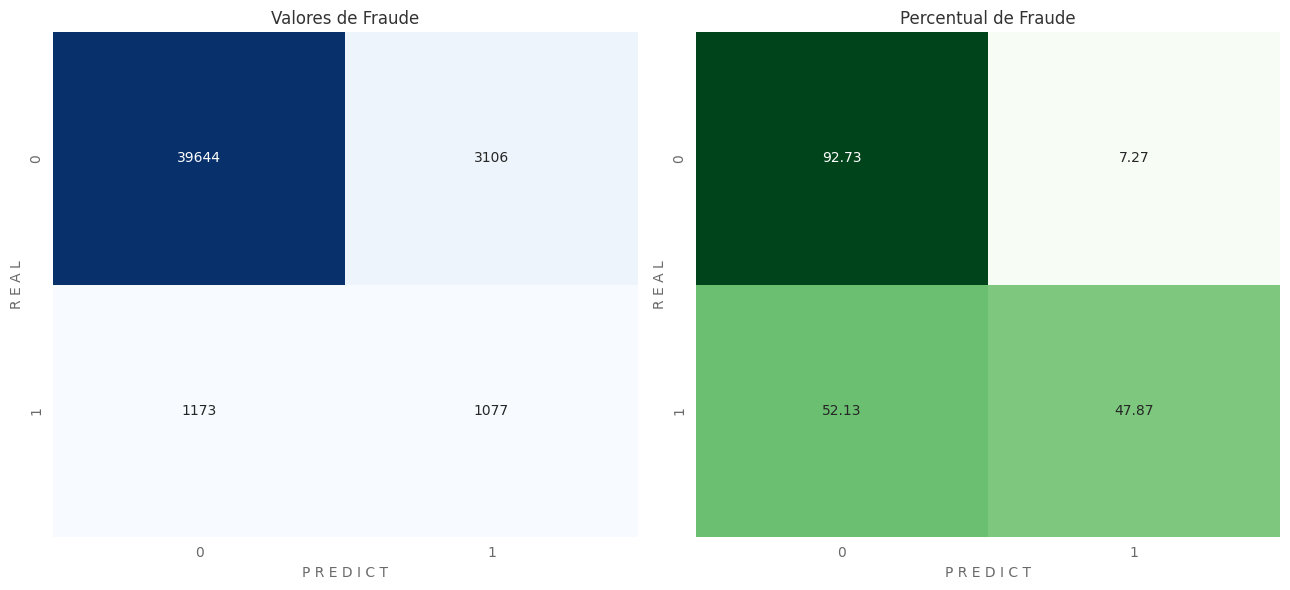

=> DEBUG: Plotagem da matriz de confusão concluída para threshold 0.40.
None
=> Gerando plots para o conjunto de TESTE...
=> DEBUG: Aplicando plot_roc_auc_curve para o modelo: Keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


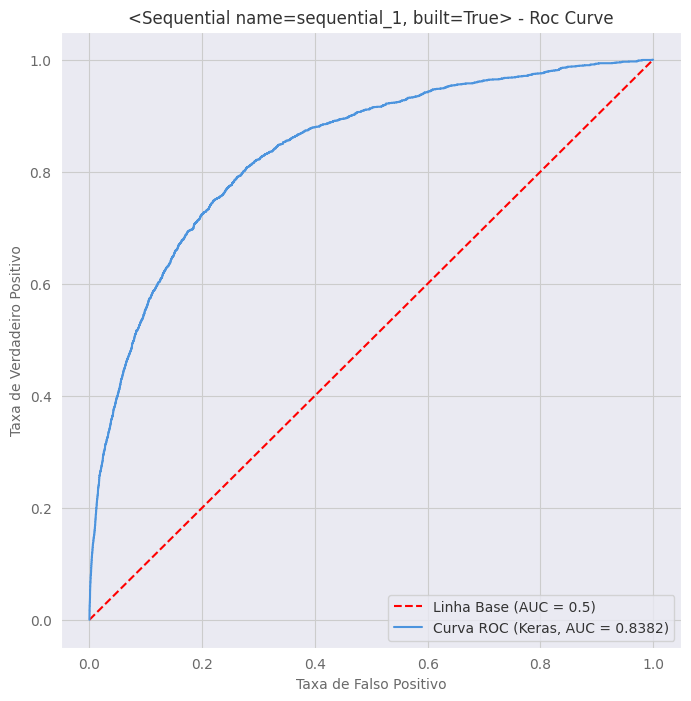

ROC AUC Score: 0.8381594593892138

=> DEBUG: Aplicando plot_roc_auc_curve para o modelo: Keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


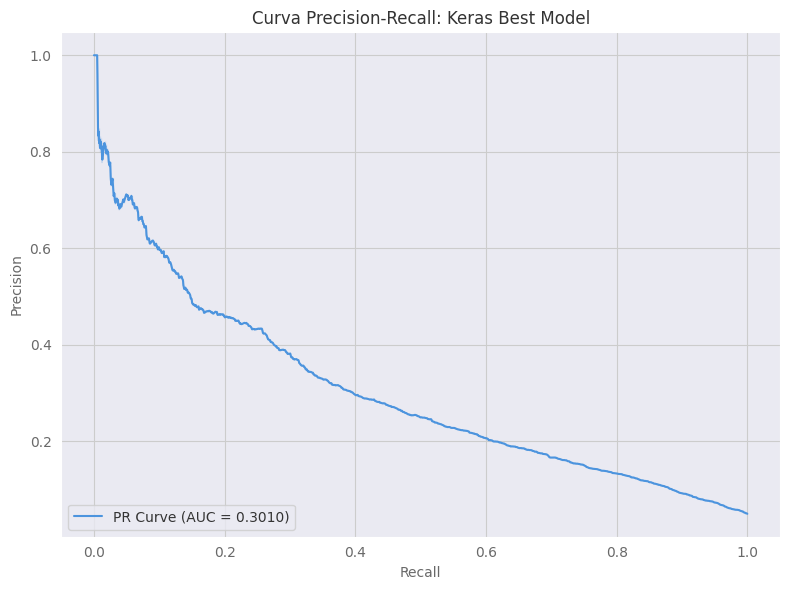

Precision-Recall AUC Score: 0.3010050699033346



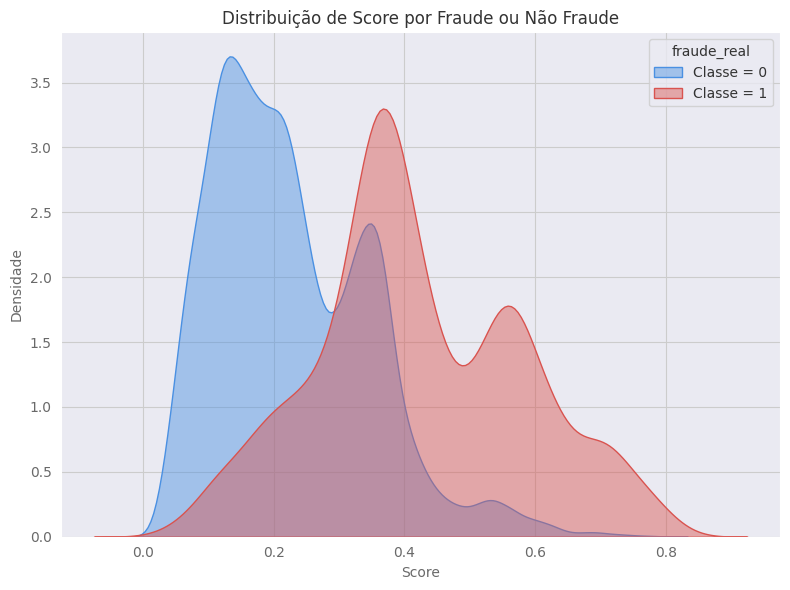

=> DEBUG: Gerando plot de Métricas X Threshold para o conjunto: Teste


=> DEBUG: Gerando plot de Retorno Financeiro X Threshold para o conjunto: Teste


Detalhes Financeiros do Threshold Ótimo:
Lucro: R$ 78607.23
Perdas por Fraude: R$ 60269.72
Receitas: R$ 159791.95
Custos de Revisão: R$ 20915.00
Razão de Lucro: 0.492
=> Coletando lista com métricas para comparação
=> Avaliação do modelo no conjunto de TESTE concluída.


In [ ]:
# Rodando o melhor modelo keras no dataset de teste e aplicando funções finais de avaliação

# Definindo range dos thresholds a serem testados
thresholds_to_test = np.arange(0.1, 1, 0.01) # de 0.1 a 0.99 com passo de 0.01

# Define os parâmetros de negócio
profit_rate = 0.10
rev_cost = 5.0

# Calcule os pesos de classe para o conjunto de treinamento FINAL
final_class_weights = calculate_class_weights(y_train_initial)

# Class labels
class_names_labels = ['Não Fraude', 'Fraude']

# 1=> Prever probabilidades no conjunto de teste
print("=> Previsões de probabilidades no conjunto de TESTE")
pred_proba_test = Best_keras_model.predict(X_test_keras).flatten()

# 2=> Calcular ROC AUC Score para o conjunto de TESTE
roc_auc_test = roc_auc_score(y_test_keras, pred_proba_test)
print(f"=> ROC AUC Score no conjunto de TESTE: {roc_auc_test:.4f}\n")

# 3=> Avaliar métricas para diferentes thresholds no conjunto de TESTE
print("=> Avaliando métricas por threshold no conjunto de TESTE...")
df_metrics_test = evaluate_thresholds(y_test_keras, pred_proba_test, thresholds_to_test)

# Identificar o melhor threshold F1-Score no conjunto de TESTE
best_f1_threshold_test = float(df_metrics_test.loc[df_metrics_test['F1_Score'].idxmax()]['Threshold'])

# 4=> Calcular o Retorno Financeiro para diferentes thresholds no conjunto de TESTE
print("=> Calculando retorno financeiro por threshold no conjunto de TESTE...")
max_overall_profit, best_financial_threshold_test, df_financial_details = \
    financial_return_calculator(y_test_keras, pred_proba_test, tv_test_keras,
        profit_rate, rev_cost, thresholds_to_test)

print(f"Retorno Financeiro Máximo no TESTE: R$ {max_overall_profit:.2f} (Threshold: {best_financial_threshold_test:.4f})\n")

# Para o threshold financeiro ótimo, obtenha as métricas de classificação
y_pred_at_financial_threshold_test = (pred_proba_test >= best_financial_threshold_test).astype(int)
financial_threshold_recall_test = recall_score(y_test_keras, y_pred_at_financial_threshold_test)
financial_threshold_f1_test = f1_score(y_test_keras, y_pred_at_financial_threshold_test)

print(f"Recall no Threshold Financeiro Ótimo: {financial_threshold_recall_test:.4f}")
print(f"F1-Score no Threshold Financeiro Ótimo: {financial_threshold_f1_test:.4f}")

# Cálculo financeiro com o threshold de melhor f1-score para comparação
print("=> Calculando Retorno Financeiro para o Threshold F1-Score Ótimo para comparação...")
f1_optimal_return, _, _ = financial_return_calculator(
    y_test_keras, pred_proba_test, tv_test_keras,
    profit_rate, rev_cost, [best_f1_threshold_test])

print(f"Retorno Financeiro no Threshold F1-Score Ótimo: R$ {f1_optimal_return:.2f}\n")

# 5=> Gerar Matrizes de Confusão nos thresholds ótimos
print("=> Matriz de Confusão no conjunto de TESTE (Threshold Financeiro Ótimo):\n")
y_pred_financial_optimal_test = (pred_proba_test >= best_financial_threshold_test).astype(int)
cm_financial_optimal_test = confusion_matrix(y_test_keras, y_pred_financial_optimal_test)
print(cm_financial_optimal_test)
print(classification_report(y_test_keras, y_pred_financial_optimal_test))

# Plot da Matriz de Confusão para Threshold Financeiro Ótimo
print(plot_confusion_matrix(Best_keras_model, X_test_keras, y_test_keras, best_financial_threshold_test,
                            class_names_labels, title_suffix="Teste - Threshold Financeiro Ótimo"))

# 6=> Gerar Plots para o conjunto de TESTE
print("=> Gerando plots para o conjunto de TESTE...")

# Plot roc auc curve and pr curve
plot_roc_auc_curve (Best_keras_model, X_test_keras, y_test_keras, model_name="Keras", title_suffix="Best Model")

plot_precision_recall_curve(Best_keras_model, X_test_keras, y_test_keras, model_name="Keras", title_suffix="Best Model")

# Plot class distribution
df_class_dist = pd.DataFrame({
    'scores_modelo': pred_proba_test, # Coluna para os scores
    'fraude_real': y_test_keras.flatten() # Coluna para os rótulos
                          })

plot_class_distribution(df_class_dist, 'scores_modelo', 'fraude_real', threshold= None)

# Plot de Métricas X Threshold
plot_best_threshold(df_metrics_test, "Teste", best_f1_threshold_test, best_financial_threshold_test)

# Plot de Retorno Financeiro X Threshold
plot_financial_threshold(df_financial_details , "Teste", best_f1_threshold_test, best_financial_threshold_test)

best_threshold_details = df_financial_details[df_financial_details['Threshold'] == best_financial_threshold_test].iloc[0]
print("Detalhes Financeiros do Threshold Ótimo:")
print(f"Lucro: R$ {best_threshold_details['Profit']:.2f}")
print(f"Perdas por Fraude: R$ {best_threshold_details['Fraud_Losses']:.2f}")
print(f"Receitas: R$ {best_threshold_details['Revenues']:.2f}")
print(f"Custos de Revisão: R$ {best_threshold_details['Review_Costs']:.2f}")
print(f"Razão de Lucro: {(best_threshold_details['Profit'] / best_threshold_details['Revenues']):.3f}")

# Armazenar em um dicionário para a tabela final
print(f"=> Coletando lista com métricas para comparação")
metrics_keras = {
    'ROC AUC': roc_auc_test,
    'Max F1-Score': best_f1_threshold_test,
    'Threshold Financeiro Ótimo': best_financial_threshold_test,
    'Lucro (Th Financeiro Ótimo)': best_threshold_details['Profit'],
    'Perdas por Fraude (Th Financeiro Ótimo)': best_threshold_details['Fraud_Losses'],
    'Receitas (Th Financeiro Ótimo)': best_threshold_details['Revenues'],
    'Custos de Revisão (Th Financeiro Ótimo)': best_threshold_details['Review_Costs'],
    'Razão de Lucro (Th Financeiro Ótimo)': best_threshold_details['Profit'] / best_threshold_details['Revenues'],
    'Recall no Threshold Financeiro Ótimo': financial_threshold_recall_test,
    'F1-Score no Threshold Financeiro Ótimo': financial_threshold_f1_test
}

print("=" * 50)
print("=> Avaliação do modelo no conjunto de TESTE concluída.")


### Modelo Original

Pesos de Classe Calculados: {0: np.float64(0.5263157894736842), 1: np.float64(10.0)}
Contagem de Não-Fraude (Classe 0): 99750
Contagem de Fraude (Classe 1): 5250
=> Previsões de probabilidades no conjunto de TESTE
=> ROC AUC Score no conjunto de TESTE: 0.7318

=> Avaliando métricas por threshold no conjunto de TESTE...
=> Calculando retorno financeiro por threshold no conjunto de TESTE...
=> DEBUG: Iniciando cálculo de retorno financeiro
Retorno Financeiro Máximo no TESTE: R$ -214218.28 (Threshold: 0.1000)

Recall no Threshold Financeiro Ótimo: 0.9796
F1-Score no Threshold Financeiro Ótimo: 0.0963
=> Matriz de Confusão no conjunto de TESTE (Threshold Financeiro Ótimo):

[[ 1421 41329]
 [   46  2204]]
              precision    recall  f1-score   support

         0.0       0.97      0.03      0.06     42750
         1.0       0.05      0.98      0.10      2250

    accuracy                           0.08     45000
   macro avg       0.51      0.51      0.08     45000
weighted avg      

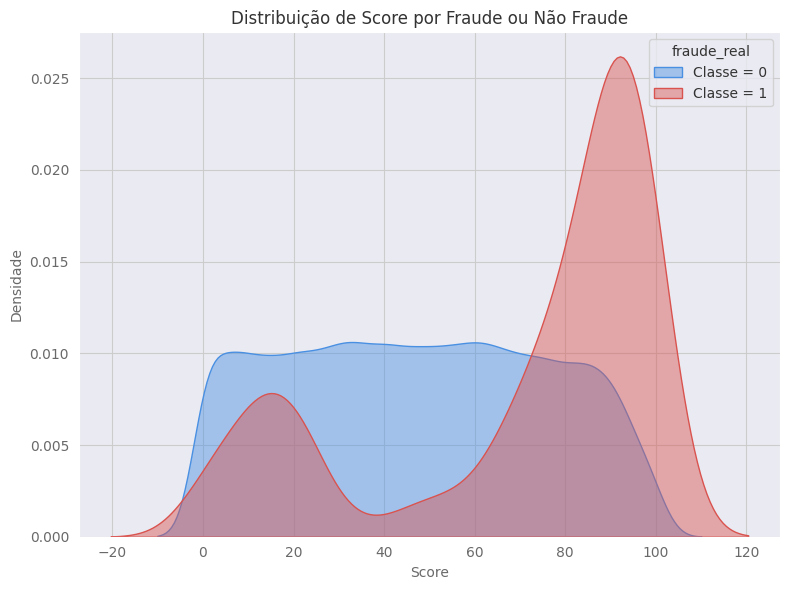

Detalhes Financeiros do Threshold Ótimo:
Lucro: R$ -214218.28
Perdas por Fraude: R$ 1724.91
Receitas: R$ 5171.63
Custos de Revisão: R$ 217665.00
Razão de Lucro: -41.422
=> Coletando lista com métricas para comparação
=> Avaliação do modelo no conjunto de TESTE concluída.


In [ ]:

# Rodando o melhor modelo no dataset de teste e aplicando funções finais de avaliação

# Definindo range dos thresholds a serem testados
thresholds_to_test = np.arange(0.1, 1, 0.01) # de 0.1 a 0.99 com passo de 0.01

# Define os parâmetros de negócio
profit_rate = 0.10
rev_cost = 5.0

# Calcule os pesos de classe para o conjunto de treinamento FINAL
final_class_weights = calculate_class_weights(y_train_initial)

# Class labels
class_names_labels = ['Não Fraude', 'Fraude']


# 1=> Prever probabilidades no conjunto de teste
print("=> Previsões de probabilidades no conjunto de TESTE")
pred_proba_test = X_test_raw['score_fraude_modelo']

# Converter y_test_raw e tv_raw para arrays NumPy 1D
y_test_np = y_test_raw.values.astype('float32') # Convertendo Series para NumPy array 1D
tv_test_np = tv_raw.values.astype('float32')

# 2=> Calcular ROC AUC Score para o conjunto de TESTE
roc_auc_test = roc_auc_score(y_test_np, pred_proba_test)
print(f"=> ROC AUC Score no conjunto de TESTE: {roc_auc_test:.4f}\n")

# 3=> Avaliar métricas para diferentes thresholds no conjunto de TESTE
print("=> Avaliando métricas por threshold no conjunto de TESTE...")
df_metrics_test = evaluate_thresholds(y_test_np, pred_proba_test, thresholds_to_test)

# 4=> Calcular o Retorno Financeiro para diferentes thresholds no conjunto de TESTE
print("=> Calculando retorno financeiro por threshold no conjunto de TESTE...")
max_overall_profit, best_financial_threshold_test, df_financial_details = \
    financial_return_calculator(
        y_test_np, pred_proba_test, tv_test_np,
        profit_rate, rev_cost, thresholds_to_test)

print(f"Retorno Financeiro Máximo no TESTE: R$ {max_overall_profit:.2f} (Threshold: {best_financial_threshold_test:.4f})\n")

# Para o threshold financeiro ótimo, obtenha as métricas de classificação
best_f1_threshold_test = df_metrics_test.loc[df_metrics_test['F1_Score'].idxmax()]['Threshold']

y_pred_at_financial_threshold_test = (pred_proba_test >= best_financial_threshold_test).astype(int)
financial_threshold_recall_test = recall_score(y_test_np, y_pred_at_financial_threshold_test)
financial_threshold_f1_test = f1_score(y_test_np, y_pred_at_financial_threshold_test)

print(f"Recall no Threshold Financeiro Ótimo: {financial_threshold_recall_test:.4f}")
print(f"F1-Score no Threshold Financeiro Ótimo: {financial_threshold_f1_test:.4f}")

# 5=> Gerar Matrizes de Confusão nos thresholds ótimos
print("=> Matriz de Confusão no conjunto de TESTE (Threshold Financeiro Ótimo):\n")
y_pred_financial_optimal_test = (pred_proba_test >= best_financial_threshold_test).astype(int)
cm_financial_optimal_test = confusion_matrix(y_test_np, y_pred_financial_optimal_test)
print(cm_financial_optimal_test)
print(classification_report(y_test_np, y_pred_financial_optimal_test))

# Plot da Matriz de Confusão para Threshold Financeiro Ótimo
# print(plot_confusion_matrix(None, X_test, y_test_np, best_financial_threshold_test,
#                             class_names_labels, title_suffix="Teste - Threshold Financeiro Ótimo"))

# 6=> Gerar Plots para o conjunto de TESTE
print("=> Gerando plots para o conjunto de TESTE...")

# Plot roc auc curve and pr curve
# plot_roc_auc_curve (None, X_test, y_test_np, model_name="MModelo Original", title_suffix="Original")

# plot_precision_recall_curve(None, X_test, y_test_np, model_name="MModelo Original", title_suffix="Original")

# Plot class distribution
df_class_dist = pd.DataFrame({
    'scores_modelo': pred_proba_test,        # Coluna para os scores
    'fraude_real': y_test_raw.values if isinstance(y_test_raw, np.ndarray) else y_test_raw # Coluna para os rótulos
                          })

plot_class_distribution(df_class_dist, 'scores_modelo', 'fraude_real', threshold= None)

# # Plot de Métricas X Threshold
# plot_best_threshold(df_metrics_test, "Teste", best_f1_threshold_test, best_financial_threshold_test)

# # Plot de Retorno Financeiro X Threshold
# plot_financial_threshold(df_financial_details , "Teste", best_f1_threshold_test, best_financial_threshold_test)

best_threshold_details = df_financial_details[df_financial_details['Threshold'] == best_financial_threshold_test].iloc[0]
print("Detalhes Financeiros do Threshold Ótimo:")
print(f"Lucro: R$ {best_threshold_details['Profit']:.2f}")
print(f"Perdas por Fraude: R$ {best_threshold_details['Fraud_Losses']:.2f}")
print(f"Receitas: R$ {best_threshold_details['Revenues']:.2f}")
print(f"Custos de Revisão: R$ {best_threshold_details['Review_Costs']:.2f}")
print(f"Razão de Lucro: {(best_threshold_details['Profit'] / best_threshold_details['Revenues']):.3f}")

# Armazenar em um dicionário para a tabela final
print(f"=> Coletando lista com métricas para comparação")
metrics_original = {
    'ROC AUC': roc_auc_test,
    'Max F1-Score': best_f1_threshold_test,
    'Threshold Financeiro Ótimo': best_financial_threshold_test,
    'Lucro (Th Financeiro Ótimo)': best_threshold_details['Profit'],
    'Perdas por Fraude (Th Financeiro Ótimo)': best_threshold_details['Fraud_Losses'],
    'Receitas (Th Financeiro Ótimo)': best_threshold_details['Revenues'],
    'Custos de Revisão (Th Financeiro Ótimo)': best_threshold_details['Review_Costs'],
    'Razão de Lucro (Th Financeiro Ótimo)': best_threshold_details['Profit'] / best_threshold_details['Revenues'],
    'Recall no Threshold Financeiro Ótimo': financial_threshold_recall_test,
    'F1-Score no Threshold Financeiro Ótimo': financial_threshold_f1_test
}

print("=" * 50)
print("=> Avaliação do modelo no conjunto de TESTE concluída.")


#### Conclusões a Partir da Avaliação dos modelos Finais

In [ ]:
print("=" * 50)
print("Tabela Comparativa de Métricas dos Modelos")
print("=" * 50)

# Cria o DataFrame
df_comparativo_modelos_finais = pd.DataFrame({
    'Modelo Original': pd.Series(metrics_original),
    'LightGBM Model': pd.Series(metrics_lgbm),
    'Keras Model': pd.Series(metrics_keras)
})
display(round(df_comparativo_modelos_finais, 2))


Tabela Comparativa de Métricas dos Modelos


,Modelo Original,LightGBM Model,Keras Model
ROC AUC,0.73,0.85,0.84
Max F1-Score,0.10,0.61,0.45
Threshold Financeiro Ótimo,0.10,0.47,0.40
Lucro (Th Financeiro Ótimo),-214218.28,80855.23,78607.23
Perdas por Fraude (Th Financeiro Ótimo),1724.91,57181.80,60269.72
Receitas (Th Financeiro Ótimo),5171.63,160587.03,159791.95
Custos de Revisão (Th Financeiro Ótimo),217665.00,22550.00,20915.00
Razão de Lucro (Th Financeiro Ótimo),-41.42,0.50,0.49
Recall no Threshold Financeiro Ótimo,0.98,0.53,0.48
F1-Score no Threshold Financeiro Ótimo,0.10,0.35,0.33


####**Comparação entre os Modelos**

A análise comparativa dos três modelos revela diferenças relevantes em termos de eficácia e viabilidade financeira.

1. **Desempenho do Modelo Original**:

O Modelo Original apresentava um cenário financeiro insustentável, que precisava ser diagnosticado e corrigido urgentemente:

Retorno financeiro negativo: Registrava um grande prejuízo de R/$ 214.218 negativos e com uma razão de lucro de 41.42 negativa. Ou seja, para cada R\$ 100 que eram transacionados, a empresa perdia R\$ 41.

Custos excessivos: Este prejuízo é diretamente atribuído aos  custos de revisão extremamente elevados, de R$ 217.665,00. Isso ocorria porque este modelo provavelmente gerava um número muito grande de falsos positivos ou seja, a maioria das transações legítimas eram incorretamente marcadas para revisão, sobrecarregando o sistema e gerando elevado custo desnecessário, mesmo com um alto Recall que barrava a maioria das transações que eram fraudes. O sistema estava de fato barrando a maioria das fraudes, porém junto com elas, estava barrando uma grande quantidade de transações corretas que precisavam ser revistas a um custo que, somado, era maior que o próprio faturamento com as vendas.

Baixa qualidade de classificação: O F1-Score de 0.10 confirma a má qualidade geral das classificações, indicando que o alto recall é obtido à custa de uma precisão muito baixa. Aquilo que falamos acima: um alto recall sacrificava a precisão ao prever a classe não-fraude. O modelo estava classificando tudo comoo fraude, as verdadeiras positivas e as falsas positivas.

O ROC AUC de 0.73 e o gráfico de separação das classes sugere uma boa capacidade discriminatória, mas claramente inviável sob o ponto de vista financeiro. Ao classificar a maioria das transações como positivas (fraude), o modelko evidentemente pegava  amaioria das fraudes, mas junto pegava auma grande parte das transações legítimas e lhes atribuía o rótulo de fraude.


2. **Desempenho do LightGBM e Keras**:

Ambos os novos modelos, LightGBM e Keras, demonstram uma melhoria substancial em relação ao modelo original, transformando este cenário de prejuízo em possibilidade de lucro. Apenas por calibrar as métricas usadas e o threshold (ponto de corte) das classificações, os novos modelos performaram muito melhor do que o original.

LightGBM: Alcança um retorno financeiro de R\$ 80.855,23, com uma razão de lucro de 0.50. Neste caso, para cada 100 reais transacionados, a empresa faturava 50 reais, bem melhor que a versão original.

Keras: Gera um retorno financeiro de R\$ 78.607,23, com uma razão de lucro de 0.49. Apenas um pouco abaixo do LightGBM.


3. **Redução drástica de custos de revisão**:

LightGBM reduz os custos de revisão para R\$ 22.550,00. Enquanto isso, Keras reduz os custos de revisão ainda mais, para R\$ 20.915,00. A grande diferença nos custos de revisão é o principal motor da rentabilidade dos novos modelos, mostrando que eles são muito mais eficientes na identificação de fraudes, sem sobrecarregar o processo com falsos positivos.


4. **Perdas por fraude X receitas**:

Apesar de apresentarem perdas por fraude significativamente maiores (LightGBM R\$ 57.181,80 e Keras R\$ 60.269,72) em comparação com o modelo original, o aumento massivo nas receitas (LightGBM R\$ 160.587,03 Keras R\$ 159.791,95) e a redução dos custos de revisão compensam positivamente, resultando em lucro líquido.

Isso sugere um balanço mais realista e alinhado às necessidades do negócio, onde não se tenta capturar 100 % das fraudes a qualquer custo, mas sim otimizar o retorno financeiro.


5. **Métricas de classificação aprimoradas**:

A principal métrica avaliada foi o F1-Score, justamente por buscar este equilíbrio noo modelo de classificação. Ambos exibem F1-Score notavelmente maiores que o modelo original (LightGBM 0.61 e Keras 0.45), refletindo este equilíbrio desejado entre precisão e recall.

Ambos os modelos mostram um ROC AUC superior (LightGBM 0.85 e Keras 0.84) em comparação com o modelo original, indicando também uma melhoria no poder discriminatório geral.

Os recalls são mais moderados (LightGBM 0.53 e Keras 0.48), indicando que os modelos são mais seletivos ao classificar transações como fraude, o que se alinha com a minimização dos custos de revisão que estavam inviabilizando a operação no modelo anterior.


6. **Comparação entre LightGBM e Keras**

LightGBM emerge como o modelo de melhor desempenho geral, ligeiramente superior ao Keras na maioria das métricas-chave, como ROC AUC (0.85 X 0.84), F1-Score (0.61 X 0.45), mas sobretudo no retorno financeiro (R$80.855,23 X R$ 78.607,23), onde a diferença, apesar de não ser tão grande pode se tornar mais relevante quando pensamos em uma escala maior de dados (esta amostra possuía apenas 150 mil entradas).

O modelo Keras se destaca por ter um custo de revisão ligeiramente menor (R$20.915,00 X R$22.550,00) e um threshold financeiro ideal um pouco menor (0.40 X 0.47), o que indica um modelo mais conservador ao marcar transações para revisão, captando mais fraudes (verdadeiros positivos), mas também pegando mais transações legítimas classificadas erroneamente (falsos positivos).


####**Decisão Final**

A tabela demonstra de forma clara que tanto o LightGBM Model quanto o Keras representam um avanço fundamental em relação ao modelo original. Eles não apenas melhoram as métricas técnicas de classificação, mas, transformam uma operação deficitária em lucrativa, principalmente pela gestão eficiente dos custos de revisão.

Entre os dois novos modelos, o LightGBM mostra uma performance ligeiramente superior em termos de retorno financeiro e capacidade preditiva geral (ROC AUC, F1-Score), além de ser um modelo mais rápido e menos exigente computacionalmente, tornando-o o candidato certo para implementação em produção.


### Feature Importances com Shap Values

  * SHAP (SHapley Additive exPlanations) é uma metodologia que calcula a contribuição de cada feature para a previsão de uma instância individual, comparando-a com a previsão média (ou base value) de todo o dataset.

  * SHAP values indicam o quanto cada feature "empurra" ou "puxa" a previsão do modelo de um valor base (média das previsões) para o valor previsto para aquela instância. Ele mostra o quão importante uma feature é, mas também se ela está empurrando a previsão para cima ou para baixo.

  * Também facilita a identificação de como as features interagem entre si para influenciar as previsões, possibilitando um entendimento mais apurado sobre possíveis caminhos em feature engineering para aprimorar os modelos.

In [ ]:
import shap

# Para Lgbm primeiro, usar o explainer TreeExplainer

explainer_lgbm = shap.TreeExplainer(LGBM_Model)
shap_values = explainer_lgbm.shap_values(X_test)


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:583: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



In [ ]:
# Para um classificador binário, a classe positiva (fraude) índice 1

shap_values_for_positive_class = shap_values
expected_value_for_positive_class = explainer_lgbm.expected_value # O base_value para a classe positiva

shap_explanation_positive_class = shap.Explanation(
    values= shap_values_for_positive_class,
    base_values= expected_value_for_positive_class,
    data= X_test.values, # Passar os valores como array numpy
    feature_names= X_test.columns.tolist())

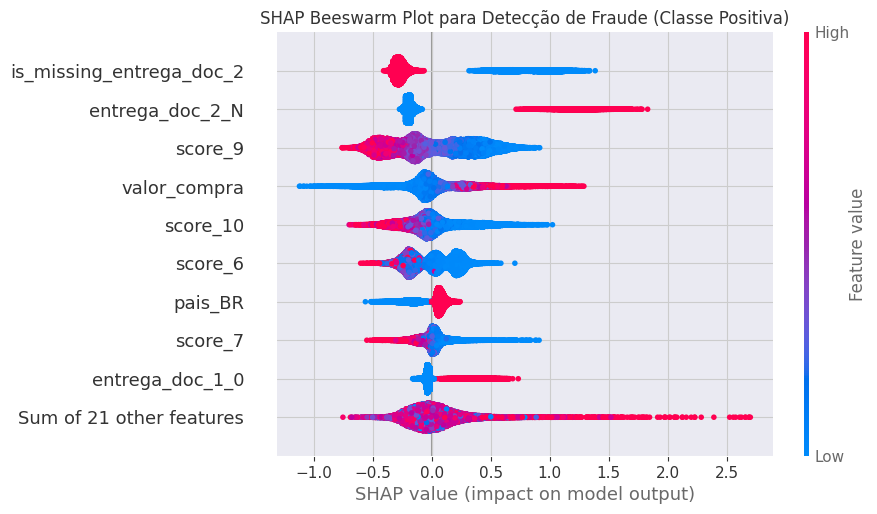

In [ ]:
# Beeswarm Plot

shap.plots.beeswarm(shap_explanation_positive_class, show=False)
plt.title("SHAP Beeswarm Plot para Detecção de Fraude (Classe Positiva)")
plt.show()

**SHAP > 0**: Empurra a previsão para categoria Fraude

**SHAP < 0**: Empurra a previsão para categoria Não Fraude

Quanto maior a dispersão através do eixo X, maior a importância

Vermelho = Valor alto da feature naquele ponto

Azul = Valor baixo da feature naquele ponto


####Observações por feature

  * is_missing_entrega_2 é bem impoortante, vermelho é ausência da feature. A falta do documento aumenta significativamente a probabilidade de fraude.

  * entrega_doc_2_N possui a mesma consequência. Falta do documento resulta em um risco maior de fraude.

  * score_9, 10 e 7 possui muitas observações azuis à esquerda indicam que quanto menor o score, maior a probabilidade de fraude.

  * valor_compra possui muitas informações azuis à esquerda, indica que baixos valores de compra aumentam a chance de fraude.

  * pais_BR com muitos pontos em vermelho do lado direito indica que compras originadas no Brasil possuem maior probabilidade de fraude.

  * entregga_doc_1_0 possui muitas pontos vermelhos à direita, indicando que dadfos com codificação entrega=0 (não entregou) aumenta a probabilidade de fraude.

  * Soma das 21 outras features contribui em menor intensidade de efeito no problema de classificação.



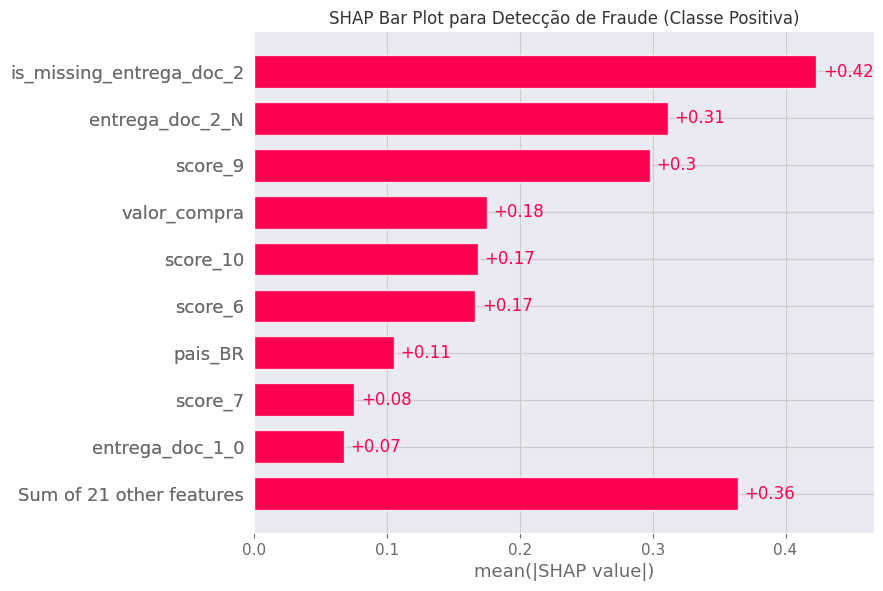

In [ ]:
# Bar Plot

shap.plots.bar(shap_explanation_positive_class, show= False)
plt.title("SHAP Bar Plot para Detecção de Fraude (Classe Positiva)")
plt.show()


  * Valores em vermelho à direita contribuem com maior probabilidade de fraude.

  * Documento 2 e score 9 são as features que mais contribuem para aumentar a probabilidade de fraude.

  * No gráfico abaixo, uma entrada da classe positiva recebe os valores SHAP das features que mais contribuem para sua classificação. Este gráfico é diferente para cada ponto escolhido, pois cada observação possui uma relação de explicabilidade.

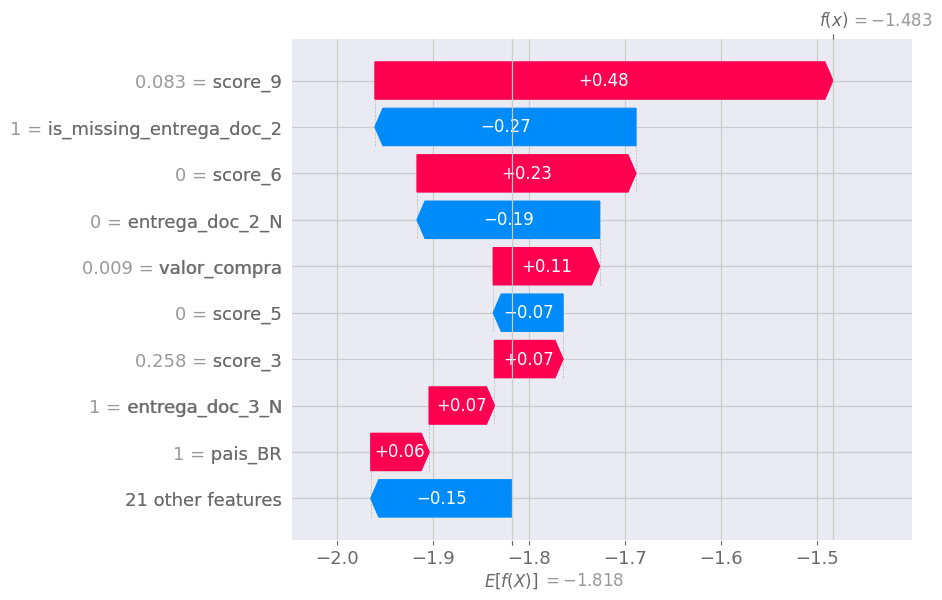

In [ ]:
# Waterfall =>>>> Gráfico que olha para uma entrada de dado e procura exlicar a importancia das variáveis para ela

shap.plots.waterfall(shap_explanation_positive_class[2500])



<Figure size 700x500 with 0 Axes>

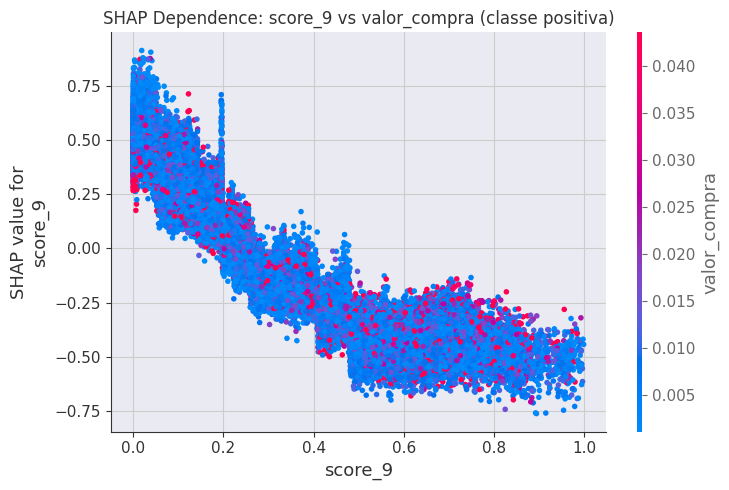

In [ ]:
# Shap dependence plot entre score 9 e valor compra

plt.figure(figsize=(7, 5))
shap.dependence_plot("score_9", shap_explanation_positive_class.values, X_test, interaction_index="valor_compra", show=False )

plt.title("SHAP Dependence: score_9 vs valor_compra (classe positiva)")
plt.tight_layout()
plt.show()


  * O eixo X mostra os valores reais da feature. No centro do eixo Y está o zero. O score 9 empurra a predição para baixo (valores SHAP < 0, classe não fraude) ou para cima (valores SHAP > 0, classe fraude)?

  * As cores dos pontos representam o valor da compra, quanto mmais vermelho mais alto o valor da commpra.

  * Score 9 baixo (esquerda, acima do gráfico) puxa a previsão para a classe positiva, enquanto scores altos (direita, abaixo do gráfico) puxam para a classe negativa.
  
  * Valor da compra alto atenua este efeito do score 9. Estes pontos vermelhos (compras de maior valor) estão mais concentrados na classe negativa e em faixas de score mais altas.

  * Confirma a leitura de que score 9 baixo aumenta a probabilidade de ser fraude, enquanto valores altos fazem este risco de fraude ficar bem menor, quase inexistente.

<Figure size 700x500 with 0 Axes>

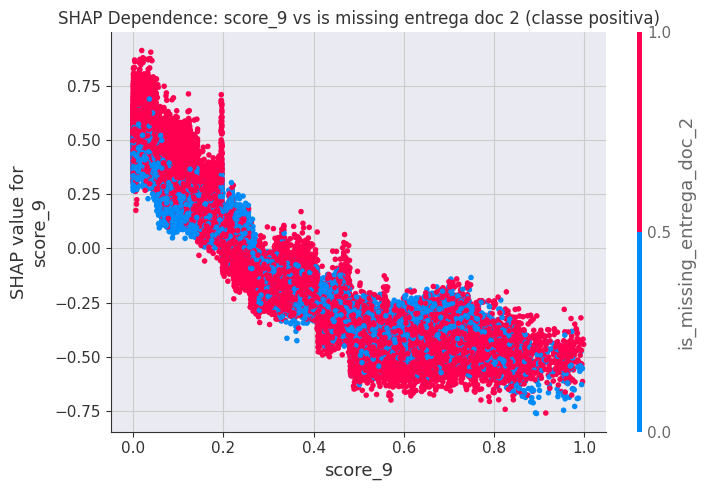

In [ ]:
# Shap dependence plot entre score 9 e is missing doc 2

plt.figure(figsize=(7, 5))
shap.dependence_plot("score_9", shap_explanation_positive_class.values, X_test, interaction_index="is_missing_entrega_doc_2", show=False )

plt.title("SHAP Dependence: score_9 vs is missing entrega doc 2 (classe positiva)")
plt.tight_layout()
plt.show()


  * A relação que se observa neste gráfico é de que valores baixos de score 9 tem efeito amplificado de pertencer à classe positiva (fraude) conforme não se entrega o documento 2.

  * Porém também há muitos casos de falta de entrega do documento 2 que possuem score 9 maior e não são fraude.

  * Estas duas variáveis se relacionam de uma forma mais diretamente proporcional, dito de outra forma: quando o score 9 aumenta e a ausência do documento aumenta, diminui a probabilidade de fraude.

## Etapa 8 - Conclusão

  * Foram testados quatro modelos considerados clássicos, todos da biblioteca Scikit Learn, e quatro modelos construídos com redes neurais usando a biblioteca Keras / Tensorflow.

  * Foi feita uma opção de não usar estratégias controversas de oversampling ou undersampling usando SMOTE para balancear os dados, pois os dados reais não são balanceados e faz parte do desafio conseguir formular um modelo que trabalhe adequadamente com dados desbalanceados.

  * Um robusto pipeline de pré-processamento foi montado para aplicar todas as transformações, escalonamentos e encodings de forma consistente nas várias divisões dos dados e também em novos dados. Isso garante que o modelo irá lidar sempre com dados em escala e formatos corretos e processados da mesma forma.

  * Um sistema de monitoramento dos modelos usando MLFlow (MLOPS) foi implementado para acompanhar o desempenho dos modelos e salvar os diferentes runs, métricas e parâmetros. Isso garante uma maior eficiência para recuperar modelos testados, salvar modelos escolhidos e monitorar o avanço dos experimentos.

  * Os modelos foram primeiramente testados quanto a seus melhores hiperparâmetros e depois foi rodada uma validação cruzada com 5 folds para verificar a consistência da performance destes modelos em diferentes conjuntos de dados.

  * Após a validação cruzada, os melhores modelos de cada tipo foram escolhidos e em uma próxima etapa foi feita uma rodada de validação com uma parte separada dos dados. Somente depois desta etapa de validação, os melhores modelos de cada família foram escolhidos para serem testados com um conjunto de teste não visto. LightGBM e Modelo 4 do Keras foram os escolhidos.

  * Nesta rodada de teste, além das métricas estatísticas, os modelos foram testados quanto à sua eficiência em maximizar os ganhos financeiros da empresa. Estes dois modelos foram comparados com o modelo original, tanto em métricas como em desempenho financeiro e no final o modelo LightGBM se mostrou um pouco superior ao modelo Keras.

  * Os dois modelos se mostraram muito superiores ao modelo original, invertendo uma tendência de prejuízo financeiro em função de gastos operacionais elevados com verificação de falsos positivos. O modelo escolhido, além de ter uma performance um pouco acima do outro candidato, ainda é mais rápido de ser retreinado, o que o torna também mais robusto e responsivo a eventuais drifts (mudanças na forma como os dados se comportam).
  
  * Houve um aprimoramento da capacidade preditiva em relação ao modelo original que se reflete de forma inequívoca no aumento do lucro da empresa.

  * Há potencial para aumento da eficácia deste modelo novo ao preparar e filtrar features que estão mais relacionadas, como visto nos SHAP values.

  * Esta é uma etapa que considero ser um desenvolvimento contínuo, onde mais experimentos e tentativas podem sempre resultar em melhorias. Sendo assim, o encerramento deste projeto não significa o encerramento do problema e novas soluções irão surgir. Sobretudo porque este problema de detecção de fraude é um problema em constante mudança e os fraudadores estão sempre buscando novas alternativas e métodos perspicazes para conseguirem alcançar os seus objetivos ilícitos.